# Preprocessing

## Pacu

In [1]:
import os, sys
import pickle
import pandas as pd
import numpy as np

# 피크 사이 wave를 모두 같은 length로 만들기 위한 함수
def linear_connection(list, idx):
    int_idx = int(idx)
    return list[int_idx] + (list[int_idx+1] - list[int_idx]) * (idx - int_idx)



### input 설정
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수


# vital data 저장 경로
preprocess_path = '../../cranberry2/Preprocessing/'
vital_path = preprocess_path + 'NRS_vital_pickle_unzip/NRS_vital_pickle'
f_vital_list = os.listdir(vital_path)


# 전처리 정보를 담을 Dataframe
column_list = ['file_path'] + [str(i+1) for i in range(n_aug)] #+ ['NRS']
df_preprocess = pd.DataFrame(columns = column_list)


SRATE, f_num = 100, 0
for f_vital in f_vital_list[0:2000]:
    f_num += 1
    
    print('###Input', f_num,'/ '+str(len(f_vital_list))+': '+f_vital+'###')
    
    # ppg, ecg peaks 불러오기
    # peaks가 없는 경우는 ECG나 PPG data가 없는 case들
    if not os.path.exists(preprocess_path+'cache/PPG_peaks/'+f_vital):
        print('no existing PPG peaks: ', f_vital)
        continue
    if not os.path.exists(preprocess_path+'cache/ECG_peaks/'+f_vital):
        print('no existing ECG peaks: ', f_vital)
        continue
    
    # vital data 불러오기    
    df_vital = pickle.load(open(vital_path+'/'+f_vital, 'rb')).reset_index()
    
    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'file_path'] = f_vital
        
    ppg_min, ppg_peak = pickle.load(open(preprocess_path+'cache/PPG_peaks/'+f_vital, 'rb'))
    ecg_peak = pickle.load(open(preprocess_path+'cache/ECG_peaks/'+f_vital, 'rb'))
    
    ppg_min, ppg_peak = np.array([ppg_min]), np.array([ppg_peak])
    ecg_peak= np.array([ecg_peak])
    
    
    # 10초 단위로 끊기
    for i in range(n_aug):
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000
        
        seg_ppg, seg_ecg = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]
        df_vital_input = df_vital.loc[start_idx:end_idx-1]
        seg_ppg[0:len(df_vital_input)] = df_vital_input['Pleth'].tolist()
        seg_ecg[0:len(df_vital_input)] = df_vital_input['ECG'].tolist()
    
        ### 1. 결측치 처리 ###              
        # df.isnull().sum() 하면 더 간단하게 가능하나 애초에 NRS에 해당하는 vital data가 120초 보다 짧은 경우
        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE
        
        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)
            
        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]
        
        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.3 or nan_ecg_perc > 0.3 or nan_both_perc > 0.2:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-1, -1])
            continue
            
        

        ### 2. Noise 처리 ###
        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak[(start_idx<=ppg_peak) & (ppg_peak<end_idx)] - start_idx
        idx_ecg_peak = ecg_peak[(start_idx<=ecg_peak) & (ecg_peak<end_idx)] - start_idx
        
        # peak가 5개 이하는 noise가 많이 낀 상황 (10초 구간 중 peak가 7초 이상 없으면 문제 -> 즉 peak 개수 범위는 7/2 ~ 7/0.4)
        # 따라서 peak가 7초 이상 있어야하고 이때 최소 peak 개수는 3.5개 (20초면 7이하)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<=4 or len(idx_ecg_peak)<=4:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-2, -2])
            continue

            
        # 10초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]
        
        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]
        
        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 40 < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 200:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 40 < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 200:
                bool_noise_ecg[k] = True
                
        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 200
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])
        
        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])
          
        
        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.8:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)
        
        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.8:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)
        
        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]
        
        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.3 and nan_ecg_perc < 0.3 and nan_both_perc < 0.2 and noise_ppg_perc < 0.5 and noise_ecg_perc < 0.5:
            bool_pass = True
        else:
            bool_pass = False
       
        # 이 segment의 정보를 dataframe에 저장
        df_preprocess.loc[f_num-1,str(i+1)] = (bool_pass, nan_info, noise_info)        

    if f_num%1000 == 0:
        print('dumping cache of d_preprocess -', f_num, '/ 8318')
        pickle.dump(df_preprocess, open('cache/input3/df_preprocess_pacu_0-2000', 'wb'))
        
print('dumping cache of d_preprocess -', f_num, '/ 8318')
pickle.dump(df_preprocess, open('cache/input3/df_preprocess_pacu_0-2000', 'wb'))


###Input 1 / 8318: 3.0,249,PACU1_2_190503_132609.csv###
###Input 2 / 8318: 8.0,1444,PACU1_5_190723_131001.csv###
###Input 3 / 8318: 3.0,5650,PACU1_12_200604_165543.csv###
###Input 4 / 8318: 6.0,5450,PACU1_12_200528_152944.csv###
###Input 5 / 8318: 3.0,7909,PACU1_12_201008_143103.csv###
###Input 6 / 8318: 6.0,2882,PACU1_12_200109_150545.csv###
###Input 7 / 8318: 5.0,8045,PACU1_6_201016_093657.csv###
###Input 8 / 8318: 5.0,4027,PACU1_9_200225_093113.csv###
###Input 9 / 8318: 3.0,7238,PACU1_3_200827_194040.csv###
###Input 10 / 8318: 8.0,2271,PACU1_1_190909_143818.csv###
###Input 11 / 8318: 8.0,1895,PACU1_6_190828_082910.csv###
###Input 12 / 8318: 3.0,8130,PACU1_1_201020_220244.csv###
###Input 13 / 8318: 7.0,1406,PACU1_8_190722_124706.csv###
###Input 14 / 8318: 10.0,1119,PACU1_5_190710_164522.csv###
###Input 15 / 8318: 5.0,746,PACU1_2_190531_091955.csv###
###Input 16 / 8318: 6.0,599,PACU1_7_190524_091407.csv###
###Input 17 / 8318: 4.0,8255,PACU1_7_201027_110406.csv###
###Input 18 / 8318: 8

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


###Input 24 / 8318: 5.0,1330,PACU1_11_190718_145520.csv###
###Input 25 / 8318: 4.0,4785,PACU1_11_200325_125712.csv###
###Input 26 / 8318: 6.0,4395,PACU1_6_200310_121627.csv###
###Input 27 / 8318: 5.0,6936,PACU1_1_200810_122348.csv###
###Input 28 / 8318: 7.0,1281,PACU1_4_190717_172426.csv###
###Input 29 / 8318: 7.0,2364,PACU1_4_190912_000138.csv###
###Input 30 / 8318: 5.0,5145,PACU1_1_200514_144525.csv###
###Input 31 / 8318: 8.0,2927,PACU1_10_200110_130059.csv###
###Input 32 / 8318: 8.0,350,PACU1_3_190509_211631.csv###
###Input 33 / 8318: 9.0,1283,PACU1_5_190717_190617.csv###
###Input 34 / 8318: 3.0,3797,PACU1_2_200218_093808.csv###
###Input 35 / 8318: 5.0,3230,PACU1_6_200122_122323.csv###
###Input 36 / 8318: 5.0,1154,PACU1_2_190711_085132.csv###
###Input 37 / 8318: 9.0,7289,PACU1_2_200909_092156.csv###
###Input 38 / 8318: 3.0,3758,PACU1_2_200215_014656.csv###
###Input 39 / 8318: 6.0,1115,PACU1_2_190710_171004.csv###
###Input 40 / 8318: 6.0,209,PACU1_9_190502_142127.csv###
###Input 41 /

###Input 165 / 8318: 7.0,4229,PACU1_10_200303_162448.csv###
###Input 166 / 8318: 5.0,924,PACU1_3_190703_171251.csv###
###Input 167 / 8318: 5.0,6620,PACU1_6_200722_083316.csv###
###Input 168 / 8318: 3.0,7246,PACU1_1_200828_172552.csv###
###Input 169 / 8318: 8.0,2132,PACU1_7_190904_172040.csv###
###Input 170 / 8318: 3.0,874,PACU1_5_190612_163931.csv###
###Input 171 / 8318: 5.0,1512,PACU1_8_190816_152119.csv###
###Input 172 / 8318: 8.0,7221,PACU1_6_200825_095049.csv###
###Input 173 / 8318: 5.0,596,PACU1_4_190523_200356.csv###
###Input 174 / 8318: 4.0,7930,PACU1_1_201008_183613.csv###
###Input 175 / 8318: 5.0,5390,PACU1_2_200526_234216.csv###
###Input 176 / 8318: 5.0,3837,PACU1_11_200219_095754.csv###
###Input 177 / 8318: 8.0,2189,PACU1_7_190905_182232.csv###
###Input 178 / 8318: 5.0,3879,PACU1_8_200219_164737.csv###
###Input 179 / 8318: 5.0,1611,PACU1_2_190820_135649.csv###
###Input 180 / 8318: 7.0,6072,PACU1_12_200623_152304.csv###
###Input 181 / 8318: 4.0,1373,PACU1_7_190719_133554.csv#

###Input 304 / 8318: 6.0,3573,PACU1_11_200207_142904.csv###
###Input 305 / 8318: 5.0,7511,PACU1_3_200918_005602.csv###
###Input 306 / 8318: 5.0,1207,PACU1_3_190715_150624.csv###
###Input 307 / 8318: 5.0,6856,PACU1_7_200804_134606.csv###
###Input 308 / 8318: 6.0,3274,PACU1_3_200123_120538.csv###
###Input 309 / 8318: 5.0,4098,PACU1_7_200228_121855.csv###
###Input 310 / 8318: 3.0,8073,PACU1_4_201016_174655.csv###
###Input 311 / 8318: 5.0,6837,PACU1_12_200803_143028.csv###
###Input 312 / 8318: 7.0,3029,PACU1_2_200115_141012.csv###
###Input 313 / 8318: 4.0,3767,PACU1_5_200217_113708.csv###
###Input 314 / 8318: 4.0,2645,PACU1_5_191219_165854.csv###
###Input 315 / 8318: 6.0,385,PACU1_5_190513_153956.csv###
###Input 316 / 8318: 8.0,7245,PACU1_1_200828_144451.csv###
###Input 317 / 8318: 3.0,5626,PACU1_2_200604_090759.csv###
###Input 318 / 8318: 3.0,6634,PACU1_4_200722_125624.csv###
###Input 319 / 8318: 5.0,3271,PACU1_3_200123_120538.csv###
###Input 320 / 8318: 5.0,991,PACU1_11_190705_131344.csv

###Input 442 / 8318: 8.0,882,PACU1_1_190617_121710.csv###
###Input 443 / 8318: 7.0,2907,PACU1_4_200110_000846.csv###
###Input 444 / 8318: 5.0,3602,PACU1_5_200210_104932.csv###
###Input 445 / 8318: 5.0,5511,PACU1_3_200529_231452.csv###
###Input 446 / 8318: 3.0,7634,PACU1_6_200923_160908.csv###
###Input 447 / 8318: 6.0,1245,PACU1_1_190716_202834.csv###
###Input 448 / 8318: 3.0,1558,PACU1_10_190819_135024.csv###
###Input 449 / 8318: 8.0,2894,PACU1_2_200109_175440.csv###
###Input 450 / 8318: 6.0,3048,PACU1_9_200115_175359.csv###
###Input 451 / 8318: 5.0,3328,PACU1_3_200129_142528.csv###
###Input 452 / 8318: 7.0,5493,PACU1_11_200529_143500.csv###
###Input 453 / 8318: 6.0,1936,PACU1_5_190829_100712.csv###
###Input 454 / 8318: 6.0,3717,PACU1_2_200214_030259.csv###
###Input 455 / 8318: 4.0,319,PACU1_11_190509_095133.csv###
###Input 456 / 8318: 5.0,5126,PACU1_3_200513_213632.csv###
###Input 457 / 8318: 2.0,8220,PACU1_3_201024_122437.csv###
###Input 458 / 8318: 4.0,6962,PACU1_4_200811_115934.csv

###Input 581 / 8318: 5.0,752,PACU1_5_190531_101851.csv###
###Input 582 / 8318: 8.0,828,PACU1_3_190611_105333.csv###
###Input 583 / 8318: 2.0,2264,PACU1_10_190909_125533.csv###
###Input 584 / 8318: 2.0,4424,PACU1_3_200311_093245.csv###
###Input 585 / 8318: 5.0,5588,PACU1_9_200603_101036.csv###
###Input 586 / 8318: 2.0,1833,PACU1_5_190823_162702.csv###
###Input 587 / 8318: 6.0,6362,PACU1_3_200708_184828.csv###
###Input 588 / 8318: 3.0,1674,PACU1_3_190820_191402.csv###
###Input 589 / 8318: 10.0,6918,PACU1_6_200806_163447.csv###
###Input 590 / 8318: 8.0,2705,PACU1_8_200102_125258.csv###
###Input 591 / 8318: 8.0,3832,PACU1_6_200219_090110.csv###
###Input 592 / 8318: 5.0,3272,PACU1_5_200123_115000.csv###
###Input 593 / 8318: 4.0,6356,PACU1_7_200708_160355.csv###
###Input 594 / 8318: 4.0,4851,PACU1_8_200327_132531.csv###
###Input 595 / 8318: 5.0,8056,PACU1_9_201016_123439.csv###
###Input 596 / 8318: 3.0,931,PACU1_2_190703_215330.csv###
###Input 597 / 8318: 5.0,1647,PACU1_8_190820_163302.csv##

###Input 718 / 8318: 8.0,7422,PACU1_9_200916_092132.csv###
###Input 719 / 8318: 8.0,4494,PACU1_9_200313_135235.csv###
###Input 720 / 8318: 4.0,1549,PACU1_1_190816_184851.csv###
###Input 721 / 8318: 4.0,5252,PACU1_11_200519_170333.csv###
###Input 722 / 8318: 7.0,1790,PACU1_11_190822_145331.csv###
###Input 723 / 8318: 6.0,1463,PACU1_3_190723_195127.csv###
###Input 724 / 8318: 7.0,4234,PACU1_5_200303_195155.csv###
###Input 725 / 8318: 3.0,1570,PACU1_3_190819_205959.csv###
###Input 726 / 8318: 3.0,5436,PACU1_3_200528_113953.csv###
###Input 727 / 8318: 8.0,6034,PACU1_11_200619_153347.csv###
###Input 728 / 8318: 2.0,1521,PACU1_1_190816_154204.csv###
###Input 729 / 8318: 2.0,6741,PACU1_11_200728_132208.csv###
###Input 730 / 8318: 5.0,1088,PACU1_9_190710_093206.csv###
###Input 731 / 8318: 5.0,2179,PACU1_4_190905_150215.csv###
###Input 732 / 8318: 8.0,3139,PACU1_9_200120_121646.csv###
###Input 733 / 8318: 6.0,988,PACU1_11_190705_131344.csv###
###Input 734 / 8318: 7.0,4501,PACU1_7_200313_151802.

###Input 857 / 8318: 4.0,1052,PACU1_4_190709_112306.csv###
###Input 858 / 8318: 3.0,2829,PACU1_7_200108_090440.csv###
###Input 859 / 8318: 5.0,765,PACU1_5_190531_144225.csv###
###Input 860 / 8318: 3.0,527,PACU1_5_190516_174457.csv###
###Input 861 / 8318: 5.0,4533,PACU1_7_200316_154805.csv###
###Input 862 / 8318: 5.0,2554,PACU1_2_191113_114438.csv###
###Input 863 / 8318: 7.0,6361,PACU1_3_200708_184828.csv###
###Input 864 / 8318: 5.0,1588,PACU1_6_190820_105347.csv###
###Input 865 / 8318: 7.0,8123,PACU1_5_201020_171155.csv###
###Input 866 / 8318: 4.0,1390,PACU1_3_190719_154655.csv###
###Input 867 / 8318: 3.0,7206,PACU1_3_200821_223504.csv###
###Input 868 / 8318: 5.0,8081,PACU1_3_201019_094609.csv###
###Input 869 / 8318: 4.0,5767,PACU1_12_200610_094140.csv###
###Input 870 / 8318: 4.0,5195,PACU1_6_200515_165154.csv###
###Input 871 / 8318: 2.0,4947,PACU1_1_200506_135811.csv###
###Input 872 / 8318: 3.0,8269,PACU1_5_201027_151403.csv###
###Input 873 / 8318: 8.0,2479,PACU1_3_191021_093930.csv##

###Input 995 / 8318: 4.0,5615,PACU1_10_200603_164857.csv###
###Input 996 / 8318: 8.0,6348,PACU1_5_200708_142001.csv###
###Input 997 / 8318: 5.0,7715,PACU1_8_200925_162959.csv###
###Input 998 / 8318: 6.0,1159,PACU1_6_190712_083200.csv###
###Input 999 / 8318: 7.0,643,PACU1_4_190527_165508.csv###
###Input 1000 / 8318: 5.0,1853,PACU1_1_190827_103157.csv###
dumping cache of d_preprocess - 1000 / 8318
###Input 1001 / 8318: 6.0,5017,PACU1_5_200508_130334.csv###
###Input 1002 / 8318: 6.0,5530,PACU1_5_200601_142745.csv###
###Input 1003 / 8318: 8.0,2587,PACU1_9_191128_144712.csv###
###Input 1004 / 8318: 2.0,5979,PACU1_8_200617_155220.csv###
###Input 1005 / 8318: 3.0,4794,PACU1_3_200325_152610.csv###
###Input 1006 / 8318: 3.0,3283,PACU1_3_200123_162554.csv###
###Input 1007 / 8318: 9.0,3747,PACU1_1_200214_181636.csv###
###Input 1008 / 8318: 6.0,3135,PACU1_3_200120_100745.csv###
###Input 1009 / 8318: 8.0,4799,PACU1_9_200325_171903.csv###
###Input 1010 / 8318: 7.0,5407,PACU1_9_200527_133938.csv###
#

###Input 1131 / 8318: 7.0,612,PACU1_7_190524_125100.csv###
no existing PPG peaks:  7.0,612,PACU1_7_190524_125100.csv
###Input 1132 / 8318: 6.0,1422,PACU1_3_190723_052629.csv###
###Input 1133 / 8318: 7.0,3186,PACU1_6_200121_170016.csv###
###Input 1134 / 8318: 7.0,6015,PACU1_7_200618_171846.csv###
###Input 1135 / 8318: 6.0,2139,PACU1_4_190904_213656.csv###
###Input 1136 / 8318: 4.0,3443,PACU1_8_200204_114900.csv###
###Input 1137 / 8318: 4.0,3604,PACU1_3_200210_112555.csv###
###Input 1138 / 8318: 7.0,648,PACU1_3_190528_000714.csv###
###Input 1139 / 8318: 5.0,6937,PACU1_6_200810_142429.csv###
###Input 1140 / 8318: 9.0,4802,PACU1_6_200325_180343.csv###
###Input 1141 / 8318: 7.0,2888,PACU1_1_200109_162237.csv###
###Input 1142 / 8318: 4.0,4205,PACU1_5_200302_200759.csv###
###Input 1143 / 8318: 5.0,7663,PACU1_1_200924_114932.csv###
###Input 1144 / 8318: 5.0,4980,PACU1_6_200507_161903.csv###
###Input 1145 / 8318: 4.0,6782,PACU1_1_200730_115233.csv###
###Input 1146 / 8318: 3.0,577,PACU1_4_190523

###Input 1267 / 8318: 8.0,3053,PACU1_1_200115_235547.csv###
###Input 1268 / 8318: 8.0,546,PACU1_3_190517_120132.csv###
###Input 1269 / 8318: 5.0,586,PACU1_4_190523_164213.csv###
###Input 1270 / 8318: 5.0,3422,PACU1_7_200203_141134.csv###
###Input 1271 / 8318: 7.0,4649,PACU1_5_200318_202045.csv###
###Input 1272 / 8318: 5.0,993,PACU1_11_190705_131344.csv###
###Input 1273 / 8318: 4.0,1715,PACU1_2_190821_115808.csv###
###Input 1274 / 8318: 4.0,5098,PACU1_2_200512_231841.csv###
###Input 1275 / 8318: 5.0,8191,PACU1_5_201022_140109.csv###
###Input 1276 / 8318: 5.0,2158,PACU1_3_190905_113119.csv###
###Input 1277 / 8318: 8.0,6058,PACU1_4_200622_202654.csv###
###Input 1278 / 8318: 5.0,5583,PACU1_1_200603_085151.csv###
###Input 1279 / 8318: 6.0,8050,PACU1_4_201016_121452.csv###
###Input 1280 / 8318: 8.0,3090,PACU1_3_200117_000917.csv###
###Input 1281 / 8318: 3.0,1232,PACU1_5_190716_125505.csv###
###Input 1282 / 8318: 3.0,4478,PACU1_4_200312_204007.csv###
###Input 1283 / 8318: 3.0,3387,PACU1_2_200

###Input 1404 / 8318: 4.0,784,PACU1_6_190603_093744.csv###
###Input 1405 / 8318: 8.0,2344,PACU1_7_190911_131655.csv###
###Input 1406 / 8318: 8.0,3627,PACU1_3_200210_212804.csv###
###Input 1407 / 8318: 3.0,3757,PACU1_2_200215_014656.csv###
###Input 1408 / 8318: 8.0,3089,PACU1_3_200117_000917.csv###
###Input 1409 / 8318: 6.0,444,PACU1_11_190514_165036.csv###
###Input 1410 / 8318: 3.0,1561,PACU1_8_190819_140625.csv###
###Input 1411 / 8318: 7.0,411,PACU1_4_190514_113852.csv###
###Input 1412 / 8318: 4.0,2879,PACU1_3_200109_124545.csv###
###Input 1413 / 8318: 5.0,6256,PACU1_2_200703_092105.csv###
###Input 1414 / 8318: 4.0,5693,PACU1_8_200605_163631.csv###
###Input 1415 / 8318: 4.0,1061,PACU1_7_190709_140636.csv###
###Input 1416 / 8318: 4.0,1184,PACU1_4_190712_164052.csv###
###Input 1417 / 8318: 5.0,2520,PACU1_7_191023_123318.csv###
###Input 1418 / 8318: 8.0,5193,PACU1_10_200515_165624.csv###
###Input 1419 / 8318: 7.0,960,PACU1_12_190704_164600.csv###
###Input 1420 / 8318: 4.0,2878,PACU1_7_20

###Input 1541 / 8318: 4.0,1254,PACU1_5_190717_082658.csv###
###Input 1542 / 8318: 3.0,2696,PACU1_3_200102_100649.csv###
###Input 1543 / 8318: 7.0,4077,PACU1_3_200228_001842.csv###
###Input 1544 / 8318: 7.0,1030,PACU1_5_190708_180445.csv###
###Input 1545 / 8318: 3.0,6187,PACU1_6_200630_142911.csv###
###Input 1546 / 8318: 8.0,1333,PACU1_9_190718_154644.csv###
###Input 1547 / 8318: 3.0,5347,PACU1_1_200525_161225.csv###
###Input 1548 / 8318: 4.0,291,PACU1_3_190505_210427.csv###
###Input 1549 / 8318: 6.0,2322,PACU1_6_190910_173346.csv###
###Input 1550 / 8318: 5.0,748,PACU1_1_190531_092308.csv###
###Input 1551 / 8318: 9.0,4066,PACU1_9_200227_172002.csv###
###Input 1552 / 8318: 3.0,3908,PACU1_4_200220_160451.csv###
###Input 1553 / 8318: 4.0,4923,PACU1_10_200331_165136.csv###
###Input 1554 / 8318: 5.0,5070,PACU1_1_200512_102246.csv###
###Input 1555 / 8318: 6.0,5804,PACU1_7_200611_105257.csv###
###Input 1556 / 8318: 6.0,4220,PACU1_6_200303_123252.csv###
###Input 1557 / 8318: 5.0,855,PACU1_5_190

###Input 1677 / 8318: 2.0,5177,PACU1_1_200515_133304.csv###
###Input 1678 / 8318: 5.0,439,PACU1_3_190514_162201.csv###
###Input 1679 / 8318: 3.0,2401,PACU1_5_190917_164400.csv###
###Input 1680 / 8318: 6.0,2977,PACU1_5_200113_191451.csv###
###Input 1681 / 8318: 6.0,2665,PACU1_1_191223_155705.csv###
###Input 1682 / 8318: 9.0,2597,PACU1_1_191203_215005.csv###
###Input 1683 / 8318: 3.0,234,PACU1_6_190503_090717.csv###
###Input 1684 / 8318: 3.0,2199,PACU1_1_190906_085600.csv###
###Input 1685 / 8318: 6.0,6392,PACU1_3_200710_163122.csv###
###Input 1686 / 8318: 8.0,4678,PACU1_4_200319_193541.csv###
###Input 1687 / 8318: 10.0,688,PACU1_6_190529_082821.csv###
###Input 1688 / 8318: 7.0,2491,PACU1_3_191021_160814.csv###
###Input 1689 / 8318: 9.0,6966,PACU1_2_200811_124816.csv###
###Input 1690 / 8318: 4.0,5010,PACU1_9_200508_114612.csv###
###Input 1691 / 8318: 4.0,2760,PACU1_5_200103_145348.csv###
###Input 1692 / 8318: 5.0,3811,PACU1_3_200218_154242.csv###
###Input 1693 / 8318: 4.0,7762,PACU1_4_200

###Input 1814 / 8318: 5.0,4944,PACU1_6_200504_142621.csv###
###Input 1815 / 8318: 3.0,24,PACU1_2_190410_191639.csv###
###Input 1816 / 8318: 2.0,6455,PACU1_3_200715_094143.csv###
###Input 1817 / 8318: 2.0,1553,PACU1_3_190819_082733.csv###
###Input 1818 / 8318: 5.0,6252,PACU1_5_200702_181420.csv###
###Input 1819 / 8318: 5.0,7111,PACU1_1_200819_145226.csv###
###Input 1820 / 8318: 2.0,3950,PACU1_1_200221_121631.csv###
###Input 1821 / 8318: 5.0,8181,PACU1_7_201022_102105.csv###
###Input 1822 / 8318: 3.0,2955,PACU1_7_200113_094954.csv###
###Input 1823 / 8318: 3.0,5635,PACU1_4_200604_110216.csv###
###Input 1824 / 8318: 4.0,4442,PACU1_8_200311_134715.csv###
###Input 1825 / 8318: 5.0,5277,PACU1_10_200520_122755.csv###
###Input 1826 / 8318: 6.0,7734,PACU1_3_200928_145817.csv###
###Input 1827 / 8318: 9.0,1305,PACU1_7_190718_114824.csv###
###Input 1828 / 8318: 5.0,2326,PACU1_4_190910_180102.csv###
###Input 1829 / 8318: 6.0,777,PACU1_4_190531_192901.csv###
###Input 1830 / 8318: 4.0,7607,PACU1_6_200

###Input 1950 / 8318: 5.0,2403,PACU1_3_190917_173755.csv###
###Input 1951 / 8318: 3.0,1188,PACU1_10_190712_185226.csv###
###Input 1952 / 8318: 5.0,7833,PACU1_2_201006_183602.csv###
###Input 1953 / 8318: 5.0,8367,PACU1_11_201030_143744.csv###
###Input 1954 / 8318: 5.0,1763,PACU1_1_190821_201207.csv###
###Input 1955 / 8318: 6.0,1225,PACU1_3_190716_095311.csv###
###Input 1956 / 8318: 6.0,2789,PACU1_6_200106_171021.csv###
###Input 1957 / 8318: 6.0,4957,PACU1_2_200507_002522.csv###
###Input 1958 / 8318: 6.0,1060,PACU1_1_190709_130101.csv###
###Input 1959 / 8318: 6.0,6172,PACU1_3_200629_194734.csv###
###Input 1960 / 8318: 4.0,8182,PACU1_7_201022_115230.csv###
###Input 1961 / 8318: 7.0,3487,PACU1_8_200205_120101.csv###
###Input 1962 / 8318: 7.0,245,PACU1_4_190503_115752.csv###
###Input 1963 / 8318: 6.0,6129,PACU1_6_200625_163959.csv###
###Input 1964 / 8318: 3.0,1321,PACU1_6_190718_135114.csv###
###Input 1965 / 8318: 4.0,2862,PACU1_1_200109_095159.csv###
###Input 1966 / 8318: 5.0,169,PACU1_10_

## Preop

In [3]:
# input 설정
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수


# vital data 저장 경로
vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
f_vital_list = os.listdir(vital_path)

# 전처리 정보를 담을 Dataframe
column_list = ['file_path'] + [str(i+1) for i in range(n_aug)] #+ ['NRS']
df_preprocess = pd.DataFrame(columns = column_list)


SRATE, f_num = 100, 1000
for f_vital in f_vital_list[1000:2000]:
    f_num += 1
    
    print('###Input', f_num,'/ '+str(len(f_vital_list))+': '+f_vital+'###')
    
    # ppg, ecg peaks 불러오기
    # peaks가 없는 경우는 ECG나 PPG data가 없는 case들
    if not os.path.exists('../../cranberry2/Preprocessing/cache/PPG_peaks/'+f_vital):
        print('no existing PPG peaks: ', f_vital)
        continue
    if not os.path.exists('../../cranberry2/Preprocessing/cache/ECG_peaks/'+f_vital):
        print('no existing ECG peaks: ', f_vital)
        continue
    
    # vital data 불러오기    
    df_vital = pickle.load(open(vital_path+'/'+f_vital, 'rb')).reset_index()
    
    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'file_path'] = f_vital
        
    ppg_min, ppg_peak = pickle.load(open('../../cranberry2/Preprocessing/cache/PPG_peaks/'+f_vital, 'rb'))
    ecg_peak = pickle.load(open('../../cranberry2/Preprocessing/cache/ECG_peaks/'+f_vital, 'rb'))
    
    ppg_min, ppg_peak = np.array([ppg_min]), np.array([ppg_peak])
    ecg_peak= np.array([ecg_peak])
    
    
    # 10초 단위로 끊기
    for i in range(n_aug):
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000
        
        seg_ppg, seg_ecg = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]
        df_vital_input = df_vital.loc[start_idx:end_idx-1]
        seg_ppg[0:len(df_vital_input)] = df_vital_input['Pleth'].tolist()
        seg_ecg[0:len(df_vital_input)] = df_vital_input['ECG'].tolist()
    
        ### 1. 결측치 처리 ###              
        # df.isnull().sum() 하면 더 간단하게 가능하나 애초에 NRS에 해당하는 vital data가 120초 보다 짧은 경우
        nan_ppg_list = np.isnan(seg_ppg)
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ppg_perc = np.sum(nan_ppg_list) / LEN_INPUT / SRATE
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE
        
        # ECG, PPG 둘다 결측치인 부분
        nan_both_perc = 0
        for j in range(len(seg_ppg)):
            if nan_ppg_list[j] and  nan_ecg_list[j]:
                nan_both_perc += 1
        nan_both_perc /= (LEN_INPUT*SRATE)
            
        # segment의 결측치 비율 정보
        nan_info = [nan_ppg_perc, nan_ecg_perc, nan_both_perc]
        
        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_ppg_perc > 0.3 or nan_ecg_perc > 0.3 or nan_both_perc > 0.2:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-1, -1])
            continue
            
        

        ### 2. Noise 처리 ###
        # 10초 segment 내의 ppg, ecg peak idx
        #seg_ppg_min = ppg_min[(start_idx<=np.array(ppg_min)) & (np.array(ppg_min)<end_idx)]
        idx_ppg_peak = ppg_peak[(start_idx<=ppg_peak) & (ppg_peak<end_idx)] - start_idx
        idx_ecg_peak = ecg_peak[(start_idx<=ecg_peak) & (ecg_peak<end_idx)] - start_idx
        
        # peak가 5개 이하는 noise가 많이 낀 상황 (10초 구간 중 peak가 7초 이상 없으면 문제 -> 즉 peak 개수 범위는 7/2 ~ 7/0.4)
        # 따라서 peak가 7초 이상 있어야하고 이때 최소 peak 개수는 3.5개
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ppg_peak)<=4 or len(idx_ecg_peak)<=4:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-2, -2])
            continue

            
        # 10초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ppg_peak = [seg_ppg[k] for k in idx_ppg_peak]
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]
        
        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ppg = [False for k in range(len(idx_ppg_peak)-1)]
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]
        
        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ppg)):
            if not 40 < idx_ppg_peak[k+1] - idx_ppg_peak[k] < 200:
                bool_noise_ppg[k] = True
        for k in range(len(bool_noise_ecg)):
            if not 40 < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 200:
                bool_noise_ecg[k] = True
                
        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(200))
        len_wave = 200
        norm_seg_ppg, norm_seg_ecg = [], []

        for k in range(len(bool_noise_ppg)):
            len_interval_ppg = idx_ppg_peak[k+1] - idx_ppg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ppg.append([linear_connection(seg_ppg[idx_ppg_peak[k]:idx_ppg_peak[k+1]+1], n/len_wave*len_interval_ppg) for n in range(len_wave)])
        
        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]
            
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])
          
        
        # wave interval 사이 correlation 계산 - PPG
        mean_wave_ppg = np.nanmean(norm_seg_ppg, axis = 0)
        mean_wave_ppg = pd.DataFrame(mean_wave_ppg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ppg = pd.DataFrame(norm_seg_ppg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ppg)):
            if np.corrcoef(norm_seg_ppg[k], mean_wave_ppg)[0,1] < 0.8:
                bool_noise_ppg[k] = True
        noise_ppg_perc = np.sum(bool_noise_ppg) / len(bool_noise_ppg)
        
        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.8:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)
        
        # segment의 noise 비율 정보
        noise_info = [noise_ppg_perc, noise_ecg_perc]
        
        # segment를 input으로 써도 되는지
        if nan_ppg_perc < 0.3 and nan_ecg_perc < 0.3 and nan_both_perc < 0.2 and noise_ppg_perc < 0.5 and noise_ecg_perc < 0.5:
            bool_pass = True
        else:
            bool_pass = False
       
        # 이 segment의 정보를 dataframe에 저장
        df_preprocess.loc[f_num-1,str(i+1)] = (bool_pass, nan_info, noise_info)        

    if f_num%1000 == 0:
        print('dumping cache of d_preprocess -', f_num, '/ 3888')
        pickle.dump(df_preprocess, open('cache/input2/df_preprocess_preop_1000-2000', 'wb'))
        
print('dumping cache of d_preprocess -', f_num, '/ 3888')
pickle.dump(df_preprocess, open('cache/input2/df_preprocess_preop_1000-2000', 'wb'))


###Input 1001 / 3888: 0.0,1894,PACU1_11_190828_091710.csv###
###Input 1002 / 3888: 0.0,2704,PACU1_1_200102_130054.csv###
###Input 1003 / 3888: 0.0,6068,PACU1_5_200623_124014.csv###
###Input 1004 / 3888: 0.0,2390,PACU1_2_190917_121200.csv###
###Input 1005 / 3888: 0.0,6453,PACU1_7_200715_094134.csv###
###Input 1006 / 3888: 0.0,2989,PACU1_3_200114_125126.csv###
###Input 1007 / 3888: 0.0,6360,PACU1_3_200708_184828.csv###
###Input 1008 / 3888: 0.0,619,PACU1_10_190524_154757.csv###
###Input 1009 / 3888: 0.0,6864,PACU1_10_200804_174809.csv###
###Input 1010 / 3888: 0.0,1879,PACU1_8_190827_172707.csv###
###Input 1011 / 3888: 0.0,8173,PACU1_10_201022_103506.csv###
###Input 1012 / 3888: 0.0,4421,PACU1_7_200311_091556.csv###
###Input 1013 / 3888: 0.0,3198,PACU1_5_200121_191449.csv###
###Input 1014 / 3888: 0.0,6229,PACU1_6_200701_175602.csv###
###Input 1015 / 3888: 0.0,1453,PACU1_6_190723_162355.csv###
###Input 1016 / 3888: 0.0,3936,PACU1_9_200221_100530.csv###
###Input 1017 / 3888: 0.0,7259,PACU1_

###Input 1137 / 3888: 0.0,2120,PACU1_10_190904_145834.csv###
###Input 1138 / 3888: 0.0,3381,PACU1_2_200130_220200.csv###
###Input 1139 / 3888: 0.0,8265,PACU1_4_201027_124103.csv###
###Input 1140 / 3888: 0.0,2067,PACU1_10_190903_134424.csv###
###Input 1141 / 3888: 0.0,906,PACU1_6_190703_121905.csv###
###Input 1142 / 3888: 0.0,3110,PACU1_5_200117_143141.csv###
###Input 1143 / 3888: 0.0,5561,PACU1_1_200602_160011.csv###
###Input 1144 / 3888: 0.0,348,PACU1_6_190509_181726.csv###
###Input 1145 / 3888: 0.0,7021,PACU1_10_200813_125054.csv###
###Input 1146 / 3888: 0.0,1945,PACU1_12_190829_124001.csv###
###Input 1147 / 3888: 0.0,1599,PACU1_10_190820_124105.csv###
###Input 1148 / 3888: 0.0,2428,PACU1_6_191017_090815.csv###
###Input 1149 / 3888: 0.0,1083,PACU1_2_190709_224023.csv###
###Input 1150 / 3888: 0.0,5401,PACU1_1_200527_113207.csv###
###Input 1151 / 3888: 0.0,3801,PACU1_5_200218_110158.csv###
###Input 1152 / 3888: 0.0,5578,PACU1_1_200602_222624.csv###
###Input 1153 / 3888: 0.0,5786,PACU1_

###Input 1275 / 3888: 0.0,6379,PACU1_10_200710_124303.csv###
###Input 1276 / 3888: 0.0,3648,PACU1_9_200211_152643.csv###
###Input 1277 / 3888: 0.0,6034,PACU1_11_200619_153347.csv###
###Input 1278 / 3888: 0.0,5899,PACU1_9_200615_171108.csv###
###Input 1279 / 3888: 0.0,6835,PACU1_8_200803_135332.csv###
###Input 1280 / 3888: 0.0,1630,PACU1_4_190820_155329.csv###
###Input 1281 / 3888: 0.0,1537,PACU1_7_190816_172125.csv###
###Input 1282 / 3888: 0.0,5946,PACU1_10_200616_173958.csv###
###Input 1283 / 3888: 0.0,8240,PACU1_4_201026_234119.csv###
###Input 1284 / 3888: 0.0,6589,PACU1_7_200720_125233.csv###
###Input 1285 / 3888: 0.0,8208,PACU1_3_201023_192748.csv###
###Input 1286 / 3888: 0.0,168,PACU1_10_190430_120158.csv###
###Input 1287 / 3888: 0.0,2472,PACU1_1_191018_163240.csv###
###Input 1288 / 3888: 0.0,7947,PACU1_11_201012_135145.csv###
###Input 1289 / 3888: 0.0,6018,PACU1_5_200618_225353.csv###
###Input 1290 / 3888: 0.0,5428,PACU1_2_200527_215853.csv###
###Input 1291 / 3888: 0.0,4457,PACU1

###Input 1412 / 3888: 0.0,4899,PACU1_2_200331_102220.csv###
###Input 1413 / 3888: 0.0,5573,PACU1_5_200602_195947.csv###
###Input 1414 / 3888: 0.0,7346,PACU1_6_200911_112406.csv###
no existing PPG peaks:  0.0,7346,PACU1_6_200911_112406.csv
###Input 1415 / 3888: 0.0,6723,PACU1_10_200727_160240.csv###
###Input 1416 / 3888: 0.0,1168,PACU1_4_190712_105830.csv###
###Input 1417 / 3888: 0.0,1074,PACU1_10_190709_172441.csv###
###Input 1418 / 3888: 0.0,4051,PACU1_2_200225_180030.csv###
###Input 1419 / 3888: 0.0,5717,PACU1_4_200608_160636.csv###
###Input 1420 / 3888: 0.0,713,PACU1_5_190529_185037.csv###
###Input 1421 / 3888: 0.0,963,PACU1_1_190704_160741.csv###
###Input 1422 / 3888: 0.0,6935,PACU1_1_200810_122348.csv###
###Input 1423 / 3888: 0.0,2514,PACU1_7_191023_084609.csv###
###Input 1424 / 3888: 0.0,7848,PACU1_11_201007_102740.csv###
###Input 1425 / 3888: 0.0,1839,PACU1_1_190823_200839.csv###
###Input 1426 / 3888: 0.0,208,PACU1_7_190502_141009.csv###
###Input 1427 / 3888: 0.0,7396,PACU1_6_20

###Input 1549 / 3888: 0.0,7960,PACU1_1_201013_033301.csv###
###Input 1550 / 3888: 0.0,1531,PACU1_2_190816_165812.csv###
###Input 1551 / 3888: 0.0,5540,PACU1_6_200602_093149.csv###
###Input 1552 / 3888: 0.0,1899,PACU1_7_190828_102153.csv###
###Input 1553 / 3888: 0.0,407,PACU1_7_190514_104520.csv###
###Input 1554 / 3888: 0.0,7533,PACU1_8_200918_163328.csv###
###Input 1555 / 3888: 0.0,6885,PACU1_6_200805_154052.csv###
###Input 1556 / 3888: 0.0,6127,PACU1_5_200625_154758.csv###
###Input 1557 / 3888: 0.0,634,PACU1_3_190527_143739.csv###
###Input 1558 / 3888: 0.0,7219,PACU1_3_200824_163114.csv###
###Input 1559 / 3888: 0.0,34,PACU1_1_190412_115835.csv###
###Input 1560 / 3888: 0.0,5304,PACU1_4_200521_181817.csv###
###Input 1561 / 3888: 0.0,5006,PACU1_7_200508_113700.csv###
###Input 1562 / 3888: 0.0,3173,PACU1_5_200121_131155.csv###
###Input 1563 / 3888: 0.0,6204,PACU1_11_200701_094103.csv###
###Input 1564 / 3888: 0.0,4869,PACU1_3_200329_194034.csv###
###Input 1565 / 3888: 0.0,3409,PACU1_1_2001

###Input 1685 / 3888: 0.0,8101,PACU1_3_201019_204425.csv###
###Input 1686 / 3888: 0.0,5926,PACU1_9_200616_130900.csv###
###Input 1687 / 3888: 0.0,5185,PACU1_3_200515_151431.csv###
###Input 1688 / 3888: 0.0,7609,PACU1_1_200923_101852.csv###
###Input 1689 / 3888: 0.0,8239,PACU1_6_201026_173818.csv###
###Input 1690 / 3888: 0.0,8275,PACU1_1_201027_170907.csv###
###Input 1691 / 3888: 0.0,3746,PACU1_4_200214_180535.csv###
###Input 1692 / 3888: 0.0,7582,PACU1_5_200922_113530.csv###
###Input 1693 / 3888: 0.0,8115,PACU1_11_201020_150248.csv###
###Input 1694 / 3888: 0.0,139,PACU1_4_190429_125630.csv###
###Input 1695 / 3888: 0.0,6686,PACU1_7_200724_140045.csv###
###Input 1696 / 3888: 0.0,4032,PACU1_2_200225_114356.csv###
###Input 1697 / 3888: 0.0,7901,PACU1_7_201008_130818.csv###
###Input 1698 / 3888: 0.0,7131,PACU1_3_200819_235609.csv###
###Input 1699 / 3888: 0.0,7489,PACU1_7_200917_125724.csv###
###Input 1700 / 3888: 0.0,5780,PACU1_7_200610_145022.csv###
###Input 1701 / 3888: 0.0,4673,PACU1_11_

###Input 1823 / 3888: 0.0,1003,PACU1_5_190705_170202.csv###
###Input 1824 / 3888: 0.0,7273,PACU1_3_200902_110226.csv###
###Input 1825 / 3888: 0.0,1665,PACU1_1_190820_170051.csv###
###Input 1826 / 3888: 0.0,1709,PACU1_8_190821_110201.csv###
###Input 1827 / 3888: 0.0,525,PACU1_10_190516_171941.csv###
###Input 1828 / 3888: 0.0,4267,PACU1_4_200304_165501.csv###
###Input 1829 / 3888: 0.0,1398,PACU1_4_190720_041113.csv###
###Input 1830 / 3888: 0.0,5890,PACU1_5_200615_151715.csv###
###Input 1831 / 3888: 0.0,4691,PACU1_4_200320_114831.csv###
###Input 1832 / 3888: 0.0,3700,PACU1_1_200213_204423.csv###
###Input 1833 / 3888: 0.0,4175,PACU1_2_200302_160158.csv###
###Input 1834 / 3888: 0.0,1639,PACU1_4_190820_163339.csv###
###Input 1835 / 3888: 0.0,2118,PACU1_6_190904_143103.csv###
###Input 1836 / 3888: 0.0,141,PACU1_12_190429_133559.csv###
###Input 1837 / 3888: 0.0,1039,PACU1_5_190709_092355.csv###
###Input 1838 / 3888: 0.0,543,PACU1_8_190517_115535.csv###
###Input 1839 / 3888: 0.0,4494,PACU1_9_20

###Input 1959 / 3888: 0.0,8297,PACU1_5_201028_091628.csv###
###Input 1960 / 3888: 0.0,5706,PACU1_1_200608_095337.csv###
###Input 1961 / 3888: 0.0,5054,PACU1_1_200511_181056.csv###
###Input 1962 / 3888: 0.0,6141,PACU1_8_200626_105734.csv###
###Input 1963 / 3888: 0.0,6442,PACU1_2_200714_191239.csv###
###Input 1964 / 3888: 0.0,6272,PACU1_10_200706_103337.csv###
###Input 1965 / 3888: 0.0,1547,PACU1_1_190816_184851.csv###
###Input 1966 / 3888: 0.0,3098,PACU1_1_200117_102315.csv###
###Input 1967 / 3888: 0.0,2132,PACU1_7_190904_172040.csv###
###Input 1968 / 3888: 0.0,3768,PACU1_1_200217_115421.csv###
###Input 1969 / 3888: 0.0,3623,PACU1_1_200210_210020.csv###
###Input 1970 / 3888: 0.0,3593,PACU1_10_200207_183722.csv###
###Input 1971 / 3888: 0.0,5293,PACU1_8_200521_103754.csv###
###Input 1972 / 3888: 0.0,3640,PACU1_5_200211_113809.csv###
###Input 1973 / 3888: 0.0,4677,PACU1_4_200319_193541.csv###
###Input 1974 / 3888: 0.0,3233,PACU1_1_200122_134827.csv###
###Input 1975 / 3888: 0.0,1253,PACU1_4

## Input 2 : length 10s / over lap 2s

### df_preprocess 최종

In [15]:
common_path = 'cache/input2/df_preprocess_pacu_'
vital_path = preprocess_path + 'NRS_vital_pickle_unzip/NRS_vital_pickle'
f_vital_list = os.listdir(vital_path)


df_p1 = pickle.load(open(common_path+'0-1000','rb'))
for i in range(1,8):
    df_p1 = pd.concat([df_p1, pickle.load(open(common_path+str(i*1000)+'-'+str((i+1)*1000),'rb'))])

df_preprocess = pd.concat([df_p1, pickle.load(open(common_path+'8000-8318','rb'))])

col_file_path = np.array(df_preprocess['file_path'].str.split(',').values.flatten())
df_preprocess.insert(0,'caseids',[col_file_path[i][2] for i in range(len(col_file_path))])
df_preprocess.insert(1, 'NRS', [col_file_path[i][0] for i in range(len(col_file_path))])

# 중복된 행이 있는지 확인
print('초기 sample 수:', len(f_vital_list))
#print('-ECG가 없는 sample:', non_ecg) #7
#print('-PPG가 없는 sample:', non_ppg) #17
print('total df size:', len(df_preprocess))
print('after removing same files:', len(df_preprocess.drop_duplicates(['file_path'])))

print('dumping start')
pickle.dump(df_preprocess.reset_index(), open('../DL_model/cache/input2/df_preprocess_pacu','wb'))
print('dumping success')

df_preprocess.reset_index()

초기 sample 수: 8318
total df size: 8294
after removing same files: 8294
dumping start
dumping success


,index,caseids,NRS,file_path,1,2,3,4,5,6,...,47,48,49,50,51,52,53,54,55,56
0,0,PACU1_2_190503_132609.csv,3.0,"3.0,249,PACU1_2_190503_132609.csv","(False, [0.688, 0.688, 0.688], [-1, -1])","(False, [0.888, 0.888, 0.888], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [0.95, 0.95, 0.95], [-1, -1])",...,"(True, [0.0, 0.0, 0.0], [0.0, 0.07142857142857...","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.09699999999999999, 0.096999999999999...","(False, [0.297, 0.297, 0.297], [-1, -1])","(False, [0.361, 0.361, 0.361], [-1, -1])","(False, [0.361, 0.361, 0.361], [-1, -1])","(False, [0.361, 0.361, 0.361], [-1, -1])","(False, [0.264, 0.264, 0.264], [-1, -1])","(True, [0.064, 0.064, 0.064], [0.1538461538461..."
1,1,PACU1_5_190723_131001.csv,8.0,"8.0,1444,PACU1_5_190723_131001.csv","(False, [0.0, 0.0, 0.0], [0.0, 0.8888888888888...","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 0.8888888888888...","(False, [0.0, 0.0, 0.0], [0.25, 0.888888888888...","(False, [0.0, 0.0, 0.0], [0.23076923076923078,...",...,"(False, [0.0, 0.0, 0.0], [0.15384615384615385,...","(True, [0.0, 0.0, 0.0], [0.0, 0.42857142857142...","(False, [0.0, 0.0, 0.0], [0.16666666666666666,...","(False, [0.0, 0.0, 0.0], [0.2727272727272727, ...","(False, [0.0, 0.0, 0.0], [0.36363636363636365,...","(False, [0.0, 0.0, 0.0], [0.36363636363636365,...","(False, [0.0, 0.0, 0.0], [0.45454545454545453,...","(False, [0.0, 0.0, 0.0], [0.18181818181818182,...","(False, [0.0, 0.0, 0.0], [0.15384615384615385,...","(False, [0.0, 0.0, 0.0], [0.08333333333333333,..."
2,2,PACU1_12_200604_165543.csv,3.0,"3.0,5650,PACU1_12_200604_165543.csv","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])",...,"(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])"
3,3,PACU1_12_200528_152944.csv,6.0,"6.0,5450,PACU1_12_200528_152944.csv","(True, [0.0, 0.0, 0.0], [0.3, 0.3])","(True, [0.0, 0.0, 0.0], [0.36363636363636365, ...","(True, [0.0, 0.0, 0.0], [0.45454545454545453, ...","(False, [0.0, 0.0, 0.0], [0.5, 0.2727272727272...","(False, [0.0, 0.0, 0.0], [0.5454545454545454, ...","(True, [0.0, 0.0, 0.0], [0.3333333333333333, 0...",...,"(True, [0.0, 0.0, 0.0], [0.09090909090909091, ...","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.1])","(True, [0.0, 0.0, 0.0], [0.09090909090909091, ...","(True, [0.0, 0.0, 0.0], [0.09090909090909091, ...","(True, [0.0, 0.0, 0.0], [0.36363636363636365, ...","(False, [0.0, 0.0, 0.0], [0.5454545454545454, ...","(False, [0.0, 0.0, 0.0], [0.6, 0.0])","(False, [0.0, 0.0, 0.0], [0.5454545454545454, ...","(False, [0.0, 0.0, 0.0], [0.5, 0.0])"
4,4,PACU1_12_201008_143103.csv,3.0,"3.0,7909,PACU1_12_201008_143103.csv","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])",...,"(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.1, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [36]:
common_path = 'cache/input2/df_preprocess_preop_'
vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
f_vital_list = os.listdir(vital_path)


df_preprocess = pickle.load(open(common_path+'0-1000','rb'))
for i in range(1,4):
    df_preprocess = pd.concat([df_preprocess, pickle.load(open(common_path+str(i*1000)+'-'+str((i+1)*1000),'rb'))])


col_file_path = np.array(df_preprocess['file_path'].str.split(',').values.flatten())
df_preprocess.insert(0,'caseids',[col_file_path[i][2] for i in range(len(col_file_path))])
df_preprocess.insert(1, 'NRS', [col_file_path[i][0] for i in range(len(col_file_path))])

# 중복된 행이 있는지 확인
print('초기 sample 수:', len(f_vital_list))
#print('-ECG가 없는 sample:', non_ecg) #7
#print('-PPG가 없는 sample:', non_ppg) #17
print('total df size:', len(df_preprocess))
print('after removing same files:', len(df_preprocess.drop_duplicates(['file_path'])))

print('dumping start')
pickle.dump(df_preprocess.reset_index(), open('../DL_model/cache/input2/df_preprocess_preop','wb'))
print('dumping success')

df_preprocess.reset_index()

초기 sample 수: 3888
total df size: 3879
after removing same files: 3879
dumping start
dumping success


,index,caseids,NRS,file_path,1,2,3,4,5,6,...,47,48,49,50,51,52,53,54,55,56
0,0,PACU1_3_200909_132401.csv,0.0,"0.0,7304,PACU1_3_200909_132401.csv","(False, [0.002, 0.002, 0.002], [0.7, 0.0])","(True, [0.001, 0.001, 0.001], [0.3636363636363...","(True, [0.0, 0.0, 0.0], [0.2727272727272727, 0...","(True, [0.0, 0.0, 0.0], [0.08333333333333333, ...","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])",...,"(True, [0.0, 0.0, 0.0], [0.07692307692307693, ...","(True, [0.0, 0.0, 0.0], [0.0, 0.07142857142857...","(True, [0.0, 0.0, 0.0], [0.0, 0.07142857142857...","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.08333333333333333, ...","(True, [0.0, 0.0, 0.0], [0.16666666666666666, ...","(True, [0.0, 0.0, 0.0], [0.18181818181818182, ...","(True, [0.0, 0.0, 0.0], [0.18181818181818182, ...","(True, [0.0, 0.0, 0.0], [0.16666666666666666, ...","(True, [0.0, 0.0, 0.0], [0.0, 0.0])"
1,1,PACU1_1_200514_104348.csv,0.0,"0.0,5131,PACU1_1_200514_104348.csv","(True, [0.001, 0.001, 0.001], [0.0, 0.0])","(False, [0.0, 0.0, 0.0], [0.0, 0.75])","(False, [0.0, 0.0, 0.0], [0.125, 0.5])","(False, [0.0, 0.0, 0.0], [0.14285714285714285,...","(False, [0.0, 0.0, 0.0], [0.2857142857142857, ...","(False, [0.0, 0.0, 0.0], [0.25, 0.9])",...,"(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])"
2,2,PACU1_7_190906_142446.csv,0.0,"0.0,2222,PACU1_7_190906_142446.csv","(False, [0.976, 0.976, 0.976], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])",...,"(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])"
3,3,PACU1_5_190531_124635.csv,0.0,"0.0,758,PACU1_5_190531_124635.csv","(False, [0.0, 0.0, 0.0], [1.0, 0.1111111111111...","(False, [0.0, 0.0, 0.0], [1.0, 0.0])","(False, [0.0, 0.0, 0.0], [1.0, 0.0])","(False, [0.0, 0.0, 0.0], [1.0, 0.0])","(False, [0.0, 0.0, 0.0], [1.0, 0.0])","(False, [0.0, 0.0, 0.0], [1.0, 0.0])",...,"(False, [0.0, 0.0, 0.0], [0.875, 0.0])","(True, [0.0, 0.0, 0.0], [0.125, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])"
4,4,PACU1_1_190409_133948.csv,0.0,"0.0,5,PACU1_1_190409_133948.csv","(False, [0.0, 0.0, 0.0], [0.2222222222222222, ...","(False, [0.0, 0.0, 0.0], [0.1, 0.7777777777777...","(False, [0.0, 0.0, 0.0], [0.0, 0.8888888888888...","(False, [0.0, 0.0, 0.0], [0.0, 0.8888888888888...","(False, [0.0, 0.0, 0.0], [0.0, 0.7])","(False, [0.0, 0.0, 0.0], [0.0, 0.9090909090909...",...,"(False, [0.0, 0.0, 0.0], [0.0, 0.9])","(False, [0.0, 0.0, 0.0], [0.0, 0.9])","(False, [0.0, 0.0, 0.0], [0.0, 0.9166666666666...","(False, [0.0, 0.0, 0.0], [0.0, 0.8])","(False, [0.0, 0.0, 0.0], [0.1111111111111111, ...","(False, [0.0, 0.0, 0.0], [0.4444444444444444, ...","(False, [0.0, 0.0, 0.0], [0.375, 0.8])","(False, [0.0, 0.0, 0.0], [0.625, 0.4])","(True, [0.0, 0.0, 0.0], [0.25, 0.3])","(True, [0.0, 0.0, 0.0], [0.1111111111111111, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3874,3883,PACU1_7_200318_173159.csv,0.0,"0.0,4643,PACU1_7_200318_173159.c

## Input 3 : length 20s / over lap 2s

In [37]:
common_path = 'cache/input3/df_preprocess_pacu_'
vital_path = preprocess_path + 'NRS_vital_pickle_unzip/NRS_vital_pickle'
f_vital_list = os.listdir(vital_path)


df_p1 = pickle.load(open(common_path+'0-2000','rb'))
for i in range(1,3):
    df_p1 = pd.concat([df_p1, pickle.load(open(common_path+str(i*2000)+'-'+str((i+1)*2000),'rb'))])

df_preprocess = pd.concat([df_p1, pickle.load(open(common_path+'6000-8318','rb'))])

col_file_path = np.array(df_preprocess['file_path'].str.split(',').values.flatten())
df_preprocess.insert(0,'caseids',[col_file_path[i][2] for i in range(len(col_file_path))])
df_preprocess.insert(1, 'NRS', [col_file_path[i][0] for i in range(len(col_file_path))])

# 중복된 행이 있는지 확인
print('초기 sample 수:', len(f_vital_list))
#print('-ECG가 없는 sample:', non_ecg) #7
#print('-PPG가 없는 sample:', non_ppg) #17
print('total df size:', len(df_preprocess))
print('after removing same files:', len(df_preprocess.drop_duplicates(['file_path'])))

print('dumping start')
pickle.dump(df_preprocess.reset_index(), open('../DL_model/cache/input3/df_preprocess_pacu','wb'))
print('dumping success')

df_preprocess.reset_index()

초기 sample 수: 8318
total df size: 8294
after removing same files: 8294
dumping start
dumping success


,index,caseids,NRS,file_path,1,2,3,4,5,6,...,42,43,44,45,46,47,48,49,50,51
0,0,PACU1_2_190503_132609.csv,3.0,"3.0,249,PACU1_2_190503_132609.csv","(False, [0.8190000000000001, 0.819000000000000...","(False, [0.8190000000000001, 0.819000000000000...","(False, [0.775, 0.775, 0.775], [-1, -1])","(False, [0.675, 0.675, 0.675], [-1, -1])","(False, [0.575, 0.575, 0.575], [-1, -1])","(False, [0.475, 0.475, 0.475], [-1, -1])",...,"(True, [0.0, 0.0, 0.0], [0.0, 0.03448275862068...","(True, [0.0, 0.0, 0.0], [0.0, 0.03448275862068...","(True, [0.0, 0.0, 0.0], [0.0, 0.03448275862068...","(True, [0.048499999999999995, 0.04849999999999...","(True, [0.1485, 0.1485, 0.1485], [0.0, 0.04166...","(True, [0.1805, 0.1805, 0.1805], [0.0869565217...","(True, [0.1805, 0.1805, 0.1805], [0.0869565217...","(True, [0.1805, 0.1805, 0.1805], [0.0869565217...","(True, [0.1805, 0.1805, 0.1805], [0.0869565217...","(True, [0.1805, 0.1805, 0.1805], [0.1304347826..."
1,1,PACU1_5_190723_131001.csv,8.0,"8.0,1444,PACU1_5_190723_131001.csv","(False, [0.0, 0.0, 0.0], [0.11538461538461539,...","(False, [0.0, 0.0, 0.0], [0.12, 1.0])","(False, [0.0, 0.0, 0.0], [0.11538461538461539,...","(False, [0.0, 0.0, 0.0], [0.11538461538461539,...","(False, [0.0, 0.0, 0.0], [0.12, 1.0])","(False, [0.0, 0.0, 0.0], [0.2, 1.0])",...,"(False, [0.0, 0.0, 0.0], [0.24, 0.866666666666...","(False, [0.0, 0.0, 0.0], [0.24, 0.714285714285...","(False, [0.0, 0.0, 0.0], [0.16, 0.9375])","(False, [0.0, 0.0, 0.0], [0.20833333333333334,...","(False, [0.0, 0.0, 0.0], [0.25, 1.0])","(False, [0.0, 0.0, 0.0], [0.24, 1.0])","(False, [0.0, 0.0, 0.0], [0.20833333333333334,...","(False, [0.0, 0.0, 0.0], [0.20833333333333334,...","(False, [0.0, 0.0, 0.0], [0.2, 1.0])","(False, [0.0, 0.0, 0.0], [0.20833333333333334,..."
2,2,PACU1_12_200604_165543.csv,3.0,"3.0,5650,PACU1_12_200604_165543.csv","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.04761904761904...","(True, [0.0, 0.0, 0.0], [0.0, 0.05])","(True, [0.0, 0.0, 0.0], [0.0, 0.05])",...,"(True, [0.0, 0.0, 0.0], [0.041666666666666664,...","(True, [0.0, 0.0, 0.0], [0.041666666666666664,...","(True, [0.0, 0.0, 0.0], [0.041666666666666664,...","(True, [0.0, 0.0, 0.0], [0.043478260869565216,...","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])"
3,3,PACU1_12_200528_152944.csv,6.0,"6.0,5450,PACU1_12_200528_152944.csv","(True, [0.0, 0.0, 0.0], [0.391304347826087, 0....","(True, [0.0, 0.0, 0.0], [0.30434782608695654, ...","(True, [0.0, 0.0, 0.0], [0.25, 0.1304347826086...","(True, [0.0, 0.0, 0.0], [0.25, 0.1304347826086...","(True, [0.0, 0.0, 0.0], [0.20833333333333334, ...","(True, [0.0, 0.0, 0.0], [0.125, 0.0])",...,"(True, [0.0, 0.0, 0.0], [0.043478260869565216,...","(True, [0.0, 0.0, 0.0], [0.043478260869565216,...","(True, [0.0, 0.0, 0.0], [0.043478260869565216,...","(True, [0.0, 0.0, 0.0], [0.08695652173913043, ...","(True, [0.0, 0.0, 0.0], [0.08695652173913043, ...","(True, [0.0, 0.0, 0.0], [0.13043478260869565, ...","(True, [0.0, 0.0, 0.0], [0.17391304347826086, ...","(True, [0.0, 0.0, 0.0], [0.18181818181818182, ...","(True, [0.0, 0.0, 0.0], [0.21739130434782608, ...","(True, [0.0, 0.0, 0.0], [0.2727272727272727, 0..."
4,4,PACU1_12_201008_143103.csv,3.0,"3.0,7909,PACU1_12_201008_143103.csv","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])",...,"(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.045454545454545456,...","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.045454545454545456,...","(True, [0.0, 0.0, 0.0], [0.047619047619047616,...","(

In [38]:
common_path = 'cache/input3/df_preprocess_preop_'
vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
f_vital_list = os.listdir(vital_path)


df_preprocess = pickle.load(open(common_path+'0-1000','rb'))
for i in range(1,4):
    df_preprocess = pd.concat([df_preprocess, pickle.load(open(common_path+str(i*1000)+'-'+str((i+1)*1000),'rb'))])


col_file_path = np.array(df_preprocess['file_path'].str.split(',').values.flatten())
df_preprocess.insert(0,'caseids',[col_file_path[i][2] for i in range(len(col_file_path))])
df_preprocess.insert(1, 'NRS', [col_file_path[i][0] for i in range(len(col_file_path))])

# 중복된 행이 있는지 확인
print('초기 sample 수:', len(f_vital_list))
#print('-ECG가 없는 sample:', non_ecg) #7
#print('-PPG가 없는 sample:', non_ppg) #17
print('total df size:', len(df_preprocess))
print('after removing same files:', len(df_preprocess.drop_duplicates(['file_path'])))

print('dumping start')
pickle.dump(df_preprocess.reset_index(), open('../DL_model/cache/input3/df_preprocess_preop','wb'))
print('dumping success')

df_preprocess.reset_index()

초기 sample 수: 3888
total df size: 3879
after removing same files: 3879
dumping start
dumping success


,index,caseids,NRS,file_path,1,2,3,4,5,6,...,42,43,44,45,46,47,48,49,50,51
0,0,PACU1_3_200909_132401.csv,0.0,"0.0,7304,PACU1_3_200909_132401.csv","(True, [0.001, 0.001, 0.001], [0.2608695652173...","(True, [0.0005, 0.0005, 0.0005], [0.2083333333...","(True, [0.0, 0.0, 0.0], [0.2, 0.0])","(True, [0.0, 0.0, 0.0], [0.12, 0.0])","(True, [0.0, 0.0, 0.0], [0.038461538461538464,...","(True, [0.0, 0.0, 0.0], [0.04, 0.0])",...,"(True, [0.0, 0.0, 0.0], [0.18518518518518517, ...","(True, [0.0, 0.0, 0.0], [0.10714285714285714, ...","(True, [0.0, 0.0, 0.0], [0.10714285714285714, ...","(True, [0.0, 0.0, 0.0], [0.1111111111111111, 0...","(True, [0.0, 0.0, 0.0], [0.12, 0.0357142857142...","(True, [0.0, 0.0, 0.0], [0.11538461538461539, ...","(True, [0.0, 0.0, 0.0], [0.07692307692307693, ...","(True, [0.0, 0.0, 0.0], [0.07692307692307693, ...","(True, [0.0, 0.0, 0.0], [0.07692307692307693, ...","(True, [0.0, 0.0, 0.0], [0.08, 0.0])"
1,1,PACU1_1_200514_104348.csv,0.0,"0.0,5131,PACU1_1_200514_104348.csv","(True, [0.0005, 0.0005, 0.0005], [0.125, 0.421...","(True, [0.0, 0.0, 0.0], [0.1111111111111111, 0...","(True, [0.0, 0.0, 0.0], [0.1111111111111111, 0...","(True, [0.0, 0.0, 0.0], [0.11764705882352941, ...","(True, [0.0, 0.0, 0.0], [0.25, 0.45])","(False, [0.0, 0.0, 0.0], [0.29411764705882354,...",...,"(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])"
2,2,PACU1_7_190906_142446.csv,0.0,"0.0,2222,PACU1_7_190906_142446.csv","(False, [0.988, 0.988, 0.988], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])",...,"(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])"
3,3,PACU1_5_190531_124635.csv,0.0,"0.0,758,PACU1_5_190531_124635.csv","(False, [0.0, 0.0, 0.0], [1.0, 0.0526315789473...","(False, [0.0, 0.0, 0.0], [1.0, 0.0555555555555...","(False, [0.0, 0.0, 0.0], [1.0, 0.1111111111111...","(False, [0.0, 0.0, 0.0], [1.0, 0.1111111111111...","(False, [0.0, 0.0, 0.0], [1.0, 0.1111111111111...","(False, [0.0, 0.0, 0.0], [1.0, 0.1111111111111...",...,"(False, [0.0, 0.0, 0.0], [1.0, 0.0])","(False, [0.0, 0.0, 0.0], [1.0, 0.0])","(False, [0.0, 0.0, 0.0], [0.9375, 0.0])","(False, [0.0, 0.0, 0.0], [0.6875, 0.0])","(True, [0.0, 0.0, 0.0], [0.4117647058823529, 0...","(True, [0.0, 0.0, 0.0], [0.16666666666666666, ...","(True, [0.0, 0.0, 0.0], [0.05555555555555555, ...","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])"
4,4,PACU1_1_190409_133948.csv,0.0,"0.0,5,PACU1_1_190409_133948.csv","(False, [0.0, 0.0, 0.0], [0.1, 0.8571428571428...","(False, [0.0, 0.0, 0.0], [0.047619047619047616...","(False, [0.0, 0.0, 0.0], [0.045454545454545456...","(False, [0.0, 0.0, 0.0], [0.045454545454545456...","(False, [0.0, 0.0, 0.0], [0.13636363636363635,...","(False, [0.0, 0.0, 0.0], [0.19047619047619047,...",...,"(False, [0.0, 0.0, 0.0], [0.0, 0.6818181818181...","(False, [0.0, 0.0, 0.0], [0.0, 0.6666666666666...","(False, [0.0, 0.0, 0.0], [0.0, 0.7727272727272...","(False, [0.0, 0.0, 0.0], [0.0, 0.7272727272727...","(False, [0.0, 0.0, 0.0], [0.05, 0.772727272727...","(False, [0.0, 0.0, 0.0], [0.1, 0.8571428571428...","(False, [0.0, 0.0, 0.0], [0.1, 0.7619047619047...","(False, [0.0, 0.0, 0.0], [0.15, 0.695652173913...","(False, [0.0, 0.0, 0.0],

## ECG 250Hz

### PACU - input1

In [90]:
df_preprocess

,file_path,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,"3.0,249,PACU1_2_190503_132609.csv","(False, [0.0005, 0.688, 0.0005], [-1, -1])","(False, [0.0, 1.0, 0.0], [-1, -1])","(False, [0.0, 0.95, 0.0], [-1, -1])","(False, [0.0, 0.45, 0.0], [-1, -1])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [-2, -2])",...,"(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.297, 0.0], [0.0, 1.0])","(False, [0.0, 0.361, 0.0], [-1, -1])","(False, [0.099, 0.064, 0.099], [0.0, 1.0])"
1,"8.0,1444,PACU1_5_190723_131001.csv","(False, [0.0005, 0.0, 0.0005], [0.0, 0.8])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 0.75])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 0.875])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])",...,"(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 0.8571428571428...","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.099, 0.0, 0.099], [0.0, 1.0])"
2,"3.0,5650,PACU1_12_200604_165543.csv","(False, [0.0005, 0.0, 0.0005], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])",...,"(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.099, 0.0, 0.099], [0.0, 1.0])"
3,"6.0,5450,PACU1_12_200528_152944.csv","(False, [0.0005, 0.0, 0.0005], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])",...,"(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.099, 0.0, 0.099], [0.0, 1.0])"
4,"3.0,7909,PACU1_12_201008_143103.csv","(False, [0.0005, 0.0, 0.0005], [-2, -2])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])",...,"(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [-2, -2])","(False, [0.0, 0.0, 0.0], [0.0, 1.0])","(False, [0.099, 0.0, 0.099]

In [91]:
df_preprocess_ppg1.loc[0:9]

,level_0,index,caseids,NRS,file_path,1,2,3,4,5,...,14,15,16,17,18,19,20,21,22,23
0,0,0,PACU1_2_190503_132609.csv,3.0,"3.0,249,PACU1_2_190503_132609.csv","(False, [0.688, 0.688, 0.688], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [0.95, 0.95, 0.95], [-1, -1])","(False, [0.45, 0.45, 0.45], [-1, -1])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])",...,"(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.07142857142857142, ...","(True, [0.0, 0.0, 0.0], [0.14285714285714285, ...","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.07142857142857...","(True, [0.0, 0.0, 0.0], [0.0, 0.07142857142857...","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(False, [0.297, 0.297, 0.297], [-1, -1])","(False, [0.361, 0.361, 0.361], [-1, -1])","(True, [0.064, 0.064, 0.064], [0.1538461538461..."
1,2,2,PACU1_12_200604_165543.csv,3.0,"3.0,5650,PACU1_12_200604_165543.csv","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.11111111111111...","(True, [0.0, 0.0, 0.0], [0.0, 0.11111111111111...",...,"(True, [0.0, 0.0, 0.0], [0.09090909090909091, ...","(True, [0.0, 0.0, 0.0], [0.4444444444444444, 0...","(True, [0.0, 0.0, 0.0], [0.2, 0.09090909090909...","(True, [0.0, 0.0, 0.0], [0.08333333333333333, ...","(True, [0.0, 0.0, 0.0], [0.09090909090909091, ...","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])"
2,3,3,PACU1_12_200528_152944.csv,6.0,"6.0,5450,PACU1_12_200528_152944.csv","(True, [0.0, 0.0, 0.0], [0.3, 0.3])","(False, [0.0, 0.0, 0.0], [0.5, 0.2727272727272...","(True, [0.0, 0.0, 0.0], [0.3333333333333333, 0...","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])",...,"(True, [0.0, 0.0, 0.0], [0.2727272727272727, 0...","(True, [0.0, 0.0, 0.0], [0.18181818181818182, ...","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.08333333333333333, ...","(True, [0.0, 0.0, 0.0], [0.09090909090909091, ...","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.09090909090909091, ...","(False, [0.0, 0.0, 0.0], [0.5454545454545454, ...","(False, [0.0, 0.0, 0.0], [0.5, 0.0])"
3,4,4,PACU1_12_201008_143103.csv,3.0,"3.0,7909,PACU1_12_201008_143103.csv","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])",...,"(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])"
4,5,5,PACU1_12_200109_150545.csv,6.0,"6.0,2882,PACU1_12_200109_150545.csv","(False, [0.048, 0.048, 0.048], [0.833333333333...","(False, [0.33299999999999996, 0.33299999999999...","(False, [0.833, 0.833, 0.833], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])",...,"(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])","(False, [1.0, 1.0, 1.0], [-1, -1])"
5,6,6,PACU1_6_201016_093657.csv,5.0,"5.0,8045,PACU1_6_201016_093657.csv","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.0])","(True, [0.0, 0.0, 0.0], [0.0, 0.2])","(True, [0.0, 0.0, 0.0], [0.0, 0.33333333333333...",...,"(True, [0.0, 0.0, 0.0], [0.0, 0.2])","(True, [0.0, 0.0, 0.0], [0.0, 0.33333

In [89]:
import os, sys
import pickle
import pandas as pd
import numpy as np

# 피크 사이 wave를 모두 같은 length로 만들기 위한 함수
def linear_connection(list, idx):
    int_idx = int(idx)
    return list[int_idx] + (list[int_idx+1] - list[int_idx]) * (idx - int_idx)



### input 설정
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 5
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수


# vital data 저장 경로
preprocess_path = '../../cranberry2/Preprocessing/'
vital_path = preprocess_path + 'NRS_vital_pickle_unzip/NRS_vital_pickle'
f_vital_list = os.listdir(vital_path)


# 전처리 정보를 담을 Dataframe
column_list = ['file_path'] + [str(i+1) for i in range(n_aug)] #+ ['NRS']
df_preprocess = pd.DataFrame(columns = column_list)

# ppg dataframe
df_preprocess_ppg1 = pickle.load(open('../DL_model/cache/input1/df_preprocess_pacu_final','rb'))
#df_preprocess_ppg2 = pickle.load(open('../DL_model/cache/input2/df_preprocess_pacu','rb'))
#df_preprocess_ppg3 = pickle.load(open('../DL_model/cache/input3','rb'))


SRATE, f_num = 100, 0
for f_vital in f_vital_list[0:2000]:
    f_num += 1
    
    print('###Input', f_num,'/ '+str(len(f_vital_list))+': '+f_vital+'###')
    
    # ppg, ecg peaks 불러오기
    # peaks가 없는 경우는 ECG나 PPG data가 없는 case들
    if not os.path.exists(preprocess_path+'cache/ECG_250_peaks/'+f_vital[:-3]+'vital'):
        print('no existing ECG peaks: ', f_vital)
        continue
    
    # vital data 불러오기    
    df_vital = pickle.load(open(vital_path+'/'+f_vital, 'rb')).reset_index()
    
    #dataframe에 새로운 행 만들기
    df_preprocess.loc[f_num-1,'file_path'] = f_vital
        
    # previous preprocessing result of ppg
    row_ppg = df_preprocess_ppg1[df_preprocess_ppg1['file_path']==f_vital]

    ecg_peak = pickle.load(open(preprocess_path+'cache/ECG_250_peaks/'+f_vital[:-3]+'vital', 'rb'))
    ecg_peak= np.array([ecg_peak])
    
    
    # 10초 단위로 끊기
    for i in range(n_aug):
        start_idx = i*OVERLAP*SRATE # 500i
        end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000
        
        seg_ppg, seg_ecg = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]
        df_vital_input = df_vital.loc[start_idx:end_idx-1]
        seg_ecg[0:len(df_vital_input)] = df_vital_input['ECG'].tolist()
    
        ### 1. 결측치 처리 ###              
        # df.isnull().sum() 하면 더 간단하게 가능하나 애초에 NRS에 해당하는 vital data가 120초 보다 짧은 경우
        nan_ecg_list = np.isnan(seg_ecg)
        nan_ecg_perc = np.sum(nan_ecg_list) / LEN_INPUT / SRATE
        
        
        # segment의 결측치 비율 정보
        nan_info = [row[str(i+1)][1][0], nan_ecg_perc, row[str(i+1)][1][2]]
        
        # 결측치가 많은 경우, noise 확인할 것도 없이 False -  이 경우의 noise_info는 -1로 처리
        if nan_info[0] > 0.3 or nan_ecg_perc > 0.3:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-1, -1])
            continue
            
        

        ### 2. Noise 처리 ###
        # 10초 segment 내의 ppg, ecg peak idx
        idx_ecg_peak = ecg_peak[(start_idx<=ecg_peak) & (ecg_peak<end_idx)] - start_idx
        
        # peak가 5개 이하는 noise가 많이 낀 상황 (10초 구간 중 peak가 7초 이상 없으면 문제 -> 즉 peak 개수 범위는 7/2 ~ 7/0.4)
        # 따라서 peak가 7초 이상 있어야하고 이때 최소 peak 개수는 3.5개 (20초면 7이하)
        # peak 개수가 기준 미달이면 noise 계산 자세히 할 필요없이 False - 이 경우의 noise_info는 -2로 처리
        if len(idx_ecg_peak)<=4:
            df_preprocess.loc[f_num-1,str(i+1)] = (False, nan_info, [-2, -2])
            continue

            
        # 10초 segment 내의 ppg, ecg peak value
        #print(len(seg_ppg), idx_ppg_peak)
        val_ecg_peak = [seg_ecg[k] for k in idx_ecg_peak]
        
        # peak와 peak 사이 interval에 대한 noise 여부 -> 따라서 길이는 peak - 1
        bool_noise_ecg = [False for k in range(len(idx_ecg_peak)-1)]
        
        #  2.1 peak 간격 이상한 noise (HR 30~150 -> HBI 0.4s ~ 2s로 SRATE 곱해주면 40~200)
        for k in range(len(bool_noise_ecg)):
            if not 40 < idx_ecg_peak[k+1] - idx_ecg_peak[k] < 200:
                bool_noise_ecg[k] = True
                
                    
        # 2.2 모양 이상한 noise
        # wave interval into same length(2s(500))
        len_wave = 500
        norm_seg_ppg, norm_seg_ecg = [], []
     
        for k in range(len(bool_noise_ecg)):
            len_interval_ecg = idx_ecg_peak[k+1] - idx_ecg_peak[k]
        
            # peak 사이 wave를 모두 같은 길이로 변환
            norm_seg_ecg.append([linear_connection(seg_ecg[idx_ecg_peak[k]:idx_ecg_peak[k+1]+1], n/len_wave*len_interval_ecg) for n in range(len_wave)])
          
        
        # wave interval 사이 correlation 계산 - ECG                
        mean_wave_ecg = np.nanmean(norm_seg_ecg, axis = 0)
        mean_wave_ecg = pd.DataFrame(mean_wave_ecg).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        norm_seg_ecg = pd.DataFrame(norm_seg_ecg).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
        for k in range(len(bool_noise_ecg)):
            if np.corrcoef(norm_seg_ecg[k], mean_wave_ecg)[0,1] < 0.8:
                bool_noise_ecg[k] = True
        noise_ecg_perc = np.sum(bool_noise_ecg) / len(bool_noise_ecg)
        
        # segment의 noise 비율 정보
        noise_info = [row[str(i+1)][2][0], noise_ecg_perc]
        
        # segment를 input으로 써도 되는지
        if nan_info[0] < 0.3 and nan_info[1] < 0.3 and noise_info[0] < 0.5 and noise_info[1] < 0.5:
            bool_pass = True
        else:
            bool_pass = False
       
        # 이 segment의 정보를 dataframe에 저장
        df_preprocess.loc[f_num-1,str(i+1)] = (bool_pass, nan_info, noise_info)  
    
    if(f_num==9):
        break
    
    if f_num%1000 == 0:
        print('dumping cache of d_preprocess -', f_num, '/ 8318')
        pickle.dump(df_preprocess, open('cache/input3/df_preprocess_pacu_0-2000', 'wb'))
        
print('dumping cache of d_preprocess -', f_num, '/ 8318')
pickle.dump(df_preprocess, open('cache/input3/df_preprocess_pacu_0-2000', 'wb'))


###Input 1 / 8318: 3.0,249,PACU1_2_190503_132609.csv###
###Input 2 / 8318: 8.0,1444,PACU1_5_190723_131001.csv###
###Input 3 / 8318: 3.0,5650,PACU1_12_200604_165543.csv###
###Input 4 / 8318: 6.0,5450,PACU1_12_200528_152944.csv###
###Input 5 / 8318: 3.0,7909,PACU1_12_201008_143103.csv###
###Input 6 / 8318: 6.0,2882,PACU1_12_200109_150545.csv###
###Input 7 / 8318: 5.0,8045,PACU1_6_201016_093657.csv###
###Input 8 / 8318: 5.0,4027,PACU1_9_200225_093113.csv###
###Input 9 / 8318: 3.0,7238,PACU1_3_200827_194040.csv###
dumping cache of d_preprocess - 9 / 8318


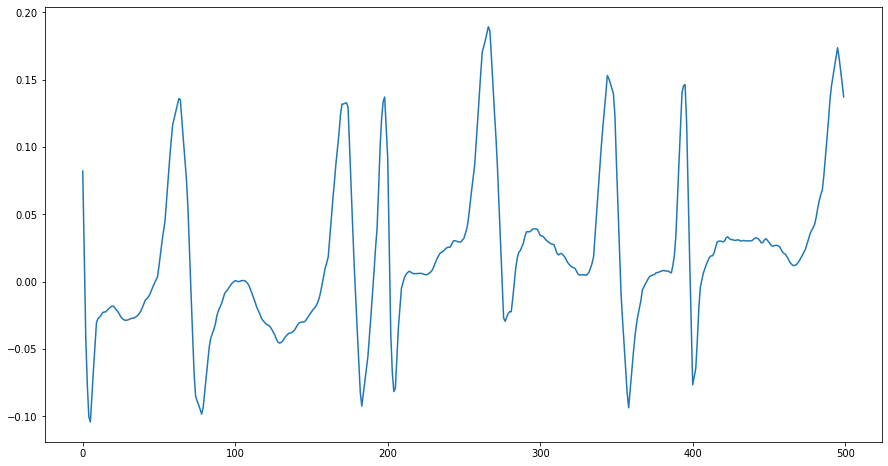

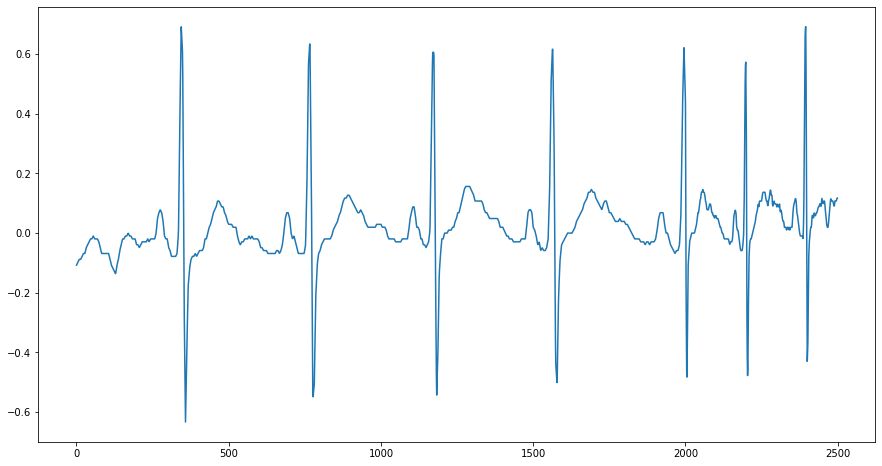

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
#plt.plot(np.array([mean_wave_ecg for i in range(5)]).flatten())
plt.plot(mean_wave_ecg)
plt.figure(figsize=(15,8))
plt.plot(norm_seg_ecg.flatten())

In [106]:
for a,b,c in ([1,3],[1,2],[1,2]):
    print(a,b,c)

ValueError: not enough values to unpack (expected 3, got 2)

# Generate Input

## Input 1

### Input 1-1 (10s / 2min / 5s)

- input 10s, NRS til 2min, 5s 겹침 -> NRS 당 23개 inupt

#### PACU

In [9]:
import numpy as np
import pandas as pd
import os
import pickle
import sys

# settings
SRATE = 100 # 100Hz
LEN_INPUT = 10 # input 길이는 10초

# training set 로딩
input_path = 'dataset/input1/'


if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    df_preprocess_pacu = pickle.load(open('cache/input1/df_preprocess_pacu_final','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data loading
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()

        # 한 NRS에 대해 23개의 input 확인
        for i in range(23):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                switch = 1
                start_idx = i*5*SRATE # 500i
                end_idx = (i*5 + LEN_INPUT)*SRATE # 500i + 1000

                # 해당 input의 vital data
                df_vital_input = df_vital.loc[start_idx:end_idx-1]

                # input 길이를 똑같에 맞춰주기 위한 작업
                pleth_inp, ecg_inp = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]

                # input의 normalization
                pleth_inp[0:df_vital_input['Pleth'].size] = df_vital_input['Pleth'].tolist()
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp[0:df_vital_input['ECG'].size] = (df_vital_input['ECG'].tolist())
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)

                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)

        
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    print('done', flush=True)

print('size of training set(pacu):', len(x_train_pacu))
print('size of test set(pacu):', len(x_test_pacu))

size of training set(pacu): 137516
size of test set(pacu): 15140


#### Preop

In [11]:
import numpy as np
import pandas as pd
import os
import pickle
import sys

# settings
SRATE = 100 # 100Hz
LEN_INPUT = 10 # input 길이는 10초

# training set 로딩
input_path = 'dataset/input1/'

if os.path.exists(input_path+'x_train_preop.npz'):
    print(input_path+'loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/df_preprocess_preop_final','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data loading
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()

        # 한 NRS에 대해 23개의 input 확인
        for i in range(23):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                switch = 1
                start_idx = i*5*SRATE # 500i
                end_idx = (i*5 + LEN_INPUT)*SRATE # 500i + 1000

                # 해당 input의 vital data
                df_vital_input = df_vital.loc[start_idx:end_idx-1]

                # input 길이를 똑같에 맞춰주기 위한 작업
                pleth_inp, ecg_inp = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]

                # input의 normalization
                pleth_inp[0:df_vital_input['Pleth'].size] = df_vital_input['Pleth'].tolist()
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp[0:df_vital_input['ECG'].size] = (df_vital_input['ECG'].tolist())
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_preop.append([pleth_inp, ecg_inp])
                    y_test_preop.append(0)

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_preop.append([pleth_inp, ecg_inp])
                    y_train_preop.append(0)
        print('completed')

    # np
    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
        
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    print('done', flush=True)

print('size of training set(preop):', len(x_train_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/2637 ...completed
loading data 2/2637 ...completed
loading data 3/2637 ...completed
loading data 4/2637 ...completed
loading data 5/2637 ...completed
loading data 6/2637 ...completed
loading data 7/2637 ...completed
loading data 8/2637 ...completed
loading data 9/2637 ...completed
loading data 10/2637 ...completed
loading data 11/2637 ...completed
loading data 12/2637 ...completed
loading data 13/2637 ...completed
loading data 14/2637 ...completed
loading data 15/2637 ...completed
loading data 16/2637 ...completed
loading data 17/2637 ...completed
loading data 18/2637 ...completed
loading data 19/2637 ...completed
loading data 20/2637 ...completed
loading data 21/2637 ...completed
loading data 22/2637 ...completed
loading data 23/2637 ...completed
loading data 24/2637 ...completed
loading data 25/2637 ...completed
loading data 26/2637 ...completed
loading data 27/2637 ...completed
loading data 28/2637 ...completed
loading data 29/2637 ...completed
loading data 30/2637 ..

loading data 239/2637 ...completed
loading data 240/2637 ...completed
loading data 241/2637 ...completed
loading data 242/2637 ...completed
loading data 243/2637 ...completed
loading data 244/2637 ...completed
loading data 245/2637 ...completed
loading data 246/2637 ...completed
loading data 247/2637 ...completed
loading data 248/2637 ...completed
loading data 249/2637 ...completed
loading data 250/2637 ...completed
loading data 251/2637 ...completed
loading data 252/2637 ...completed
loading data 253/2637 ...completed
loading data 254/2637 ...completed
loading data 255/2637 ...completed
loading data 256/2637 ...completed
loading data 257/2637 ...completed
loading data 258/2637 ...completed
loading data 259/2637 ...completed
loading data 260/2637 ...completed
loading data 261/2637 ...completed
loading data 262/2637 ...completed
loading data 263/2637 ...completed
loading data 264/2637 ...completed
loading data 265/2637 ...completed
loading data 266/2637 ...completed
loading data 267/263

loading data 474/2637 ...completed
loading data 475/2637 ...completed
loading data 476/2637 ...completed
loading data 477/2637 ...completed
loading data 478/2637 ...completed
loading data 479/2637 ...completed
loading data 480/2637 ...completed
loading data 481/2637 ...completed
loading data 482/2637 ...completed
loading data 483/2637 ...completed
loading data 484/2637 ...completed
loading data 485/2637 ...completed
loading data 486/2637 ...completed
loading data 487/2637 ...completed
loading data 488/2637 ...completed
loading data 489/2637 ...completed
loading data 490/2637 ...completed
loading data 491/2637 ...completed
loading data 492/2637 ...completed
loading data 493/2637 ...completed
loading data 494/2637 ...completed
loading data 495/2637 ...completed
loading data 496/2637 ...completed
loading data 497/2637 ...completed
loading data 498/2637 ...completed
loading data 499/2637 ...completed
loading data 500/2637 ...completed
loading data 501/2637 ...completed
loading data 502/263

loading data 712/2637 ...completed
loading data 713/2637 ...completed
loading data 714/2637 ...completed
loading data 715/2637 ...completed
loading data 716/2637 ...completed
loading data 717/2637 ...completed
loading data 718/2637 ...completed
loading data 719/2637 ...completed
loading data 720/2637 ...completed
loading data 721/2637 ...completed
loading data 722/2637 ...completed
loading data 723/2637 ...completed
loading data 724/2637 ...completed
loading data 725/2637 ...completed
loading data 726/2637 ...completed
loading data 727/2637 ...completed
loading data 728/2637 ...completed
loading data 729/2637 ...completed
loading data 730/2637 ...completed
loading data 731/2637 ...completed
loading data 732/2637 ...completed
loading data 733/2637 ...completed
loading data 734/2637 ...completed
loading data 735/2637 ...completed
loading data 736/2637 ...completed
loading data 737/2637 ...completed
loading data 738/2637 ...completed
loading data 739/2637 ...completed
loading data 740/263

loading data 947/2637 ...completed
loading data 948/2637 ...completed
loading data 949/2637 ...completed
loading data 950/2637 ...completed
loading data 951/2637 ...completed
loading data 952/2637 ...completed
loading data 953/2637 ...completed
loading data 954/2637 ...completed
loading data 955/2637 ...completed
loading data 956/2637 ...completed
loading data 957/2637 ...completed
loading data 958/2637 ...completed
loading data 959/2637 ...completed
loading data 960/2637 ...completed
loading data 961/2637 ...completed
loading data 962/2637 ...completed
loading data 963/2637 ...completed
loading data 964/2637 ...completed
loading data 965/2637 ...completed
loading data 966/2637 ...completed
loading data 967/2637 ...completed
loading data 968/2637 ...completed
loading data 969/2637 ...completed
loading data 970/2637 ...completed
loading data 971/2637 ...completed
loading data 972/2637 ...completed
loading data 973/2637 ...completed
loading data 974/2637 ...completed
loading data 975/263

loading data 1183/2637 ...completed
loading data 1184/2637 ...completed
loading data 1185/2637 ...completed
loading data 1186/2637 ...completed
loading data 1187/2637 ...completed
loading data 1188/2637 ...completed
loading data 1189/2637 ...completed
loading data 1190/2637 ...completed
loading data 1191/2637 ...completed
loading data 1192/2637 ...completed
loading data 1193/2637 ...completed
loading data 1194/2637 ...completed
loading data 1195/2637 ...completed
loading data 1196/2637 ...completed
loading data 1197/2637 ...completed
loading data 1198/2637 ...completed
loading data 1199/2637 ...completed
loading data 1200/2637 ...completed
loading data 1201/2637 ...completed
loading data 1202/2637 ...completed
loading data 1203/2637 ...completed
loading data 1204/2637 ...completed
loading data 1205/2637 ...completed
loading data 1206/2637 ...completed
loading data 1207/2637 ...completed
loading data 1208/2637 ...completed
loading data 1209/2637 ...completed
loading data 1210/2637 ...co

loading data 1412/2637 ...completed
loading data 1413/2637 ...completed
loading data 1414/2637 ...completed
loading data 1415/2637 ...completed
loading data 1416/2637 ...completed
loading data 1417/2637 ...completed
loading data 1418/2637 ...completed
loading data 1419/2637 ...completed
loading data 1420/2637 ...completed
loading data 1421/2637 ...completed
loading data 1422/2637 ...completed
loading data 1423/2637 ...completed
loading data 1424/2637 ...completed
loading data 1425/2637 ...completed
loading data 1426/2637 ...completed
loading data 1427/2637 ...completed
loading data 1428/2637 ...completed
loading data 1429/2637 ...completed
loading data 1430/2637 ...completed
loading data 1431/2637 ...completed
loading data 1432/2637 ...completed
loading data 1433/2637 ...completed
loading data 1434/2637 ...completed
loading data 1435/2637 ...completed
loading data 1436/2637 ...completed
loading data 1437/2637 ...completed
loading data 1438/2637 ...completed
loading data 1439/2637 ...co

loading data 1870/2637 ...completed
loading data 1871/2637 ...completed
loading data 1872/2637 ...completed
loading data 1873/2637 ...completed
loading data 1874/2637 ...completed
loading data 1875/2637 ...completed
loading data 1876/2637 ...completed
loading data 1877/2637 ...completed
loading data 1878/2637 ...completed
loading data 1879/2637 ...completed
loading data 1880/2637 ...completed
loading data 1881/2637 ...completed
loading data 1882/2637 ...completed
loading data 1883/2637 ...completed
loading data 1884/2637 ...completed
loading data 1885/2637 ...completed
loading data 1886/2637 ...completed
loading data 1887/2637 ...completed
loading data 1888/2637 ...completed
loading data 1889/2637 ...completed
loading data 1890/2637 ...completed
loading data 1891/2637 ...completed
loading data 1892/2637 ...completed
loading data 1893/2637 ...completed
loading data 1894/2637 ...completed
loading data 1895/2637 ...completed
loading data 1896/2637 ...completed
loading data 1897/2637 ...co

loading data 2326/2637 ...completed
loading data 2327/2637 ...completed
loading data 2328/2637 ...completed
loading data 2329/2637 ...completed
loading data 2330/2637 ...completed
loading data 2331/2637 ...completed
loading data 2332/2637 ...completed
loading data 2333/2637 ...completed
loading data 2334/2637 ...completed
loading data 2335/2637 ...completed
loading data 2336/2637 ...completed
loading data 2337/2637 ...completed
loading data 2338/2637 ...completed
loading data 2339/2637 ...completed
loading data 2340/2637 ...completed
loading data 2341/2637 ...completed
loading data 2342/2637 ...completed
loading data 2343/2637 ...completed
loading data 2344/2637 ...completed
loading data 2345/2637 ...completed
loading data 2346/2637 ...completed
loading data 2347/2637 ...completed
loading data 2348/2637 ...completed
loading data 2349/2637 ...completed
loading data 2350/2637 ...completed
loading data 2351/2637 ...completed
loading data 2352/2637 ...completed
loading data 2353/2637 ...co

loading data 2559/2637 ...completed
loading data 2560/2637 ...completed
loading data 2561/2637 ...completed
loading data 2562/2637 ...completed
loading data 2563/2637 ...completed
loading data 2564/2637 ...completed
loading data 2565/2637 ...completed
loading data 2566/2637 ...completed
loading data 2567/2637 ...completed
loading data 2568/2637 ...completed
loading data 2569/2637 ...completed
loading data 2570/2637 ...completed
loading data 2571/2637 ...completed
loading data 2572/2637 ...completed
loading data 2573/2637 ...completed
loading data 2574/2637 ...completed
loading data 2575/2637 ...completed
loading data 2576/2637 ...completed
loading data 2577/2637 ...completed
loading data 2578/2637 ...completed
loading data 2579/2637 ...completed
loading data 2580/2637 ...completed
loading data 2581/2637 ...completed
loading data 2582/2637 ...completed
loading data 2583/2637 ...completed
loading data 2584/2637 ...completed
loading data 2585/2637 ...completed
loading data 2586/2637 ...co

#### pacu + preop

In [13]:
input_path = 'dataset/input1/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)

# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


# filling nan
x_train[:,:,0] = pd.DataFrame(x_train[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_train[:,:,1] = pd.DataFrame(x_train[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

print('train {} ({} events {:.1f}%), test {}'.format(len(y_train), sum(y_train), 100*np.mean(y_train), len(x_test)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (137516, 2, 1000)
x_test_pacu shape: (15140, 2, 1000)
loading preop data...done
x_train_preop shape: (36083, 2, 1000)
x_test_preop shape: (3888, 2, 1000)
x_train shape: (173599, 1000, 2)
x_test shape: (19028, 1000, 2)
train 173599 (700314 events 403.4%), test 19028
saving...done


### Input 1-2 (10s / 1min / 5s)
- NRS 1개당 11개 ( 전처리 1-23에서 13-23에 해당)

#### PACU

In [5]:
import numpy as np
import pandas as pd
import os
import pickle
import sys

# settings
SRATE = 100 # 100Hz
LEN_INPUT = 10 # input 길이는 10초

# training set 로딩
input_path = 'dataset/input1-2/'


if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    df_preprocess_pacu = pickle.load(open('cache/input1/df_preprocess_pacu_final','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data loading
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()

        # 한 NRS에 대해 11개의 input 확인
        for i in range(12,23):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                switch = 1
                start_idx = i*5*SRATE # 500i
                end_idx = (i*5 + LEN_INPUT)*SRATE # 500i + 1000

                # 해당 input의 vital data
                df_vital_input = df_vital.loc[start_idx:end_idx-1]

                # input 길이를 똑같에 맞춰주기 위한 작업
                pleth_inp, ecg_inp = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]

                # input의 normalization
                pleth_inp[0:df_vital_input['Pleth'].size] = df_vital_input['Pleth'].tolist()
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp[0:df_vital_input['ECG'].size] = (df_vital_input['ECG'].tolist())
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)

                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)

        
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    print('done', flush=True)

print('size of training set(pacu):', len(x_train_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/7939 ...completed
loading data 2/7939 ...completed
loading data 3/7939 ...completed
loading data 4/7939 ...completed
loading data 5/7939 ...completed
loading data 6/7939 ...completed
loading data 7/7939 ...completed
loading data 8/7939 ...completed
loading data 9/7939 ...completed
loading data 10/7939 ...completed
loading data 11/7939 ...completed
loading data 12/7939 ...completed
loading data 13/7939 ...completed
loading data 14/7939 ...completed
loading data 15/7939 ...completed
loading data 16/7939 ...completed
loading data 17/7939 ...completed
loading data 18/7939 ...completed
loading data 19/7939 ...completed
loading data 20/7939 ...completed
loading data 21/7939 ...completed
loading data 22/7939 ...completed
loading data 23/7939 ...completed
loading data 24/7939 ...completed
loading data 25/7939 ...completed
loading data 26/7939 ...completed
loading data 27/7939 ...completed
loading data 28/7939 ...completed
loading data 29/7939 ...completed
loading data 30/7939 ..

loading data 242/7939 ...completed
loading data 243/7939 ...completed
loading data 244/7939 ...completed
loading data 245/7939 ...completed
loading data 246/7939 ...completed
loading data 247/7939 ...completed
loading data 248/7939 ...completed
loading data 249/7939 ...completed
loading data 250/7939 ...completed
loading data 251/7939 ...completed
loading data 252/7939 ...completed
loading data 253/7939 ...completed
loading data 254/7939 ...completed
loading data 255/7939 ...completed
loading data 256/7939 ...completed
loading data 257/7939 ...completed
loading data 258/7939 ...completed
loading data 259/7939 ...completed
loading data 260/7939 ...completed
loading data 261/7939 ...completed
loading data 262/7939 ...completed
loading data 263/7939 ...completed
loading data 264/7939 ...completed
loading data 265/7939 ...completed
loading data 266/7939 ...completed
loading data 267/7939 ...completed
loading data 268/7939 ...completed
loading data 269/7939 ...completed
loading data 270/793

loading data 485/7939 ...completed
loading data 486/7939 ...completed
loading data 487/7939 ...completed
loading data 488/7939 ...completed
loading data 489/7939 ...completed
loading data 490/7939 ...completed
loading data 491/7939 ...completed
loading data 492/7939 ...completed
loading data 493/7939 ...completed
loading data 494/7939 ...completed
loading data 495/7939 ...completed
loading data 496/7939 ...completed
loading data 497/7939 ...completed
loading data 498/7939 ...completed
loading data 499/7939 ...completed
loading data 500/7939 ...completed
loading data 501/7939 ...completed
loading data 502/7939 ...completed
loading data 503/7939 ...completed
loading data 504/7939 ...completed
loading data 505/7939 ...completed
loading data 506/7939 ...completed
loading data 507/7939 ...completed
loading data 508/7939 ...completed
loading data 509/7939 ...completed
loading data 510/7939 ...completed
loading data 511/7939 ...completed
loading data 512/7939 ...completed
loading data 513/793

loading data 720/7939 ...completed
loading data 721/7939 ...completed
loading data 722/7939 ...completed
loading data 723/7939 ...completed
loading data 724/7939 ...completed
loading data 725/7939 ...completed
loading data 726/7939 ...completed
loading data 727/7939 ...completed
loading data 728/7939 ...completed
loading data 729/7939 ...completed
loading data 730/7939 ...completed
loading data 731/7939 ...completed
loading data 732/7939 ...completed
loading data 733/7939 ...completed
loading data 734/7939 ...completed
loading data 735/7939 ...completed
loading data 736/7939 ...completed
loading data 737/7939 ...completed
loading data 738/7939 ...completed
loading data 739/7939 ...completed
loading data 740/7939 ...completed
loading data 741/7939 ...completed
loading data 742/7939 ...completed
loading data 743/7939 ...completed
loading data 744/7939 ...completed
loading data 745/7939 ...completed
loading data 746/7939 ...completed
loading data 747/7939 ...completed
loading data 748/793

loading data 957/7939 ...completed
loading data 958/7939 ...completed
loading data 959/7939 ...completed
loading data 960/7939 ...completed
loading data 961/7939 ...completed
loading data 962/7939 ...completed
loading data 963/7939 ...completed
loading data 964/7939 ...completed
loading data 965/7939 ...completed
loading data 966/7939 ...completed
loading data 967/7939 ...completed
loading data 968/7939 ...completed
loading data 969/7939 ...completed
loading data 970/7939 ...completed
loading data 971/7939 ...completed
loading data 972/7939 ...completed
loading data 973/7939 ...completed
loading data 974/7939 ...completed
loading data 975/7939 ...completed
loading data 976/7939 ...completed
loading data 977/7939 ...completed
loading data 978/7939 ...completed
loading data 979/7939 ...completed
loading data 980/7939 ...completed
loading data 981/7939 ...completed
loading data 982/7939 ...completed
loading data 983/7939 ...completed
loading data 984/7939 ...completed
loading data 985/793

loading data 1190/7939 ...completed
loading data 1191/7939 ...completed
loading data 1192/7939 ...completed
loading data 1193/7939 ...completed
loading data 1194/7939 ...completed
loading data 1195/7939 ...completed
loading data 1196/7939 ...completed
loading data 1197/7939 ...completed
loading data 1198/7939 ...completed
loading data 1199/7939 ...completed
loading data 1200/7939 ...completed
loading data 1201/7939 ...completed
loading data 1202/7939 ...completed
loading data 1203/7939 ...completed
loading data 1204/7939 ...completed
loading data 1205/7939 ...completed
loading data 1206/7939 ...completed
loading data 1207/7939 ...completed
loading data 1208/7939 ...completed
loading data 1209/7939 ...completed
loading data 1210/7939 ...completed
loading data 1211/7939 ...completed
loading data 1212/7939 ...completed
loading data 1213/7939 ...completed
loading data 1214/7939 ...completed
loading data 1215/7939 ...completed
loading data 1216/7939 ...completed
loading data 1217/7939 ...co

loading data 1656/7939 ...completed
loading data 1657/7939 ...completed
loading data 1658/7939 ...completed
loading data 1659/7939 ...completed
loading data 1660/7939 ...completed
loading data 1661/7939 ...completed
loading data 1662/7939 ...completed
loading data 1663/7939 ...completed
loading data 1664/7939 ...completed
loading data 1665/7939 ...completed
loading data 1666/7939 ...completed
loading data 1667/7939 ...completed
loading data 1668/7939 ...completed
loading data 1669/7939 ...completed
loading data 1670/7939 ...completed
loading data 1671/7939 ...completed
loading data 1672/7939 ...completed
loading data 1673/7939 ...completed
loading data 1674/7939 ...completed
loading data 1675/7939 ...completed
loading data 1676/7939 ...completed
loading data 1677/7939 ...completed
loading data 1678/7939 ...completed
loading data 1679/7939 ...completed
loading data 1680/7939 ...completed
loading data 1681/7939 ...completed
loading data 1682/7939 ...completed
loading data 1683/7939 ...co

loading data 1891/7939 ...completed
loading data 1892/7939 ...completed
loading data 1893/7939 ...completed
loading data 1894/7939 ...completed
loading data 1895/7939 ...completed
loading data 1896/7939 ...completed
loading data 1897/7939 ...completed
loading data 1898/7939 ...completed
loading data 1899/7939 ...completed
loading data 1900/7939 ...completed
loading data 1901/7939 ...completed
loading data 1902/7939 ...completed
loading data 1903/7939 ...completed
loading data 1904/7939 ...completed
loading data 1905/7939 ...completed
loading data 1906/7939 ...completed
loading data 1907/7939 ...completed
loading data 1908/7939 ...completed
loading data 1909/7939 ...completed
loading data 1910/7939 ...completed
loading data 1911/7939 ...completed
loading data 1912/7939 ...completed
loading data 1913/7939 ...completed
loading data 1914/7939 ...completed
loading data 1915/7939 ...completed
loading data 1916/7939 ...completed
loading data 1917/7939 ...completed
loading data 1918/7939 ...co

loading data 2124/7939 ...completed
loading data 2125/7939 ...completed
loading data 2126/7939 ...completed
loading data 2127/7939 ...completed
loading data 2128/7939 ...completed
loading data 2129/7939 ...completed
loading data 2130/7939 ...completed
loading data 2131/7939 ...completed
loading data 2132/7939 ...completed
loading data 2133/7939 ...completed
loading data 2134/7939 ...completed
loading data 2135/7939 ...completed
loading data 2136/7939 ...completed
loading data 2137/7939 ...completed
loading data 2138/7939 ...completed
loading data 2139/7939 ...completed
loading data 2140/7939 ...completed
loading data 2141/7939 ...completed
loading data 2142/7939 ...completed
loading data 2143/7939 ...completed
loading data 2144/7939 ...completed
loading data 2145/7939 ...completed
loading data 2146/7939 ...completed
loading data 2147/7939 ...completed
loading data 2148/7939 ...completed
loading data 2149/7939 ...completed
loading data 2150/7939 ...completed
loading data 2151/7939 ...co

loading data 2352/7939 ...completed
loading data 2353/7939 ...completed
loading data 2354/7939 ...completed
loading data 2355/7939 ...completed
loading data 2356/7939 ...completed
loading data 2357/7939 ...completed
loading data 2358/7939 ...completed
loading data 2359/7939 ...completed
loading data 2360/7939 ...completed
loading data 2361/7939 ...completed
loading data 2362/7939 ...completed
loading data 2363/7939 ...completed
loading data 2364/7939 ...completed
loading data 2365/7939 ...completed
loading data 2366/7939 ...completed
loading data 2367/7939 ...completed
loading data 2368/7939 ...completed
loading data 2369/7939 ...completed
loading data 2370/7939 ...completed
loading data 2371/7939 ...completed
loading data 2372/7939 ...completed
loading data 2373/7939 ...completed
loading data 2374/7939 ...completed
loading data 2375/7939 ...completed
loading data 2376/7939 ...completed
loading data 2377/7939 ...completed
loading data 2378/7939 ...completed
loading data 2379/7939 ...co

loading data 2590/7939 ...completed
loading data 2591/7939 ...completed
loading data 2592/7939 ...completed
loading data 2593/7939 ...completed
loading data 2594/7939 ...completed
loading data 2595/7939 ...completed
loading data 2596/7939 ...completed
loading data 2597/7939 ...completed
loading data 2598/7939 ...completed
loading data 2599/7939 ...completed
loading data 2600/7939 ...completed
loading data 2601/7939 ...completed
loading data 2602/7939 ...completed
loading data 2603/7939 ...completed
loading data 2604/7939 ...completed
loading data 2605/7939 ...completed
loading data 2606/7939 ...completed
loading data 2607/7939 ...completed
loading data 2608/7939 ...completed
loading data 2609/7939 ...completed
loading data 2610/7939 ...completed
loading data 2611/7939 ...completed
loading data 2612/7939 ...completed
loading data 2613/7939 ...completed
loading data 2614/7939 ...completed
loading data 2615/7939 ...completed
loading data 2616/7939 ...completed
loading data 2617/7939 ...co

loading data 2819/7939 ...completed
loading data 2820/7939 ...completed
loading data 2821/7939 ...completed
loading data 2822/7939 ...completed
loading data 2823/7939 ...completed
loading data 2824/7939 ...completed
loading data 2825/7939 ...completed
loading data 2826/7939 ...completed
loading data 2827/7939 ...completed
loading data 2828/7939 ...completed
loading data 2829/7939 ...completed
loading data 2830/7939 ...completed
loading data 2831/7939 ...completed
loading data 2832/7939 ...completed
loading data 2833/7939 ...completed
loading data 2834/7939 ...completed
loading data 2835/7939 ...completed
loading data 2836/7939 ...completed
loading data 2837/7939 ...completed
loading data 2838/7939 ...completed
loading data 2839/7939 ...completed
loading data 2840/7939 ...completed
loading data 2841/7939 ...completed
loading data 2842/7939 ...completed
loading data 2843/7939 ...completed
loading data 2844/7939 ...completed
loading data 2845/7939 ...completed
loading data 2846/7939 ...co

loading data 3047/7939 ...completed
loading data 3048/7939 ...completed
loading data 3049/7939 ...completed
loading data 3050/7939 ...completed
loading data 3051/7939 ...completed
loading data 3052/7939 ...completed
loading data 3053/7939 ...completed
loading data 3054/7939 ...completed
loading data 3055/7939 ...completed
loading data 3056/7939 ...completed
loading data 3057/7939 ...completed
loading data 3058/7939 ...completed
loading data 3059/7939 ...completed
loading data 3060/7939 ...completed
loading data 3061/7939 ...completed
loading data 3062/7939 ...completed
loading data 3063/7939 ...completed
loading data 3064/7939 ...completed
loading data 3065/7939 ...completed
loading data 3066/7939 ...completed
loading data 3067/7939 ...completed
loading data 3068/7939 ...completed
loading data 3069/7939 ...completed
loading data 3070/7939 ...completed
loading data 3071/7939 ...completed
loading data 3072/7939 ...completed
loading data 3073/7939 ...completed
loading data 3074/7939 ...co

loading data 3285/7939 ...completed
loading data 3286/7939 ...completed
loading data 3287/7939 ...completed
loading data 3288/7939 ...completed
loading data 3289/7939 ...completed
loading data 3290/7939 ...completed
loading data 3291/7939 ...completed
loading data 3292/7939 ...completed
loading data 3293/7939 ...completed
loading data 3294/7939 ...completed
loading data 3295/7939 ...completed
loading data 3296/7939 ...completed
loading data 3297/7939 ...completed
loading data 3298/7939 ...completed
loading data 3299/7939 ...completed
loading data 3300/7939 ...completed
loading data 3301/7939 ...completed
loading data 3302/7939 ...completed
loading data 3303/7939 ...completed
loading data 3304/7939 ...completed
loading data 3305/7939 ...completed
loading data 3306/7939 ...completed
loading data 3307/7939 ...completed
loading data 3308/7939 ...completed
loading data 3309/7939 ...completed
loading data 3310/7939 ...completed
loading data 3311/7939 ...completed
loading data 3312/7939 ...co

loading data 3522/7939 ...completed
loading data 3523/7939 ...completed
loading data 3524/7939 ...completed
loading data 3525/7939 ...completed
loading data 3526/7939 ...completed
loading data 3527/7939 ...completed
loading data 3528/7939 ...completed
loading data 3529/7939 ...completed
loading data 3530/7939 ...completed
loading data 3531/7939 ...completed
loading data 3532/7939 ...completed
loading data 3533/7939 ...completed
loading data 3534/7939 ...completed
loading data 3535/7939 ...completed
loading data 3536/7939 ...completed
loading data 3537/7939 ...completed
loading data 3538/7939 ...completed
loading data 3539/7939 ...completed
loading data 3540/7939 ...completed
loading data 3541/7939 ...completed
loading data 3542/7939 ...completed
loading data 3543/7939 ...completed
loading data 3544/7939 ...completed
loading data 3545/7939 ...completed
loading data 3546/7939 ...completed
loading data 3547/7939 ...completed
loading data 3548/7939 ...completed
loading data 3549/7939 ...co

loading data 3761/7939 ...completed
loading data 3762/7939 ...completed
loading data 3763/7939 ...completed
loading data 3764/7939 ...completed
loading data 3765/7939 ...completed
loading data 3766/7939 ...completed
loading data 3767/7939 ...completed
loading data 3768/7939 ...completed
loading data 3769/7939 ...completed
loading data 3770/7939 ...completed
loading data 3771/7939 ...completed
loading data 3772/7939 ...completed
loading data 3773/7939 ...completed
loading data 3774/7939 ...completed
loading data 3775/7939 ...completed
loading data 3776/7939 ...completed
loading data 3777/7939 ...completed
loading data 3778/7939 ...completed
loading data 3779/7939 ...completed
loading data 3780/7939 ...completed
loading data 3781/7939 ...completed
loading data 3782/7939 ...completed
loading data 3783/7939 ...completed
loading data 3784/7939 ...completed
loading data 3785/7939 ...completed
loading data 3786/7939 ...completed
loading data 3787/7939 ...completed
loading data 3788/7939 ...co

loading data 3994/7939 ...completed
loading data 3995/7939 ...completed
loading data 3996/7939 ...completed
loading data 3997/7939 ...completed
loading data 3998/7939 ...completed
loading data 3999/7939 ...completed
loading data 4000/7939 ...completed
loading data 4001/7939 ...completed
loading data 4002/7939 ...completed
loading data 4003/7939 ...completed
loading data 4004/7939 ...completed
loading data 4005/7939 ...completed
loading data 4006/7939 ...completed
loading data 4007/7939 ...completed
loading data 4008/7939 ...completed
loading data 4009/7939 ...completed
loading data 4010/7939 ...completed
loading data 4011/7939 ...completed
loading data 4012/7939 ...completed
loading data 4013/7939 ...completed
loading data 4014/7939 ...completed
loading data 4015/7939 ...completed
loading data 4016/7939 ...completed
loading data 4017/7939 ...completed
loading data 4018/7939 ...completed
loading data 4019/7939 ...completed
loading data 4020/7939 ...completed
loading data 4021/7939 ...co

loading data 4222/7939 ...completed
loading data 4223/7939 ...completed
loading data 4224/7939 ...completed
loading data 4225/7939 ...completed
loading data 4226/7939 ...completed
loading data 4227/7939 ...completed
loading data 4228/7939 ...completed
loading data 4229/7939 ...completed
loading data 4230/7939 ...completed
loading data 4231/7939 ...completed
loading data 4232/7939 ...completed
loading data 4233/7939 ...completed
loading data 4234/7939 ...completed
loading data 4235/7939 ...completed
loading data 4236/7939 ...completed
loading data 4237/7939 ...completed
loading data 4238/7939 ...completed
loading data 4239/7939 ...completed
loading data 4240/7939 ...completed
loading data 4241/7939 ...completed
loading data 4242/7939 ...completed
loading data 4243/7939 ...completed
loading data 4244/7939 ...completed
loading data 4245/7939 ...completed
loading data 4246/7939 ...completed
loading data 4247/7939 ...completed
loading data 4248/7939 ...completed
loading data 4249/7939 ...co

loading data 4453/7939 ...completed
loading data 4454/7939 ...completed
loading data 4455/7939 ...completed
loading data 4456/7939 ...completed
loading data 4457/7939 ...completed
loading data 4458/7939 ...completed
loading data 4459/7939 ...completed
loading data 4460/7939 ...completed
loading data 4461/7939 ...completed
loading data 4462/7939 ...completed
loading data 4463/7939 ...completed
loading data 4464/7939 ...completed
loading data 4465/7939 ...completed
loading data 4466/7939 ...completed
loading data 4467/7939 ...completed
loading data 4468/7939 ...completed
loading data 4469/7939 ...completed
loading data 4470/7939 ...completed
loading data 4471/7939 ...completed
loading data 4472/7939 ...completed
loading data 4473/7939 ...completed
loading data 4474/7939 ...completed
loading data 4475/7939 ...completed
loading data 4476/7939 ...completed
loading data 4477/7939 ...completed
loading data 4478/7939 ...completed
loading data 4479/7939 ...completed
loading data 4480/7939 ...co

loading data 4683/7939 ...completed
loading data 4684/7939 ...completed
loading data 4685/7939 ...completed
loading data 4686/7939 ...completed
loading data 4687/7939 ...completed
loading data 4688/7939 ...completed
loading data 4689/7939 ...completed
loading data 4690/7939 ...completed
loading data 4691/7939 ...completed
loading data 4692/7939 ...completed
loading data 4693/7939 ...completed
loading data 4694/7939 ...completed
loading data 4695/7939 ...completed
loading data 4696/7939 ...completed
loading data 4697/7939 ...completed
loading data 4698/7939 ...completed
loading data 4699/7939 ...completed
loading data 4700/7939 ...completed
loading data 4701/7939 ...completed
loading data 4702/7939 ...completed
loading data 4703/7939 ...completed
loading data 4704/7939 ...completed
loading data 4705/7939 ...completed
loading data 4706/7939 ...completed
loading data 4707/7939 ...completed
loading data 4708/7939 ...completed
loading data 4709/7939 ...completed
loading data 4710/7939 ...co

loading data 5145/7939 ...completed
loading data 5146/7939 ...completed
loading data 5147/7939 ...completed
loading data 5148/7939 ...completed
loading data 5149/7939 ...completed
loading data 5150/7939 ...completed
loading data 5151/7939 ...completed
loading data 5152/7939 ...completed
loading data 5153/7939 ...completed
loading data 5154/7939 ...completed
loading data 5155/7939 ...completed
loading data 5156/7939 ...completed
loading data 5157/7939 ...completed
loading data 5158/7939 ...completed
loading data 5159/7939 ...completed
loading data 5160/7939 ...completed
loading data 5161/7939 ...completed
loading data 5162/7939 ...completed
loading data 5163/7939 ...completed
loading data 5164/7939 ...completed
loading data 5165/7939 ...completed
loading data 5166/7939 ...completed
loading data 5167/7939 ...completed
loading data 5168/7939 ...completed
loading data 5169/7939 ...completed
loading data 5170/7939 ...completed
loading data 5171/7939 ...completed
loading data 5172/7939 ...co

loading data 5383/7939 ...completed
loading data 5384/7939 ...completed
loading data 5385/7939 ...completed
loading data 5386/7939 ...completed
loading data 5387/7939 ...completed
loading data 5388/7939 ...completed
loading data 5389/7939 ...completed
loading data 5390/7939 ...completed
loading data 5391/7939 ...completed
loading data 5392/7939 ...completed
loading data 5393/7939 ...completed
loading data 5394/7939 ...completed
loading data 5395/7939 ...completed
loading data 5396/7939 ...completed
loading data 5397/7939 ...completed
loading data 5398/7939 ...completed
loading data 5399/7939 ...completed
loading data 5400/7939 ...completed
loading data 5401/7939 ...completed
loading data 5402/7939 ...completed
loading data 5403/7939 ...completed
loading data 5404/7939 ...completed
loading data 5405/7939 ...completed
loading data 5406/7939 ...completed
loading data 5407/7939 ...completed
loading data 5408/7939 ...completed
loading data 5409/7939 ...completed
loading data 5410/7939 ...co

loading data 5623/7939 ...completed
loading data 5624/7939 ...completed
loading data 5625/7939 ...completed
loading data 5626/7939 ...completed
loading data 5627/7939 ...completed
loading data 5628/7939 ...completed
loading data 5629/7939 ...completed
loading data 5630/7939 ...completed
loading data 5631/7939 ...completed
loading data 5632/7939 ...completed
loading data 5633/7939 ...completed
loading data 5634/7939 ...completed
loading data 5635/7939 ...completed
loading data 5636/7939 ...completed
loading data 5637/7939 ...completed
loading data 5638/7939 ...completed
loading data 5639/7939 ...completed
loading data 5640/7939 ...completed
loading data 5641/7939 ...completed
loading data 5642/7939 ...completed
loading data 5643/7939 ...completed
loading data 5644/7939 ...completed
loading data 5645/7939 ...completed
loading data 5646/7939 ...completed
loading data 5647/7939 ...completed
loading data 5648/7939 ...completed
loading data 5649/7939 ...completed
loading data 5650/7939 ...co

loading data 5855/7939 ...completed
loading data 5856/7939 ...completed
loading data 5857/7939 ...completed
loading data 5858/7939 ...completed
loading data 5859/7939 ...completed
loading data 5860/7939 ...completed
loading data 5861/7939 ...completed
loading data 5862/7939 ...completed
loading data 5863/7939 ...completed
loading data 5864/7939 ...completed
loading data 5865/7939 ...completed
loading data 5866/7939 ...completed
loading data 5867/7939 ...completed
loading data 5868/7939 ...completed
loading data 5869/7939 ...completed
loading data 5870/7939 ...completed
loading data 5871/7939 ...completed
loading data 5872/7939 ...completed
loading data 5873/7939 ...completed
loading data 5874/7939 ...completed
loading data 5875/7939 ...completed
loading data 5876/7939 ...completed
loading data 5877/7939 ...completed
loading data 5878/7939 ...completed
loading data 5879/7939 ...completed
loading data 5880/7939 ...completed
loading data 5881/7939 ...completed
loading data 5882/7939 ...co

loading data 6091/7939 ...completed
loading data 6092/7939 ...completed
loading data 6093/7939 ...completed
loading data 6094/7939 ...completed
loading data 6095/7939 ...completed
loading data 6096/7939 ...completed
loading data 6097/7939 ...completed
loading data 6098/7939 ...completed
loading data 6099/7939 ...completed
loading data 6100/7939 ...completed
loading data 6101/7939 ...completed
loading data 6102/7939 ...completed
loading data 6103/7939 ...completed
loading data 6104/7939 ...completed
loading data 6105/7939 ...completed
loading data 6106/7939 ...completed
loading data 6107/7939 ...completed
loading data 6108/7939 ...completed
loading data 6109/7939 ...completed
loading data 6110/7939 ...completed
loading data 6111/7939 ...completed
loading data 6112/7939 ...completed
loading data 6113/7939 ...completed
loading data 6114/7939 ...completed
loading data 6115/7939 ...completed
loading data 6116/7939 ...completed
loading data 6117/7939 ...completed
loading data 6118/7939 ...co

loading data 6319/7939 ...completed
loading data 6320/7939 ...completed
loading data 6321/7939 ...completed
loading data 6322/7939 ...completed
loading data 6323/7939 ...completed
loading data 6324/7939 ...completed
loading data 6325/7939 ...completed
loading data 6326/7939 ...completed
loading data 6327/7939 ...completed
loading data 6328/7939 ...completed
loading data 6329/7939 ...completed
loading data 6330/7939 ...completed
loading data 6331/7939 ...completed
loading data 6332/7939 ...completed
loading data 6333/7939 ...completed
loading data 6334/7939 ...completed
loading data 6335/7939 ...completed
loading data 6336/7939 ...completed
loading data 6337/7939 ...completed
loading data 6338/7939 ...completed
loading data 6339/7939 ...completed
loading data 6340/7939 ...completed
loading data 6341/7939 ...completed
loading data 6342/7939 ...completed
loading data 6343/7939 ...completed
loading data 6344/7939 ...completed
loading data 6345/7939 ...completed
loading data 6346/7939 ...co

loading data 6777/7939 ...completed
loading data 6778/7939 ...completed
loading data 6779/7939 ...completed
loading data 6780/7939 ...completed
loading data 6781/7939 ...completed
loading data 6782/7939 ...completed
loading data 6783/7939 ...completed
loading data 6784/7939 ...completed
loading data 6785/7939 ...completed
loading data 6786/7939 ...completed
loading data 6787/7939 ...completed
loading data 6788/7939 ...completed
loading data 6789/7939 ...completed
loading data 6790/7939 ...completed
loading data 6791/7939 ...completed
loading data 6792/7939 ...completed
loading data 6793/7939 ...completed
loading data 6794/7939 ...completed
loading data 6795/7939 ...completed
loading data 6796/7939 ...completed
loading data 6797/7939 ...completed
loading data 6798/7939 ...completed
loading data 6799/7939 ...completed
loading data 6800/7939 ...completed
loading data 6801/7939 ...completed
loading data 6802/7939 ...completed
loading data 6803/7939 ...completed
loading data 6804/7939 ...co

loading data 7009/7939 ...completed
loading data 7010/7939 ...completed
loading data 7011/7939 ...completed
loading data 7012/7939 ...completed
loading data 7013/7939 ...completed
loading data 7014/7939 ...completed
loading data 7015/7939 ...completed
loading data 7016/7939 ...completed
loading data 7017/7939 ...completed
loading data 7018/7939 ...completed
loading data 7019/7939 ...completed
loading data 7020/7939 ...completed
loading data 7021/7939 ...completed
loading data 7022/7939 ...completed
loading data 7023/7939 ...completed
loading data 7024/7939 ...completed
loading data 7025/7939 ...completed
loading data 7026/7939 ...completed
loading data 7027/7939 ...completed
loading data 7028/7939 ...completed
loading data 7029/7939 ...completed
loading data 7030/7939 ...completed
loading data 7031/7939 ...completed
loading data 7032/7939 ...completed
loading data 7033/7939 ...completed
loading data 7034/7939 ...completed
loading data 7035/7939 ...completed
loading data 7036/7939 ...co

loading data 7242/7939 ...completed
loading data 7243/7939 ...completed
loading data 7244/7939 ...completed
loading data 7245/7939 ...completed
loading data 7246/7939 ...completed
loading data 7247/7939 ...completed
loading data 7248/7939 ...completed
loading data 7249/7939 ...completed
loading data 7250/7939 ...completed
loading data 7251/7939 ...completed
loading data 7252/7939 ...completed
loading data 7253/7939 ...completed
loading data 7254/7939 ...completed
loading data 7255/7939 ...completed
loading data 7256/7939 ...completed
loading data 7257/7939 ...completed
loading data 7258/7939 ...completed
loading data 7259/7939 ...completed
loading data 7260/7939 ...completed
loading data 7261/7939 ...completed
loading data 7262/7939 ...completed
loading data 7263/7939 ...completed
loading data 7264/7939 ...completed
loading data 7265/7939 ...completed
loading data 7266/7939 ...completed
loading data 7267/7939 ...completed
loading data 7268/7939 ...completed
loading data 7269/7939 ...co

loading data 7474/7939 ...completed
loading data 7475/7939 ...completed
loading data 7476/7939 ...completed
loading data 7477/7939 ...completed
loading data 7478/7939 ...completed
loading data 7479/7939 ...completed
loading data 7480/7939 ...completed
loading data 7481/7939 ...completed
loading data 7482/7939 ...completed
loading data 7483/7939 ...completed
loading data 7484/7939 ...completed
loading data 7485/7939 ...completed
loading data 7486/7939 ...completed
loading data 7487/7939 ...completed
loading data 7488/7939 ...completed
loading data 7489/7939 ...completed
loading data 7490/7939 ...completed
loading data 7491/7939 ...completed
loading data 7492/7939 ...completed
loading data 7493/7939 ...completed
loading data 7494/7939 ...completed
loading data 7495/7939 ...completed
loading data 7496/7939 ...completed
loading data 7497/7939 ...completed
loading data 7498/7939 ...completed
loading data 7499/7939 ...completed
loading data 7500/7939 ...completed
loading data 7501/7939 ...co

loading data 7711/7939 ...completed
loading data 7712/7939 ...completed
loading data 7713/7939 ...completed
loading data 7714/7939 ...completed
loading data 7715/7939 ...completed
loading data 7716/7939 ...completed
loading data 7717/7939 ...completed
loading data 7718/7939 ...completed
loading data 7719/7939 ...completed
loading data 7720/7939 ...completed
loading data 7721/7939 ...completed
loading data 7722/7939 ...completed
loading data 7723/7939 ...completed
loading data 7724/7939 ...completed
loading data 7725/7939 ...completed
loading data 7726/7939 ...completed
loading data 7727/7939 ...completed
loading data 7728/7939 ...completed
loading data 7729/7939 ...completed
loading data 7730/7939 ...completed
loading data 7731/7939 ...completed
loading data 7732/7939 ...completed
loading data 7733/7939 ...completed
loading data 7734/7939 ...completed
loading data 7735/7939 ...completed
loading data 7736/7939 ...completed
loading data 7737/7939 ...completed
loading data 7738/7939 ...co

saving...done
size of training set(pacu): 65545
size of test set(pacu): 7154


#### Preop

In [7]:
import numpy as np
import pandas as pd
import os
import pickle
import sys

# settings
SRATE = 100 # 100Hz
LEN_INPUT = 10 # input 길이는 10초

# training set 로딩
input_path = 'dataset/input1-2/'

if os.path.exists(input_path+'x_train_preop.npz'):
    print(input_path+'loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/input1/df_preprocess_preop_final','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data loading
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()

        # 한 NRS에 대해 11개의 input 확인
        for i in range(12,23):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                switch = 1
                start_idx = i*5*SRATE # 500i
                end_idx = (i*5 + LEN_INPUT)*SRATE # 500i + 1000

                # 해당 input의 vital data
                df_vital_input = df_vital.loc[start_idx:end_idx-1]

                # input 길이를 똑같에 맞춰주기 위한 작업
                pleth_inp, ecg_inp = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]

                # input의 normalization
                pleth_inp[0:df_vital_input['Pleth'].size] = df_vital_input['Pleth'].tolist()
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp[0:df_vital_input['ECG'].size] = (df_vital_input['ECG'].tolist())
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_preop.append([pleth_inp, ecg_inp])
                    y_test_preop.append(0)

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_preop.append([pleth_inp, ecg_inp])
                    y_train_preop.append(0)
        print('completed')

    # np
    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
        
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    print('done', flush=True)

print('size of training set(preop):', len(x_train_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/2637 ...completed
loading data 2/2637 ...completed
loading data 3/2637 ...completed
loading data 4/2637 ...completed
loading data 5/2637 ...completed
loading data 6/2637 ...completed
loading data 7/2637 ...completed
loading data 8/2637 ...completed
loading data 9/2637 ...completed
loading data 10/2637 ...completed
loading data 11/2637 ...completed
loading data 12/2637 ...completed
loading data 13/2637 ...completed
loading data 14/2637 ...completed
loading data 15/2637 ...completed
loading data 16/2637 ...completed
loading data 17/2637 ...completed
loading data 18/2637 ...completed
loading data 19/2637 ...completed
loading data 20/2637 ...completed
loading data 21/2637 ...completed
loading data 22/2637 ...completed
loading data 23/2637 ...completed
loading data 24/2637 ...completed
loading data 25/2637 ...completed
loading data 26/2637 ...completed
loading data 27/2637 ...completed
loading data 28/2637 ...completed
loading data 29/2637 ...completed
loading data 30/2637 ..

loading data 253/2637 ...completed
loading data 254/2637 ...completed
loading data 255/2637 ...completed
loading data 256/2637 ...completed
loading data 257/2637 ...completed
loading data 258/2637 ...completed
loading data 259/2637 ...completed
loading data 260/2637 ...completed
loading data 261/2637 ...completed
loading data 262/2637 ...completed
loading data 263/2637 ...completed
loading data 264/2637 ...completed
loading data 265/2637 ...completed
loading data 266/2637 ...completed
loading data 267/2637 ...completed
loading data 268/2637 ...completed
loading data 269/2637 ...completed
loading data 270/2637 ...completed
loading data 271/2637 ...completed
loading data 272/2637 ...completed
loading data 273/2637 ...completed
loading data 274/2637 ...completed
loading data 275/2637 ...completed
loading data 276/2637 ...completed
loading data 277/2637 ...completed
loading data 278/2637 ...completed
loading data 279/2637 ...completed
loading data 280/2637 ...completed
loading data 281/263

loading data 496/2637 ...completed
loading data 497/2637 ...completed
loading data 498/2637 ...completed
loading data 499/2637 ...completed
loading data 500/2637 ...completed
loading data 501/2637 ...completed
loading data 502/2637 ...completed
loading data 503/2637 ...completed
loading data 504/2637 ...completed
loading data 505/2637 ...completed
loading data 506/2637 ...completed
loading data 507/2637 ...completed
loading data 508/2637 ...completed
loading data 509/2637 ...completed
loading data 510/2637 ...completed
loading data 511/2637 ...completed
loading data 512/2637 ...completed
loading data 513/2637 ...completed
loading data 514/2637 ...completed
loading data 515/2637 ...completed
loading data 516/2637 ...completed
loading data 517/2637 ...completed
loading data 518/2637 ...completed
loading data 519/2637 ...completed
loading data 520/2637 ...completed
loading data 521/2637 ...completed
loading data 522/2637 ...completed
loading data 523/2637 ...completed
loading data 524/263

loading data 737/2637 ...completed
loading data 738/2637 ...completed
loading data 739/2637 ...completed
loading data 740/2637 ...completed
loading data 741/2637 ...completed
loading data 742/2637 ...completed
loading data 743/2637 ...completed
loading data 744/2637 ...completed
loading data 745/2637 ...completed
loading data 746/2637 ...completed
loading data 747/2637 ...completed
loading data 748/2637 ...completed
loading data 749/2637 ...completed
loading data 750/2637 ...completed
loading data 751/2637 ...completed
loading data 752/2637 ...completed
loading data 753/2637 ...completed
loading data 754/2637 ...completed
loading data 755/2637 ...completed
loading data 756/2637 ...completed
loading data 757/2637 ...completed
loading data 758/2637 ...completed
loading data 759/2637 ...completed
loading data 760/2637 ...completed
loading data 761/2637 ...completed
loading data 762/2637 ...completed
loading data 763/2637 ...completed
loading data 764/2637 ...completed
loading data 765/263

loading data 986/2637 ...completed
loading data 987/2637 ...completed
loading data 988/2637 ...completed
loading data 989/2637 ...completed
loading data 990/2637 ...completed
loading data 991/2637 ...completed
loading data 992/2637 ...completed
loading data 993/2637 ...completed
loading data 994/2637 ...completed
loading data 995/2637 ...completed
loading data 996/2637 ...completed
loading data 997/2637 ...completed
loading data 998/2637 ...completed
loading data 999/2637 ...completed
loading data 1000/2637 ...completed
loading data 1001/2637 ...completed
loading data 1002/2637 ...completed
loading data 1003/2637 ...completed
loading data 1004/2637 ...completed
loading data 1005/2637 ...completed
loading data 1006/2637 ...completed
loading data 1007/2637 ...completed
loading data 1008/2637 ...completed
loading data 1009/2637 ...completed
loading data 1010/2637 ...completed
loading data 1011/2637 ...completed
loading data 1012/2637 ...completed
loading data 1013/2637 ...completed
loadin

loading data 1218/2637 ...completed
loading data 1219/2637 ...completed
loading data 1220/2637 ...completed
loading data 1221/2637 ...completed
loading data 1222/2637 ...completed
loading data 1223/2637 ...completed
loading data 1224/2637 ...completed
loading data 1225/2637 ...completed
loading data 1226/2637 ...completed
loading data 1227/2637 ...completed
loading data 1228/2637 ...completed
loading data 1229/2637 ...completed
loading data 1230/2637 ...completed
loading data 1231/2637 ...completed
loading data 1232/2637 ...completed
loading data 1233/2637 ...completed
loading data 1234/2637 ...completed
loading data 1235/2637 ...completed
loading data 1236/2637 ...completed
loading data 1237/2637 ...completed
loading data 1238/2637 ...completed
loading data 1239/2637 ...completed
loading data 1240/2637 ...completed
loading data 1241/2637 ...completed
loading data 1242/2637 ...completed
loading data 1243/2637 ...completed
loading data 1244/2637 ...completed
loading data 1245/2637 ...co

loading data 1452/2637 ...completed
loading data 1453/2637 ...completed
loading data 1454/2637 ...completed
loading data 1455/2637 ...completed
loading data 1456/2637 ...completed
loading data 1457/2637 ...completed
loading data 1458/2637 ...completed
loading data 1459/2637 ...completed
loading data 1460/2637 ...completed
loading data 1461/2637 ...completed
loading data 1462/2637 ...completed
loading data 1463/2637 ...completed
loading data 1464/2637 ...completed
loading data 1465/2637 ...completed
loading data 1466/2637 ...completed
loading data 1467/2637 ...completed
loading data 1468/2637 ...completed
loading data 1469/2637 ...completed
loading data 1470/2637 ...completed
loading data 1471/2637 ...completed
loading data 1472/2637 ...completed
loading data 1473/2637 ...completed
loading data 1474/2637 ...completed
loading data 1475/2637 ...completed
loading data 1476/2637 ...completed
loading data 1477/2637 ...completed
loading data 1478/2637 ...completed
loading data 1479/2637 ...co

loading data 1695/2637 ...completed
loading data 1696/2637 ...completed
loading data 1697/2637 ...completed
loading data 1698/2637 ...completed
loading data 1699/2637 ...completed
loading data 1700/2637 ...completed
loading data 1701/2637 ...completed
loading data 1702/2637 ...completed
loading data 1703/2637 ...completed
loading data 1704/2637 ...completed
loading data 1705/2637 ...completed
loading data 1706/2637 ...completed
loading data 1707/2637 ...completed
loading data 1708/2637 ...completed
loading data 1709/2637 ...completed
loading data 1710/2637 ...completed
loading data 1711/2637 ...completed
loading data 1712/2637 ...completed
loading data 1713/2637 ...completed
loading data 1714/2637 ...completed
loading data 1715/2637 ...completed
loading data 1716/2637 ...completed
loading data 1717/2637 ...completed
loading data 1718/2637 ...completed
loading data 1719/2637 ...completed
loading data 1720/2637 ...completed
loading data 1721/2637 ...completed
loading data 1722/2637 ...co

loading data 1930/2637 ...completed
loading data 1931/2637 ...completed
loading data 1932/2637 ...completed
loading data 1933/2637 ...completed
loading data 1934/2637 ...completed
loading data 1935/2637 ...completed
loading data 1936/2637 ...completed
loading data 1937/2637 ...completed
loading data 1938/2637 ...completed
loading data 1939/2637 ...completed
loading data 1940/2637 ...completed
loading data 1941/2637 ...completed
loading data 1942/2637 ...completed
loading data 1943/2637 ...completed
loading data 1944/2637 ...completed
loading data 1945/2637 ...completed
loading data 1946/2637 ...completed
loading data 1947/2637 ...completed
loading data 1948/2637 ...completed
loading data 1949/2637 ...completed
loading data 1950/2637 ...completed
loading data 1951/2637 ...completed
loading data 1952/2637 ...completed
loading data 1953/2637 ...completed
loading data 1954/2637 ...completed
loading data 1955/2637 ...completed
loading data 1956/2637 ...completed
loading data 1957/2637 ...co

loading data 2161/2637 ...completed
loading data 2162/2637 ...completed
loading data 2163/2637 ...completed
loading data 2164/2637 ...completed
loading data 2165/2637 ...completed
loading data 2166/2637 ...completed
loading data 2167/2637 ...completed
loading data 2168/2637 ...completed
loading data 2169/2637 ...completed
loading data 2170/2637 ...completed
loading data 2171/2637 ...completed
loading data 2172/2637 ...completed
loading data 2173/2637 ...completed
loading data 2174/2637 ...completed
loading data 2175/2637 ...completed
loading data 2176/2637 ...completed
loading data 2177/2637 ...completed
loading data 2178/2637 ...completed
loading data 2179/2637 ...completed
loading data 2180/2637 ...completed
loading data 2181/2637 ...completed
loading data 2182/2637 ...completed
loading data 2183/2637 ...completed
loading data 2184/2637 ...completed
loading data 2185/2637 ...completed
loading data 2186/2637 ...completed
loading data 2187/2637 ...completed
loading data 2188/2637 ...co

loading data 2394/2637 ...completed
loading data 2395/2637 ...completed
loading data 2396/2637 ...completed
loading data 2397/2637 ...completed
loading data 2398/2637 ...completed
loading data 2399/2637 ...completed
loading data 2400/2637 ...completed
loading data 2401/2637 ...completed
loading data 2402/2637 ...completed
loading data 2403/2637 ...completed
loading data 2404/2637 ...completed
loading data 2405/2637 ...completed
loading data 2406/2637 ...completed
loading data 2407/2637 ...completed
loading data 2408/2637 ...completed
loading data 2409/2637 ...completed
loading data 2410/2637 ...completed
loading data 2411/2637 ...completed
loading data 2412/2637 ...completed
loading data 2413/2637 ...completed
loading data 2414/2637 ...completed
loading data 2415/2637 ...completed
loading data 2416/2637 ...completed
loading data 2417/2637 ...completed
loading data 2418/2637 ...completed
loading data 2419/2637 ...completed
loading data 2420/2637 ...completed
loading data 2421/2637 ...co

#### pacu + preop

In [58]:
input_path = 'dataset/input1-2/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)

# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


# filling nan
x_train[:,:,0] = pd.DataFrame(x_train[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_train[:,:,1] = pd.DataFrame(x_train[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

y_train_bin = y_train>=5
print('train {} ({} events {:.1f}%), test {}'.format(len(y_train_bin), sum(y_train_bin), 100*np.mean(y_train_bin), len(x_test)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (65545, 2, 1000)
x_test_pacu shape: (7154, 2, 1000)
loading preop data...done
x_train_preop shape: (18968, 2, 1000)
x_test_preop shape: (2006, 2, 1000)
x_train shape: (84513, 1000, 2)
x_test shape: (9160, 1000, 2)
train 84513 (41174 events 48.7%), test 9160
saving...done


## Input 2
- input 20s, NRS til 2min, 5s 겹침

### Input 2-1 (10s / 2min / 2s)
- NRS 1개 - > input 56개의 augmentation

#### PACU

In [19]:
import numpy as np
import pandas as pd
import os
import pickle
import sys


### input 설정
SRATE = 100 # 100Hz
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수


# training set 로딩
input_path = 'dataset/input2-1/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

    
if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    df_preprocess_pacu = pickle.load(open('cache/input2/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data loading
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()

        # 한 NRS에 대해 56개의 input 확인
        for i in range(56):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                switch = 1
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000

                # 해당 input의 vital data
                df_vital_input = df_vital.loc[start_idx:end_idx-1]

                # input 길이를 똑같에 맞춰주기 위한 작업
                pleth_inp, ecg_inp = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]

                # input의 normalization
                pleth_inp[0:df_vital_input['Pleth'].size] = df_vital_input['Pleth'].tolist()
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp[0:df_vital_input['ECG'].size] = (df_vital_input['ECG'].tolist())
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)

                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)

        
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    print('done', flush=True)

print('size of training set(pacu):', len(x_train_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/8294 ...completed
loading data 2/8294 ...completed
loading data 3/8294 ...completed
loading data 4/8294 ...completed
loading data 5/8294 ...completed
loading data 6/8294 ...completed
loading data 7/8294 ...completed
loading data 8/8294 ...completed
loading data 9/8294 ...completed
loading data 10/8294 ...completed
loading data 11/8294 ...completed
loading data 12/8294 ...completed
loading data 13/8294 ...completed
loading data 14/8294 ...completed
loading data 15/8294 ...completed
loading data 16/8294 ...completed
loading data 17/8294 ...completed
loading data 18/8294 ...completed
loading data 19/8294 ...completed
loading data 20/8294 ...completed
loading data 21/8294 ...completed
loading data 22/8294 ...completed
loading data 23/8294 ...completed
loading data 24/8294 ...completed
loading data 25/8294 ...completed
loading data 26/8294 ...completed
loading data 27/8294 ...completed
loading data 28/8294 ...completed
loading data 29/8294 ...completed
loading data 30/8294 ..

loading data 474/8294 ...completed
loading data 475/8294 ...completed
loading data 476/8294 ...completed
loading data 477/8294 ...completed
loading data 478/8294 ...completed
loading data 479/8294 ...completed
loading data 480/8294 ...completed
loading data 481/8294 ...completed
loading data 482/8294 ...completed
loading data 483/8294 ...completed
loading data 484/8294 ...completed
loading data 485/8294 ...completed
loading data 486/8294 ...completed
loading data 487/8294 ...completed
loading data 488/8294 ...completed
loading data 489/8294 ...completed
loading data 490/8294 ...completed
loading data 491/8294 ...completed
loading data 492/8294 ...completed
loading data 493/8294 ...completed
loading data 494/8294 ...completed
loading data 495/8294 ...completed
loading data 496/8294 ...completed
loading data 497/8294 ...completed
loading data 498/8294 ...completed
loading data 499/8294 ...completed
loading data 500/8294 ...completed
loading data 501/8294 ...completed
loading data 502/829

loading data 711/8294 ...completed
loading data 712/8294 ...completed
loading data 713/8294 ...completed
loading data 714/8294 ...completed
loading data 715/8294 ...completed
loading data 716/8294 ...completed
loading data 717/8294 ...completed
loading data 718/8294 ...completed
loading data 719/8294 ...completed
loading data 720/8294 ...completed
loading data 721/8294 ...completed
loading data 722/8294 ...completed
loading data 723/8294 ...completed
loading data 724/8294 ...completed
loading data 725/8294 ...completed
loading data 726/8294 ...completed
loading data 727/8294 ...completed
loading data 728/8294 ...completed
loading data 729/8294 ...completed
loading data 730/8294 ...completed
loading data 731/8294 ...completed
loading data 732/8294 ...completed
loading data 733/8294 ...completed
loading data 734/8294 ...completed
loading data 735/8294 ...completed
loading data 736/8294 ...completed
loading data 737/8294 ...completed
loading data 738/8294 ...completed
loading data 739/829

loading data 946/8294 ...completed
loading data 947/8294 ...completed
loading data 948/8294 ...completed
loading data 949/8294 ...completed
loading data 950/8294 ...completed
loading data 951/8294 ...completed
loading data 952/8294 ...completed
loading data 953/8294 ...completed
loading data 954/8294 ...completed
loading data 955/8294 ...completed
loading data 956/8294 ...completed
loading data 957/8294 ...completed
loading data 958/8294 ...completed
loading data 959/8294 ...completed
loading data 960/8294 ...completed
loading data 961/8294 ...completed
loading data 962/8294 ...completed
loading data 963/8294 ...completed
loading data 964/8294 ...completed
loading data 965/8294 ...completed
loading data 966/8294 ...completed
loading data 967/8294 ...completed
loading data 968/8294 ...completed
loading data 969/8294 ...completed
loading data 970/8294 ...completed
loading data 971/8294 ...completed
loading data 972/8294 ...completed
loading data 973/8294 ...completed
loading data 974/829

loading data 1177/8294 ...completed
loading data 1178/8294 ...completed
loading data 1179/8294 ...completed
loading data 1180/8294 ...completed
loading data 1181/8294 ...completed
loading data 1182/8294 ...completed
loading data 1183/8294 ...completed
loading data 1184/8294 ...completed
loading data 1185/8294 ...completed
loading data 1186/8294 ...completed
loading data 1187/8294 ...completed
loading data 1188/8294 ...completed
loading data 1189/8294 ...completed
loading data 1190/8294 ...completed
loading data 1191/8294 ...completed
loading data 1192/8294 ...completed
loading data 1193/8294 ...completed
loading data 1194/8294 ...completed
loading data 1195/8294 ...completed
loading data 1196/8294 ...completed
loading data 1197/8294 ...completed
loading data 1198/8294 ...completed
loading data 1199/8294 ...completed
loading data 1200/8294 ...completed
loading data 1201/8294 ...completed
loading data 1202/8294 ...completed
loading data 1203/8294 ...completed
loading data 1204/8294 ...co

loading data 1406/8294 ...completed
loading data 1407/8294 ...completed
loading data 1408/8294 ...completed
loading data 1409/8294 ...completed
loading data 1410/8294 ...completed
loading data 1411/8294 ...completed
loading data 1412/8294 ...completed
loading data 1413/8294 ...completed
loading data 1414/8294 ...completed
loading data 1415/8294 ...completed
loading data 1416/8294 ...completed
loading data 1417/8294 ...completed
loading data 1418/8294 ...completed
loading data 1419/8294 ...completed
loading data 1420/8294 ...completed
loading data 1421/8294 ...completed
loading data 1422/8294 ...completed
loading data 1423/8294 ...completed
loading data 1424/8294 ...completed
loading data 1425/8294 ...completed
loading data 1426/8294 ...completed
loading data 1427/8294 ...completed
loading data 1428/8294 ...completed
loading data 1429/8294 ...completed
loading data 1430/8294 ...completed
loading data 1431/8294 ...completed
loading data 1432/8294 ...completed
loading data 1433/8294 ...co

loading data 1635/8294 ...completed
loading data 1636/8294 ...completed
loading data 1637/8294 ...completed
loading data 1638/8294 ...completed
loading data 1639/8294 ...completed
loading data 1640/8294 ...completed
loading data 1641/8294 ...completed
loading data 1642/8294 ...completed
loading data 1643/8294 ...completed
loading data 1644/8294 ...completed
loading data 1645/8294 ...completed
loading data 1646/8294 ...completed
loading data 1647/8294 ...completed
loading data 1648/8294 ...completed
loading data 1649/8294 ...completed
loading data 1650/8294 ...completed
loading data 1651/8294 ...completed
loading data 1652/8294 ...completed
loading data 1653/8294 ...completed
loading data 1654/8294 ...completed
loading data 1655/8294 ...completed
loading data 1656/8294 ...completed
loading data 1657/8294 ...completed
loading data 1658/8294 ...completed
loading data 1659/8294 ...completed
loading data 1660/8294 ...completed
loading data 1661/8294 ...completed
loading data 1662/8294 ...co

loading data 1865/8294 ...completed
loading data 1866/8294 ...completed
loading data 1867/8294 ...completed
loading data 1868/8294 ...completed
loading data 1869/8294 ...completed
loading data 1870/8294 ...completed
loading data 1871/8294 ...completed
loading data 1872/8294 ...completed
loading data 1873/8294 ...completed
loading data 1874/8294 ...completed
loading data 1875/8294 ...completed
loading data 1876/8294 ...completed
loading data 1877/8294 ...completed
loading data 1878/8294 ...completed
loading data 1879/8294 ...completed
loading data 1880/8294 ...completed
loading data 1881/8294 ...completed
loading data 1882/8294 ...completed
loading data 1883/8294 ...completed
loading data 1884/8294 ...completed
loading data 1885/8294 ...completed
loading data 1886/8294 ...completed
loading data 1887/8294 ...completed
loading data 1888/8294 ...completed
loading data 1889/8294 ...completed
loading data 1890/8294 ...completed
loading data 1891/8294 ...completed
loading data 1892/8294 ...co

loading data 2094/8294 ...completed
loading data 2095/8294 ...completed
loading data 2096/8294 ...completed
loading data 2097/8294 ...completed
loading data 2098/8294 ...completed
loading data 2099/8294 ...completed
loading data 2100/8294 ...completed
loading data 2101/8294 ...completed
loading data 2102/8294 ...completed
loading data 2103/8294 ...completed
loading data 2104/8294 ...completed
loading data 2105/8294 ...completed
loading data 2106/8294 ...completed
loading data 2107/8294 ...completed
loading data 2108/8294 ...completed
loading data 2109/8294 ...completed
loading data 2110/8294 ...completed
loading data 2111/8294 ...completed
loading data 2112/8294 ...completed
loading data 2113/8294 ...completed
loading data 2114/8294 ...completed
loading data 2115/8294 ...completed
loading data 2116/8294 ...completed
loading data 2117/8294 ...completed
loading data 2118/8294 ...completed
loading data 2119/8294 ...completed
loading data 2120/8294 ...completed
loading data 2121/8294 ...co

loading data 2322/8294 ...completed
loading data 2323/8294 ...completed
loading data 2324/8294 ...completed
loading data 2325/8294 ...completed
loading data 2326/8294 ...completed
loading data 2327/8294 ...completed
loading data 2328/8294 ...completed
loading data 2329/8294 ...completed
loading data 2330/8294 ...completed
loading data 2331/8294 ...completed
loading data 2332/8294 ...completed
loading data 2333/8294 ...completed
loading data 2334/8294 ...completed
loading data 2335/8294 ...completed
loading data 2336/8294 ...completed
loading data 2337/8294 ...completed
loading data 2338/8294 ...completed
loading data 2339/8294 ...completed
loading data 2340/8294 ...completed
loading data 2341/8294 ...completed
loading data 2342/8294 ...completed
loading data 2343/8294 ...completed
loading data 2344/8294 ...completed
loading data 2345/8294 ...completed
loading data 2346/8294 ...completed
loading data 2347/8294 ...completed
loading data 2348/8294 ...completed
loading data 2349/8294 ...co

loading data 2550/8294 ...completed
loading data 2551/8294 ...completed
loading data 2552/8294 ...completed
loading data 2553/8294 ...completed
loading data 2554/8294 ...completed
loading data 2555/8294 ...completed
loading data 2556/8294 ...completed
loading data 2557/8294 ...completed
loading data 2558/8294 ...completed
loading data 2559/8294 ...completed
loading data 2560/8294 ...completed
loading data 2561/8294 ...completed
loading data 2562/8294 ...completed
loading data 2563/8294 ...completed
loading data 2564/8294 ...completed
loading data 2565/8294 ...completed
loading data 2566/8294 ...completed
loading data 2567/8294 ...completed
loading data 2568/8294 ...completed
loading data 2569/8294 ...completed
loading data 2570/8294 ...completed
loading data 2571/8294 ...completed
loading data 2572/8294 ...completed
loading data 2573/8294 ...completed
loading data 2574/8294 ...completed
loading data 2575/8294 ...completed
loading data 2576/8294 ...completed
loading data 2577/8294 ...co

loading data 3008/8294 ...completed
loading data 3009/8294 ...completed
loading data 3010/8294 ...completed
loading data 3011/8294 ...completed
loading data 3012/8294 ...completed
loading data 3013/8294 ...completed
loading data 3014/8294 ...completed
loading data 3015/8294 ...completed
loading data 3016/8294 ...completed
loading data 3017/8294 ...completed
loading data 3018/8294 ...completed
loading data 3019/8294 ...completed
loading data 3020/8294 ...completed
loading data 3021/8294 ...completed
loading data 3022/8294 ...completed
loading data 3023/8294 ...completed
loading data 3024/8294 ...completed
loading data 3025/8294 ...completed
loading data 3026/8294 ...completed
loading data 3027/8294 ...completed
loading data 3028/8294 ...completed
loading data 3029/8294 ...completed
loading data 3030/8294 ...completed
loading data 3031/8294 ...completed
loading data 3032/8294 ...completed
loading data 3033/8294 ...completed
loading data 3034/8294 ...completed
loading data 3035/8294 ...co

loading data 3463/8294 ...completed
loading data 3464/8294 ...completed
loading data 3465/8294 ...completed
loading data 3466/8294 ...completed
loading data 3467/8294 ...completed
loading data 3468/8294 ...completed
loading data 3469/8294 ...completed
loading data 3470/8294 ...completed
loading data 3471/8294 ...completed
loading data 3472/8294 ...completed
loading data 3473/8294 ...completed
loading data 3474/8294 ...completed
loading data 3475/8294 ...completed
loading data 3476/8294 ...completed
loading data 3477/8294 ...completed
loading data 3478/8294 ...completed
loading data 3479/8294 ...completed
loading data 3480/8294 ...completed
loading data 3481/8294 ...completed
loading data 3482/8294 ...completed
loading data 3483/8294 ...completed
loading data 3484/8294 ...completed
loading data 3485/8294 ...completed
loading data 3486/8294 ...completed
loading data 3487/8294 ...completed
loading data 3488/8294 ...completed
loading data 3489/8294 ...completed
loading data 3490/8294 ...co

loading data 3691/8294 ...completed
loading data 3692/8294 ...completed
loading data 3693/8294 ...completed
loading data 3694/8294 ...completed
loading data 3695/8294 ...completed
loading data 3696/8294 ...completed
loading data 3697/8294 ...completed
loading data 3698/8294 ...completed
loading data 3699/8294 ...completed
loading data 3700/8294 ...completed
loading data 3701/8294 ...completed
loading data 3702/8294 ...completed
loading data 3703/8294 ...completed
loading data 3704/8294 ...completed
loading data 3705/8294 ...completed
loading data 3706/8294 ...completed
loading data 3707/8294 ...completed
loading data 3708/8294 ...completed
loading data 3709/8294 ...completed
loading data 3710/8294 ...completed
loading data 3711/8294 ...completed
loading data 3712/8294 ...completed
loading data 3713/8294 ...completed
loading data 3714/8294 ...completed
loading data 3715/8294 ...completed
loading data 3716/8294 ...completed
loading data 3717/8294 ...completed
loading data 3718/8294 ...co

loading data 3919/8294 ...completed
loading data 3920/8294 ...completed
loading data 3921/8294 ...completed
loading data 3922/8294 ...completed
loading data 3923/8294 ...completed
loading data 3924/8294 ...completed
loading data 3925/8294 ...completed
loading data 3926/8294 ...completed
loading data 3927/8294 ...completed
loading data 3928/8294 ...completed
loading data 3929/8294 ...completed
loading data 3930/8294 ...completed
loading data 3931/8294 ...completed
loading data 3932/8294 ...completed
loading data 3933/8294 ...completed
loading data 3934/8294 ...completed
loading data 3935/8294 ...completed
loading data 3936/8294 ...completed
loading data 3937/8294 ...completed
loading data 3938/8294 ...completed
loading data 3939/8294 ...completed
loading data 3940/8294 ...completed
loading data 3941/8294 ...completed
loading data 3942/8294 ...completed
loading data 3943/8294 ...completed
loading data 3944/8294 ...completed
loading data 3945/8294 ...completed
loading data 3946/8294 ...co

loading data 4150/8294 ...completed
loading data 4151/8294 ...completed
loading data 4152/8294 ...completed
loading data 4153/8294 ...completed
loading data 4154/8294 ...completed
loading data 4155/8294 ...completed
loading data 4156/8294 ...completed
loading data 4157/8294 ...completed
loading data 4158/8294 ...completed
loading data 4159/8294 ...completed
loading data 4160/8294 ...completed
loading data 4161/8294 ...completed
loading data 4162/8294 ...completed
loading data 4163/8294 ...completed
loading data 4164/8294 ...completed
loading data 4165/8294 ...completed
loading data 4166/8294 ...completed
loading data 4167/8294 ...completed
loading data 4168/8294 ...completed
loading data 4169/8294 ...completed
loading data 4170/8294 ...completed
loading data 4171/8294 ...completed
loading data 4172/8294 ...completed
loading data 4173/8294 ...completed
loading data 4174/8294 ...completed
loading data 4175/8294 ...completed
loading data 4176/8294 ...completed
loading data 4177/8294 ...co

loading data 4380/8294 ...completed
loading data 4381/8294 ...completed
loading data 4382/8294 ...completed
loading data 4383/8294 ...completed
loading data 4384/8294 ...completed
loading data 4385/8294 ...completed
loading data 4386/8294 ...completed
loading data 4387/8294 ...completed
loading data 4388/8294 ...completed
loading data 4389/8294 ...completed
loading data 4390/8294 ...completed
loading data 4391/8294 ...completed
loading data 4392/8294 ...completed
loading data 4393/8294 ...completed
loading data 4394/8294 ...completed
loading data 4395/8294 ...completed
loading data 4396/8294 ...completed
loading data 4397/8294 ...completed
loading data 4398/8294 ...completed
loading data 4399/8294 ...completed
loading data 4400/8294 ...completed
loading data 4401/8294 ...completed
loading data 4402/8294 ...completed
loading data 4403/8294 ...completed
loading data 4404/8294 ...completed
loading data 4405/8294 ...completed
loading data 4406/8294 ...completed
loading data 4407/8294 ...co

loading data 4608/8294 ...completed
loading data 4609/8294 ...completed
loading data 4610/8294 ...completed
loading data 4611/8294 ...completed
loading data 4612/8294 ...completed
loading data 4613/8294 ...completed
loading data 4614/8294 ...completed
loading data 4615/8294 ...completed
loading data 4616/8294 ...completed
loading data 4617/8294 ...completed
loading data 4618/8294 ...completed
loading data 4619/8294 ...completed
loading data 4620/8294 ...completed
loading data 4621/8294 ...completed
loading data 4622/8294 ...completed
loading data 4623/8294 ...completed
loading data 4624/8294 ...completed
loading data 4625/8294 ...completed
loading data 4626/8294 ...completed
loading data 4627/8294 ...completed
loading data 4628/8294 ...completed
loading data 4629/8294 ...completed
loading data 4630/8294 ...completed
loading data 4631/8294 ...completed
loading data 4632/8294 ...completed
loading data 4633/8294 ...completed
loading data 4634/8294 ...completed
loading data 4635/8294 ...co

loading data 4837/8294 ...completed
loading data 4838/8294 ...completed
loading data 4839/8294 ...completed
loading data 4840/8294 ...completed
loading data 4841/8294 ...completed
loading data 4842/8294 ...completed
loading data 4843/8294 ...completed
loading data 4844/8294 ...completed
loading data 4845/8294 ...completed
loading data 4846/8294 ...completed
loading data 4847/8294 ...completed
loading data 4848/8294 ...completed
loading data 4849/8294 ...completed
loading data 4850/8294 ...completed
loading data 4851/8294 ...completed
loading data 4852/8294 ...completed
loading data 4853/8294 ...completed
loading data 4854/8294 ...completed
loading data 4855/8294 ...completed
loading data 4856/8294 ...completed
loading data 4857/8294 ...completed
loading data 4858/8294 ...completed
loading data 4859/8294 ...completed
loading data 4860/8294 ...completed
loading data 4861/8294 ...completed
loading data 4862/8294 ...completed
loading data 4863/8294 ...completed
loading data 4864/8294 ...co

loading data 5066/8294 ...completed
loading data 5067/8294 ...completed
loading data 5068/8294 ...completed
loading data 5069/8294 ...completed
loading data 5070/8294 ...completed
loading data 5071/8294 ...completed
loading data 5072/8294 ...completed
loading data 5073/8294 ...completed
loading data 5074/8294 ...completed
loading data 5075/8294 ...completed
loading data 5076/8294 ...completed
loading data 5077/8294 ...completed
loading data 5078/8294 ...completed
loading data 5079/8294 ...completed
loading data 5080/8294 ...completed
loading data 5081/8294 ...completed
loading data 5082/8294 ...completed
loading data 5083/8294 ...completed
loading data 5084/8294 ...completed
loading data 5085/8294 ...completed
loading data 5086/8294 ...completed
loading data 5087/8294 ...completed
loading data 5088/8294 ...completed
loading data 5089/8294 ...completed
loading data 5090/8294 ...completed
loading data 5091/8294 ...completed
loading data 5092/8294 ...completed
loading data 5093/8294 ...co

loading data 5522/8294 ...completed
loading data 5523/8294 ...completed
loading data 5524/8294 ...completed
loading data 5525/8294 ...completed
loading data 5526/8294 ...completed
loading data 5527/8294 ...completed
loading data 5528/8294 ...completed
loading data 5529/8294 ...completed
loading data 5530/8294 ...completed
loading data 5531/8294 ...completed
loading data 5532/8294 ...completed
loading data 5533/8294 ...completed
loading data 5534/8294 ...completed
loading data 5535/8294 ...completed
loading data 5536/8294 ...completed
loading data 5537/8294 ...completed
loading data 5538/8294 ...completed
loading data 5539/8294 ...completed
loading data 5540/8294 ...completed
loading data 5541/8294 ...completed
loading data 5542/8294 ...completed
loading data 5543/8294 ...completed
loading data 5544/8294 ...completed
loading data 5545/8294 ...completed
loading data 5546/8294 ...completed
loading data 5547/8294 ...completed
loading data 5548/8294 ...completed
loading data 5549/8294 ...co

loading data 5752/8294 ...completed
loading data 5753/8294 ...completed
loading data 5754/8294 ...completed
loading data 5755/8294 ...completed
loading data 5756/8294 ...completed
loading data 5757/8294 ...completed
loading data 5758/8294 ...completed
loading data 5759/8294 ...completed
loading data 5760/8294 ...completed
loading data 5761/8294 ...completed
loading data 5762/8294 ...completed
loading data 5763/8294 ...completed
loading data 5764/8294 ...completed
loading data 5765/8294 ...completed
loading data 5766/8294 ...completed
loading data 5767/8294 ...completed
loading data 5768/8294 ...completed
loading data 5769/8294 ...completed
loading data 5770/8294 ...completed
loading data 5771/8294 ...completed
loading data 5772/8294 ...completed
loading data 5773/8294 ...completed
loading data 5774/8294 ...completed
loading data 5775/8294 ...completed
loading data 5776/8294 ...completed
loading data 5777/8294 ...completed
loading data 5778/8294 ...completed
loading data 5779/8294 ...co

loading data 5981/8294 ...completed
loading data 5982/8294 ...completed
loading data 5983/8294 ...completed
loading data 5984/8294 ...completed
loading data 5985/8294 ...completed
loading data 5986/8294 ...completed
loading data 5987/8294 ...completed
loading data 5988/8294 ...completed
loading data 5989/8294 ...completed
loading data 5990/8294 ...completed
loading data 5991/8294 ...completed
loading data 5992/8294 ...completed
loading data 5993/8294 ...completed
loading data 5994/8294 ...completed
loading data 5995/8294 ...completed
loading data 5996/8294 ...completed
loading data 5997/8294 ...completed
loading data 5998/8294 ...completed
loading data 5999/8294 ...completed
loading data 6000/8294 ...completed
loading data 6001/8294 ...completed
loading data 6002/8294 ...completed
loading data 6003/8294 ...completed
loading data 6004/8294 ...completed
loading data 6005/8294 ...completed
loading data 6006/8294 ...completed
loading data 6007/8294 ...completed
loading data 6008/8294 ...co

loading data 6437/8294 ...completed
loading data 6438/8294 ...completed
loading data 6439/8294 ...completed
loading data 6440/8294 ...completed
loading data 6441/8294 ...completed
loading data 6442/8294 ...completed
loading data 6443/8294 ...completed
loading data 6444/8294 ...completed
loading data 6445/8294 ...completed
loading data 6446/8294 ...completed
loading data 6447/8294 ...completed
loading data 6448/8294 ...completed
loading data 6449/8294 ...completed
loading data 6450/8294 ...completed
loading data 6451/8294 ...completed
loading data 6452/8294 ...completed
loading data 6453/8294 ...completed
loading data 6454/8294 ...completed
loading data 6455/8294 ...completed
loading data 6456/8294 ...completed
loading data 6457/8294 ...completed
loading data 6458/8294 ...completed
loading data 6459/8294 ...completed
loading data 6460/8294 ...completed
loading data 6461/8294 ...completed
loading data 6462/8294 ...completed
loading data 6463/8294 ...completed
loading data 6464/8294 ...co

loading data 6892/8294 ...completed
loading data 6893/8294 ...completed
loading data 6894/8294 ...completed
loading data 6895/8294 ...completed
loading data 6896/8294 ...completed
loading data 6897/8294 ...completed
loading data 6898/8294 ...completed
loading data 6899/8294 ...completed
loading data 6900/8294 ...completed
loading data 6901/8294 ...completed
loading data 6902/8294 ...completed
loading data 6903/8294 ...completed
loading data 6904/8294 ...completed
loading data 6905/8294 ...completed
loading data 6906/8294 ...completed
loading data 6907/8294 ...completed
loading data 6908/8294 ...completed
loading data 6909/8294 ...completed
loading data 6910/8294 ...completed
loading data 6911/8294 ...completed
loading data 6912/8294 ...completed
loading data 6913/8294 ...completed
loading data 6914/8294 ...completed
loading data 6915/8294 ...completed
loading data 6916/8294 ...completed
loading data 6917/8294 ...completed
loading data 6918/8294 ...completed
loading data 6919/8294 ...co

loading data 7346/8294 ...completed
loading data 7347/8294 ...completed
loading data 7348/8294 ...completed
loading data 7349/8294 ...completed
loading data 7350/8294 ...completed
loading data 7351/8294 ...completed
loading data 7352/8294 ...completed
loading data 7353/8294 ...completed
loading data 7354/8294 ...completed
loading data 7355/8294 ...completed
loading data 7356/8294 ...completed
loading data 7357/8294 ...completed
loading data 7358/8294 ...completed
loading data 7359/8294 ...completed
loading data 7360/8294 ...completed
loading data 7361/8294 ...completed
loading data 7362/8294 ...completed
loading data 7363/8294 ...completed
loading data 7364/8294 ...completed
loading data 7365/8294 ...completed
loading data 7366/8294 ...completed
loading data 7367/8294 ...completed
loading data 7368/8294 ...completed
loading data 7369/8294 ...completed
loading data 7370/8294 ...completed
loading data 7371/8294 ...completed
loading data 7372/8294 ...completed
loading data 7373/8294 ...co

loading data 7802/8294 ...completed
loading data 7803/8294 ...completed
loading data 7804/8294 ...completed
loading data 7805/8294 ...completed
loading data 7806/8294 ...completed
loading data 7807/8294 ...completed
loading data 7808/8294 ...completed
loading data 7809/8294 ...completed
loading data 7810/8294 ...completed
loading data 7811/8294 ...completed
loading data 7812/8294 ...completed
loading data 7813/8294 ...completed
loading data 7814/8294 ...completed
loading data 7815/8294 ...completed
loading data 7816/8294 ...completed
loading data 7817/8294 ...completed
loading data 7818/8294 ...completed
loading data 7819/8294 ...completed
loading data 7820/8294 ...completed
loading data 7821/8294 ...completed
loading data 7822/8294 ...completed
loading data 7823/8294 ...completed
loading data 7824/8294 ...completed
loading data 7825/8294 ...completed
loading data 7826/8294 ...completed
loading data 7827/8294 ...completed
loading data 7828/8294 ...completed
loading data 7829/8294 ...co

loading data 8031/8294 ...completed
loading data 8032/8294 ...completed
loading data 8033/8294 ...completed
loading data 8034/8294 ...completed
loading data 8035/8294 ...completed
loading data 8036/8294 ...completed
loading data 8037/8294 ...completed
loading data 8038/8294 ...completed
loading data 8039/8294 ...completed
loading data 8040/8294 ...completed
loading data 8041/8294 ...completed
loading data 8042/8294 ...completed
loading data 8043/8294 ...completed
loading data 8044/8294 ...completed
loading data 8045/8294 ...completed
loading data 8046/8294 ...completed
loading data 8047/8294 ...completed
loading data 8048/8294 ...completed
loading data 8049/8294 ...completed
loading data 8050/8294 ...completed
loading data 8051/8294 ...completed
loading data 8052/8294 ...completed
loading data 8053/8294 ...completed
loading data 8054/8294 ...completed
loading data 8055/8294 ...completed
loading data 8056/8294 ...completed
loading data 8057/8294 ...completed
loading data 8058/8294 ...co

loading data 8259/8294 ...completed
loading data 8260/8294 ...completed
loading data 8261/8294 ...completed
loading data 8262/8294 ...completed
loading data 8263/8294 ...completed
loading data 8264/8294 ...completed
loading data 8265/8294 ...completed
loading data 8266/8294 ...completed
loading data 8267/8294 ...completed
loading data 8268/8294 ...completed
loading data 8269/8294 ...completed
loading data 8270/8294 ...completed
loading data 8271/8294 ...completed
loading data 8272/8294 ...completed
loading data 8273/8294 ...completed
loading data 8274/8294 ...completed
loading data 8275/8294 ...completed
loading data 8276/8294 ...completed
loading data 8277/8294 ...completed
loading data 8278/8294 ...completed
loading data 8279/8294 ...completed
loading data 8280/8294 ...completed
loading data 8281/8294 ...completed
loading data 8282/8294 ...completed
loading data 8283/8294 ...completed
loading data 8284/8294 ...completed
loading data 8285/8294 ...completed
loading data 8286/8294 ...co

#### Preop

In [20]:
import numpy as np
import pandas as pd
import os
import pickle
import sys

### input 설정
SRATE = 100 # 100Hz
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

# training set 로딩
input_path = 'dataset/input2-1/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if os.path.exists(input_path+'x_train_preop.npz'):
    print(input_path+'loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/input2/df_preprocess_preop','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data loading
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()

        # 한 NRS에 대해 56개의 input 확인
        for i in range(56):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                switch = 1
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000

                # 해당 input의 vital data
                df_vital_input = df_vital.loc[start_idx:end_idx-1]

                # input 길이를 똑같에 맞춰주기 위한 작업
                pleth_inp, ecg_inp = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]

                # input의 normalization
                pleth_inp[0:df_vital_input['Pleth'].size] = df_vital_input['Pleth'].tolist()
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp[0:df_vital_input['ECG'].size] = (df_vital_input['ECG'].tolist())
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_preop.append([pleth_inp, ecg_inp])
                    y_test_preop.append(0)

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_preop.append([pleth_inp, ecg_inp])
                    y_train_preop.append(0)
        print('completed')

    # np
    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
        
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    print('done', flush=True)

print('size of training set(preop):', len(x_train_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/3879 ...completed
loading data 2/3879 ...completed
loading data 3/3879 ...completed
loading data 4/3879 ...completed
loading data 5/3879 ...completed
loading data 6/3879 ...completed
loading data 7/3879 ...completed
loading data 8/3879 ...completed
loading data 9/3879 ...completed
loading data 10/3879 ...completed
loading data 11/3879 ...completed
loading data 12/3879 ...completed
loading data 13/3879 ...completed
loading data 14/3879 ...completed
loading data 15/3879 ...completed
loading data 16/3879 ...completed
loading data 17/3879 ...completed
loading data 18/3879 ...completed
loading data 19/3879 ...completed
loading data 20/3879 ...completed
loading data 21/3879 ...completed
loading data 22/3879 ...completed
loading data 23/3879 ...completed
loading data 24/3879 ...completed
loading data 25/3879 ...completed
loading data 26/3879 ...completed
loading data 27/3879 ...completed
loading data 28/3879 ...completed
loading data 29/3879 ...completed
loading data 30/3879 ..

loading data 475/3879 ...completed
loading data 476/3879 ...completed
loading data 477/3879 ...completed
loading data 478/3879 ...completed
loading data 479/3879 ...completed
loading data 480/3879 ...completed
loading data 481/3879 ...completed
loading data 482/3879 ...completed
loading data 483/3879 ...completed
loading data 484/3879 ...completed
loading data 485/3879 ...completed
loading data 486/3879 ...completed
loading data 487/3879 ...completed
loading data 488/3879 ...completed
loading data 489/3879 ...completed
loading data 490/3879 ...completed
loading data 491/3879 ...completed
loading data 492/3879 ...completed
loading data 493/3879 ...completed
loading data 494/3879 ...completed
loading data 495/3879 ...completed
loading data 496/3879 ...completed
loading data 497/3879 ...completed
loading data 498/3879 ...completed
loading data 499/3879 ...completed
loading data 500/3879 ...completed
loading data 501/3879 ...completed
loading data 502/3879 ...completed
loading data 503/387

loading data 710/3879 ...completed
loading data 711/3879 ...completed
loading data 712/3879 ...completed
loading data 713/3879 ...completed
loading data 714/3879 ...completed
loading data 715/3879 ...completed
loading data 716/3879 ...completed
loading data 717/3879 ...completed
loading data 718/3879 ...completed
loading data 719/3879 ...completed
loading data 720/3879 ...completed
loading data 721/3879 ...completed
loading data 722/3879 ...completed
loading data 723/3879 ...completed
loading data 724/3879 ...completed
loading data 725/3879 ...completed
loading data 726/3879 ...completed
loading data 727/3879 ...completed
loading data 728/3879 ...completed
loading data 729/3879 ...completed
loading data 730/3879 ...completed
loading data 731/3879 ...completed
loading data 732/3879 ...completed
loading data 733/3879 ...completed
loading data 734/3879 ...completed
loading data 735/3879 ...completed
loading data 736/3879 ...completed
loading data 737/3879 ...completed
loading data 738/387

loading data 948/3879 ...completed
loading data 949/3879 ...completed
loading data 950/3879 ...completed
loading data 951/3879 ...completed
loading data 952/3879 ...completed
loading data 953/3879 ...completed
loading data 954/3879 ...completed
loading data 955/3879 ...completed
loading data 956/3879 ...completed
loading data 957/3879 ...completed
loading data 958/3879 ...completed
loading data 959/3879 ...completed
loading data 960/3879 ...completed
loading data 961/3879 ...completed
loading data 962/3879 ...completed
loading data 963/3879 ...completed
loading data 964/3879 ...completed
loading data 965/3879 ...completed
loading data 966/3879 ...completed
loading data 967/3879 ...completed
loading data 968/3879 ...completed
loading data 969/3879 ...completed
loading data 970/3879 ...completed
loading data 971/3879 ...completed
loading data 972/3879 ...completed
loading data 973/3879 ...completed
loading data 974/3879 ...completed
loading data 975/3879 ...completed
loading data 976/387

loading data 1406/3879 ...completed
loading data 1407/3879 ...completed
loading data 1408/3879 ...completed
loading data 1409/3879 ...completed
loading data 1410/3879 ...completed
loading data 1411/3879 ...completed
loading data 1412/3879 ...completed
loading data 1413/3879 ...completed
loading data 1414/3879 ...completed
loading data 1415/3879 ...completed
loading data 1416/3879 ...completed
loading data 1417/3879 ...completed
loading data 1418/3879 ...completed
loading data 1419/3879 ...completed
loading data 1420/3879 ...completed
loading data 1421/3879 ...completed
loading data 1422/3879 ...completed
loading data 1423/3879 ...completed
loading data 1424/3879 ...completed
loading data 1425/3879 ...completed
loading data 1426/3879 ...completed
loading data 1427/3879 ...completed
loading data 1428/3879 ...completed
loading data 1429/3879 ...completed
loading data 1430/3879 ...completed
loading data 1431/3879 ...completed
loading data 1432/3879 ...completed
loading data 1433/3879 ...co

loading data 1636/3879 ...completed
loading data 1637/3879 ...completed
loading data 1638/3879 ...completed
loading data 1639/3879 ...completed
loading data 1640/3879 ...completed
loading data 1641/3879 ...completed
loading data 1642/3879 ...completed
loading data 1643/3879 ...completed
loading data 1644/3879 ...completed
loading data 1645/3879 ...completed
loading data 1646/3879 ...completed
loading data 1647/3879 ...completed
loading data 1648/3879 ...completed
loading data 1649/3879 ...completed
loading data 1650/3879 ...completed
loading data 1651/3879 ...completed
loading data 1652/3879 ...completed
loading data 1653/3879 ...completed
loading data 1654/3879 ...completed
loading data 1655/3879 ...completed
loading data 1656/3879 ...completed
loading data 1657/3879 ...completed
loading data 1658/3879 ...completed
loading data 1659/3879 ...completed
loading data 1660/3879 ...completed
loading data 1661/3879 ...completed
loading data 1662/3879 ...completed
loading data 1663/3879 ...co

loading data 1864/3879 ...completed
loading data 1865/3879 ...completed
loading data 1866/3879 ...completed
loading data 1867/3879 ...completed
loading data 1868/3879 ...completed
loading data 1869/3879 ...completed
loading data 1870/3879 ...completed
loading data 1871/3879 ...completed
loading data 1872/3879 ...completed
loading data 1873/3879 ...completed
loading data 1874/3879 ...completed
loading data 1875/3879 ...completed
loading data 1876/3879 ...completed
loading data 1877/3879 ...completed
loading data 1878/3879 ...completed
loading data 1879/3879 ...completed
loading data 1880/3879 ...completed
loading data 1881/3879 ...completed
loading data 1882/3879 ...completed
loading data 1883/3879 ...completed
loading data 1884/3879 ...completed
loading data 1885/3879 ...completed
loading data 1886/3879 ...completed
loading data 1887/3879 ...completed
loading data 1888/3879 ...completed
loading data 1889/3879 ...completed
loading data 1890/3879 ...completed
loading data 1891/3879 ...co

loading data 2095/3879 ...completed
loading data 2096/3879 ...completed
loading data 2097/3879 ...completed
loading data 2098/3879 ...completed
loading data 2099/3879 ...completed
loading data 2100/3879 ...completed
loading data 2101/3879 ...completed
loading data 2102/3879 ...completed
loading data 2103/3879 ...completed
loading data 2104/3879 ...completed
loading data 2105/3879 ...completed
loading data 2106/3879 ...completed
loading data 2107/3879 ...completed
loading data 2108/3879 ...completed
loading data 2109/3879 ...completed
loading data 2110/3879 ...completed
loading data 2111/3879 ...completed
loading data 2112/3879 ...completed
loading data 2113/3879 ...completed
loading data 2114/3879 ...completed
loading data 2115/3879 ...completed
loading data 2116/3879 ...completed
loading data 2117/3879 ...completed
loading data 2118/3879 ...completed
loading data 2119/3879 ...completed
loading data 2120/3879 ...completed
loading data 2121/3879 ...completed
loading data 2122/3879 ...co

loading data 2324/3879 ...completed
loading data 2325/3879 ...completed
loading data 2326/3879 ...completed
loading data 2327/3879 ...completed
loading data 2328/3879 ...completed
loading data 2329/3879 ...completed
loading data 2330/3879 ...completed
loading data 2331/3879 ...completed
loading data 2332/3879 ...completed
loading data 2333/3879 ...completed
loading data 2334/3879 ...completed
loading data 2335/3879 ...completed
loading data 2336/3879 ...completed
loading data 2337/3879 ...completed
loading data 2338/3879 ...completed
loading data 2339/3879 ...completed
loading data 2340/3879 ...completed
loading data 2341/3879 ...completed
loading data 2342/3879 ...completed
loading data 2343/3879 ...completed
loading data 2344/3879 ...completed
loading data 2345/3879 ...completed
loading data 2346/3879 ...completed
loading data 2347/3879 ...completed
loading data 2348/3879 ...completed
loading data 2349/3879 ...completed
loading data 2350/3879 ...completed
loading data 2351/3879 ...co

loading data 2553/3879 ...completed
loading data 2554/3879 ...completed
loading data 2555/3879 ...completed
loading data 2556/3879 ...completed
loading data 2557/3879 ...completed
loading data 2558/3879 ...completed
loading data 2559/3879 ...completed
loading data 2560/3879 ...completed
loading data 2561/3879 ...completed
loading data 2562/3879 ...completed
loading data 2563/3879 ...completed
loading data 2564/3879 ...completed
loading data 2565/3879 ...completed
loading data 2566/3879 ...completed
loading data 2567/3879 ...completed
loading data 2568/3879 ...completed
loading data 2569/3879 ...completed
loading data 2570/3879 ...completed
loading data 2571/3879 ...completed
loading data 2572/3879 ...completed
loading data 2573/3879 ...completed
loading data 2574/3879 ...completed
loading data 2575/3879 ...completed
loading data 2576/3879 ...completed
loading data 2577/3879 ...completed
loading data 2578/3879 ...completed
loading data 2579/3879 ...completed
loading data 2580/3879 ...co

loading data 2784/3879 ...completed
loading data 2785/3879 ...completed
loading data 2786/3879 ...completed
loading data 2787/3879 ...completed
loading data 2788/3879 ...completed
loading data 2789/3879 ...completed
loading data 2790/3879 ...completed
loading data 2791/3879 ...completed
loading data 2792/3879 ...completed
loading data 2793/3879 ...completed
loading data 2794/3879 ...completed
loading data 2795/3879 ...completed
loading data 2796/3879 ...completed
loading data 2797/3879 ...completed
loading data 2798/3879 ...completed
loading data 2799/3879 ...completed
loading data 2800/3879 ...completed
loading data 2801/3879 ...completed
loading data 2802/3879 ...completed
loading data 2803/3879 ...completed
loading data 2804/3879 ...completed
loading data 2805/3879 ...completed
loading data 2806/3879 ...completed
loading data 2807/3879 ...completed
loading data 2808/3879 ...completed
loading data 2809/3879 ...completed
loading data 2810/3879 ...completed
loading data 2811/3879 ...co

loading data 3016/3879 ...completed
loading data 3017/3879 ...completed
loading data 3018/3879 ...completed
loading data 3019/3879 ...completed
loading data 3020/3879 ...completed
loading data 3021/3879 ...completed
loading data 3022/3879 ...completed
loading data 3023/3879 ...completed
loading data 3024/3879 ...completed
loading data 3025/3879 ...completed
loading data 3026/3879 ...completed
loading data 3027/3879 ...completed
loading data 3028/3879 ...completed
loading data 3029/3879 ...completed
loading data 3030/3879 ...completed
loading data 3031/3879 ...completed
loading data 3032/3879 ...completed
loading data 3033/3879 ...completed
loading data 3034/3879 ...completed
loading data 3035/3879 ...completed
loading data 3036/3879 ...completed
loading data 3037/3879 ...completed
loading data 3038/3879 ...completed
loading data 3039/3879 ...completed
loading data 3040/3879 ...completed
loading data 3041/3879 ...completed
loading data 3042/3879 ...completed
loading data 3043/3879 ...co

loading data 3476/3879 ...completed
loading data 3477/3879 ...completed
loading data 3478/3879 ...completed
loading data 3479/3879 ...completed
loading data 3480/3879 ...completed
loading data 3481/3879 ...completed
loading data 3482/3879 ...completed
loading data 3483/3879 ...completed
loading data 3484/3879 ...completed
loading data 3485/3879 ...completed
loading data 3486/3879 ...completed
loading data 3487/3879 ...completed
loading data 3488/3879 ...completed
loading data 3489/3879 ...completed
loading data 3490/3879 ...completed
loading data 3491/3879 ...completed
loading data 3492/3879 ...completed
loading data 3493/3879 ...completed
loading data 3494/3879 ...completed
loading data 3495/3879 ...completed
loading data 3496/3879 ...completed
loading data 3497/3879 ...completed
loading data 3498/3879 ...completed
loading data 3499/3879 ...completed
loading data 3500/3879 ...completed
loading data 3501/3879 ...completed
loading data 3502/3879 ...completed
loading data 3503/3879 ...co

loading data 3704/3879 ...completed
loading data 3705/3879 ...completed
loading data 3706/3879 ...completed
loading data 3707/3879 ...completed
loading data 3708/3879 ...completed
loading data 3709/3879 ...completed
loading data 3710/3879 ...completed
loading data 3711/3879 ...completed
loading data 3712/3879 ...completed
loading data 3713/3879 ...completed
loading data 3714/3879 ...completed
loading data 3715/3879 ...completed
loading data 3716/3879 ...completed
loading data 3717/3879 ...completed
loading data 3718/3879 ...completed
loading data 3719/3879 ...completed
loading data 3720/3879 ...completed
loading data 3721/3879 ...completed
loading data 3722/3879 ...completed
loading data 3723/3879 ...completed
loading data 3724/3879 ...completed
loading data 3725/3879 ...completed
loading data 3726/3879 ...completed
loading data 3727/3879 ...completed
loading data 3728/3879 ...completed
loading data 3729/3879 ...completed
loading data 3730/3879 ...completed
loading data 3731/3879 ...co

#### pacu + preop

In [57]:
input_path = 'dataset/input2-1/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)

# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


# filling nan
x_train[:,:,0] = pd.DataFrame(x_train[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_train[:,:,1] = pd.DataFrame(x_train[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

y_train_bin = y_train>=5
print('train {} ({} events {:.1f}%), test {}'.format(len(y_train_bin), sum(y_train_bin), 100*np.mean(y_train_bin), len(x_test)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (339510, 2, 1000)
x_test_pacu shape: (36841, 2, 1000)
loading preop data...done
x_train_preop shape: (93702, 2, 1000)
x_test_preop shape: (9451, 2, 1000)
x_train shape: (433212, 1000, 2)
x_test shape: (46292, 1000, 2)
train 433212 (212595 events 49.1%), test 46292
saving...done


### Input 2-2 (10s / 1min / 2s)
- NRS 1개당 26개의 input

#### PACU

In [23]:
import numpy as np
import pandas as pd
import os
import pickle
import sys


### input 설정
SRATE = 100 # 100Hz
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

# training set 로딩
input_path = 'dataset/input2-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    df_preprocess_pacu = pickle.load(open('cache/input2/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data loading
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()

        # 한 NRS에 대해 26개의 input 확인
        for i in range(30,56):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                switch = 1
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000

                # 해당 input의 vital data
                df_vital_input = df_vital.loc[start_idx:end_idx-1]

                # input 길이를 똑같에 맞춰주기 위한 작업
                pleth_inp, ecg_inp = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]

                # input의 normalization
                pleth_inp[0:df_vital_input['Pleth'].size] = df_vital_input['Pleth'].tolist()
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp[0:df_vital_input['ECG'].size] = (df_vital_input['ECG'].tolist())
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)

                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)

        
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    print('done', flush=True)

print('size of training set(pacu):', len(x_train_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/8294 ...completed
loading data 2/8294 ...completed
loading data 3/8294 ...completed
loading data 4/8294 ...completed
loading data 5/8294 ...completed
loading data 6/8294 ...completed
loading data 7/8294 ...completed
loading data 8/8294 ...completed
loading data 9/8294 ...completed
loading data 10/8294 ...completed
loading data 11/8294 ...completed
loading data 12/8294 ...completed
loading data 13/8294 ...completed
loading data 14/8294 ...completed
loading data 15/8294 ...completed
loading data 16/8294 ...completed
loading data 17/8294 ...completed
loading data 18/8294 ...completed
loading data 19/8294 ...completed
loading data 20/8294 ...completed
loading data 21/8294 ...completed
loading data 22/8294 ...completed
loading data 23/8294 ...completed
loading data 24/8294 ...completed
loading data 25/8294 ...completed
loading data 26/8294 ...completed
loading data 27/8294 ...completed
loading data 28/8294 ...completed
loading data 29/8294 ...completed
loading data 30/8294 ..

loading data 241/8294 ...completed
loading data 242/8294 ...completed
loading data 243/8294 ...completed
loading data 244/8294 ...completed
loading data 245/8294 ...completed
loading data 246/8294 ...completed
loading data 247/8294 ...completed
loading data 248/8294 ...completed
loading data 249/8294 ...completed
loading data 250/8294 ...completed
loading data 251/8294 ...completed
loading data 252/8294 ...completed
loading data 253/8294 ...completed
loading data 254/8294 ...completed
loading data 255/8294 ...completed
loading data 256/8294 ...completed
loading data 257/8294 ...completed
loading data 258/8294 ...completed
loading data 259/8294 ...completed
loading data 260/8294 ...completed
loading data 261/8294 ...completed
loading data 262/8294 ...completed
loading data 263/8294 ...completed
loading data 264/8294 ...completed
loading data 265/8294 ...completed
loading data 266/8294 ...completed
loading data 267/8294 ...completed
loading data 268/8294 ...completed
loading data 269/829

loading data 478/8294 ...completed
loading data 479/8294 ...completed
loading data 480/8294 ...completed
loading data 481/8294 ...completed
loading data 482/8294 ...completed
loading data 483/8294 ...completed
loading data 484/8294 ...completed
loading data 485/8294 ...completed
loading data 486/8294 ...completed
loading data 487/8294 ...completed
loading data 488/8294 ...completed
loading data 489/8294 ...completed
loading data 490/8294 ...completed
loading data 491/8294 ...completed
loading data 492/8294 ...completed
loading data 493/8294 ...completed
loading data 494/8294 ...completed
loading data 495/8294 ...completed
loading data 496/8294 ...completed
loading data 497/8294 ...completed
loading data 498/8294 ...completed
loading data 499/8294 ...completed
loading data 500/8294 ...completed
loading data 501/8294 ...completed
loading data 502/8294 ...completed
loading data 503/8294 ...completed
loading data 504/8294 ...completed
loading data 505/8294 ...completed
loading data 506/829

loading data 716/8294 ...completed
loading data 717/8294 ...completed
loading data 718/8294 ...completed
loading data 719/8294 ...completed
loading data 720/8294 ...completed
loading data 721/8294 ...completed
loading data 722/8294 ...completed
loading data 723/8294 ...completed
loading data 724/8294 ...completed
loading data 725/8294 ...completed
loading data 726/8294 ...completed
loading data 727/8294 ...completed
loading data 728/8294 ...completed
loading data 729/8294 ...completed
loading data 730/8294 ...completed
loading data 731/8294 ...completed
loading data 732/8294 ...completed
loading data 733/8294 ...completed
loading data 734/8294 ...completed
loading data 735/8294 ...completed
loading data 736/8294 ...completed
loading data 737/8294 ...completed
loading data 738/8294 ...completed
loading data 739/8294 ...completed
loading data 740/8294 ...completed
loading data 741/8294 ...completed
loading data 742/8294 ...completed
loading data 743/8294 ...completed
loading data 744/829

loading data 952/8294 ...completed
loading data 953/8294 ...completed
loading data 954/8294 ...completed
loading data 955/8294 ...completed
loading data 956/8294 ...completed
loading data 957/8294 ...completed
loading data 958/8294 ...completed
loading data 959/8294 ...completed
loading data 960/8294 ...completed
loading data 961/8294 ...completed
loading data 962/8294 ...completed
loading data 963/8294 ...completed
loading data 964/8294 ...completed
loading data 965/8294 ...completed
loading data 966/8294 ...completed
loading data 967/8294 ...completed
loading data 968/8294 ...completed
loading data 969/8294 ...completed
loading data 970/8294 ...completed
loading data 971/8294 ...completed
loading data 972/8294 ...completed
loading data 973/8294 ...completed
loading data 974/8294 ...completed
loading data 975/8294 ...completed
loading data 976/8294 ...completed
loading data 977/8294 ...completed
loading data 978/8294 ...completed
loading data 979/8294 ...completed
loading data 980/829

loading data 1186/8294 ...completed
loading data 1187/8294 ...completed
loading data 1188/8294 ...completed
loading data 1189/8294 ...completed
loading data 1190/8294 ...completed
loading data 1191/8294 ...completed
loading data 1192/8294 ...completed
loading data 1193/8294 ...completed
loading data 1194/8294 ...completed
loading data 1195/8294 ...completed
loading data 1196/8294 ...completed
loading data 1197/8294 ...completed
loading data 1198/8294 ...completed
loading data 1199/8294 ...completed
loading data 1200/8294 ...completed
loading data 1201/8294 ...completed
loading data 1202/8294 ...completed
loading data 1203/8294 ...completed
loading data 1204/8294 ...completed
loading data 1205/8294 ...completed
loading data 1206/8294 ...completed
loading data 1207/8294 ...completed
loading data 1208/8294 ...completed
loading data 1209/8294 ...completed
loading data 1210/8294 ...completed
loading data 1211/8294 ...completed
loading data 1212/8294 ...completed
loading data 1213/8294 ...co

loading data 1418/8294 ...completed
loading data 1419/8294 ...completed
loading data 1420/8294 ...completed
loading data 1421/8294 ...completed
loading data 1422/8294 ...completed
loading data 1423/8294 ...completed
loading data 1424/8294 ...completed
loading data 1425/8294 ...completed
loading data 1426/8294 ...completed
loading data 1427/8294 ...completed
loading data 1428/8294 ...completed
loading data 1429/8294 ...completed
loading data 1430/8294 ...completed
loading data 1431/8294 ...completed
loading data 1432/8294 ...completed
loading data 1433/8294 ...completed
loading data 1434/8294 ...completed
loading data 1435/8294 ...completed
loading data 1436/8294 ...completed
loading data 1437/8294 ...completed
loading data 1438/8294 ...completed
loading data 1439/8294 ...completed
loading data 1440/8294 ...completed
loading data 1441/8294 ...completed
loading data 1442/8294 ...completed
loading data 1443/8294 ...completed
loading data 1444/8294 ...completed
loading data 1445/8294 ...co

loading data 1648/8294 ...completed
loading data 1649/8294 ...completed
loading data 1650/8294 ...completed
loading data 1651/8294 ...completed
loading data 1652/8294 ...completed
loading data 1653/8294 ...completed
loading data 1654/8294 ...completed
loading data 1655/8294 ...completed
loading data 1656/8294 ...completed
loading data 1657/8294 ...completed
loading data 1658/8294 ...completed
loading data 1659/8294 ...completed
loading data 1660/8294 ...completed
loading data 1661/8294 ...completed
loading data 1662/8294 ...completed
loading data 1663/8294 ...completed
loading data 1664/8294 ...completed
loading data 1665/8294 ...completed
loading data 1666/8294 ...completed
loading data 1667/8294 ...completed
loading data 1668/8294 ...completed
loading data 1669/8294 ...completed
loading data 1670/8294 ...completed
loading data 1671/8294 ...completed
loading data 1672/8294 ...completed
loading data 1673/8294 ...completed
loading data 1674/8294 ...completed
loading data 1675/8294 ...co

loading data 2103/8294 ...completed
loading data 2104/8294 ...completed
loading data 2105/8294 ...completed
loading data 2106/8294 ...completed
loading data 2107/8294 ...completed
loading data 2108/8294 ...completed
loading data 2109/8294 ...completed
loading data 2110/8294 ...completed
loading data 2111/8294 ...completed
loading data 2112/8294 ...completed
loading data 2113/8294 ...completed
loading data 2114/8294 ...completed
loading data 2115/8294 ...completed
loading data 2116/8294 ...completed
loading data 2117/8294 ...completed
loading data 2118/8294 ...completed
loading data 2119/8294 ...completed
loading data 2120/8294 ...completed
loading data 2121/8294 ...completed
loading data 2122/8294 ...completed
loading data 2123/8294 ...completed
loading data 2124/8294 ...completed
loading data 2125/8294 ...completed
loading data 2126/8294 ...completed
loading data 2127/8294 ...completed
loading data 2128/8294 ...completed
loading data 2129/8294 ...completed
loading data 2130/8294 ...co

loading data 2334/8294 ...completed
loading data 2335/8294 ...completed
loading data 2336/8294 ...completed
loading data 2337/8294 ...completed
loading data 2338/8294 ...completed
loading data 2339/8294 ...completed
loading data 2340/8294 ...completed
loading data 2341/8294 ...completed
loading data 2342/8294 ...completed
loading data 2343/8294 ...completed
loading data 2344/8294 ...completed
loading data 2345/8294 ...completed
loading data 2346/8294 ...completed
loading data 2347/8294 ...completed
loading data 2348/8294 ...completed
loading data 2349/8294 ...completed
loading data 2350/8294 ...completed
loading data 2351/8294 ...completed
loading data 2352/8294 ...completed
loading data 2353/8294 ...completed
loading data 2354/8294 ...completed
loading data 2355/8294 ...completed
loading data 2356/8294 ...completed
loading data 2357/8294 ...completed
loading data 2358/8294 ...completed
loading data 2359/8294 ...completed
loading data 2360/8294 ...completed
loading data 2361/8294 ...co

loading data 2569/8294 ...completed
loading data 2570/8294 ...completed
loading data 2571/8294 ...completed
loading data 2572/8294 ...completed
loading data 2573/8294 ...completed
loading data 2574/8294 ...completed
loading data 2575/8294 ...completed
loading data 2576/8294 ...completed
loading data 2577/8294 ...completed
loading data 2578/8294 ...completed
loading data 2579/8294 ...completed
loading data 2580/8294 ...completed
loading data 2581/8294 ...completed
loading data 2582/8294 ...completed
loading data 2583/8294 ...completed
loading data 2584/8294 ...completed
loading data 2585/8294 ...completed
loading data 2586/8294 ...completed
loading data 2587/8294 ...completed
loading data 2588/8294 ...completed
loading data 2589/8294 ...completed
loading data 2590/8294 ...completed
loading data 2591/8294 ...completed
loading data 2592/8294 ...completed
loading data 2593/8294 ...completed
loading data 2594/8294 ...completed
loading data 2595/8294 ...completed
loading data 2596/8294 ...co

loading data 3028/8294 ...completed
loading data 3029/8294 ...completed
loading data 3030/8294 ...completed
loading data 3031/8294 ...completed
loading data 3032/8294 ...completed
loading data 3033/8294 ...completed
loading data 3034/8294 ...completed
loading data 3035/8294 ...completed
loading data 3036/8294 ...completed
loading data 3037/8294 ...completed
loading data 3038/8294 ...completed
loading data 3039/8294 ...completed
loading data 3040/8294 ...completed
loading data 3041/8294 ...completed
loading data 3042/8294 ...completed
loading data 3043/8294 ...completed
loading data 3044/8294 ...completed
loading data 3045/8294 ...completed
loading data 3046/8294 ...completed
loading data 3047/8294 ...completed
loading data 3048/8294 ...completed
loading data 3049/8294 ...completed
loading data 3050/8294 ...completed
loading data 3051/8294 ...completed
loading data 3052/8294 ...completed
loading data 3053/8294 ...completed
loading data 3054/8294 ...completed
loading data 3055/8294 ...co

loading data 3260/8294 ...completed
loading data 3261/8294 ...completed
loading data 3262/8294 ...completed
loading data 3263/8294 ...completed
loading data 3264/8294 ...completed
loading data 3265/8294 ...completed
loading data 3266/8294 ...completed
loading data 3267/8294 ...completed
loading data 3268/8294 ...completed
loading data 3269/8294 ...completed
loading data 3270/8294 ...completed
loading data 3271/8294 ...completed
loading data 3272/8294 ...completed
loading data 3273/8294 ...completed
loading data 3274/8294 ...completed
loading data 3275/8294 ...completed
loading data 3276/8294 ...completed
loading data 3277/8294 ...completed
loading data 3278/8294 ...completed
loading data 3279/8294 ...completed
loading data 3280/8294 ...completed
loading data 3281/8294 ...completed
loading data 3282/8294 ...completed
loading data 3283/8294 ...completed
loading data 3284/8294 ...completed
loading data 3285/8294 ...completed
loading data 3286/8294 ...completed
loading data 3287/8294 ...co

loading data 3719/8294 ...completed
loading data 3720/8294 ...completed
loading data 3721/8294 ...completed
loading data 3722/8294 ...completed
loading data 3723/8294 ...completed
loading data 3724/8294 ...completed
loading data 3725/8294 ...completed
loading data 3726/8294 ...completed
loading data 3727/8294 ...completed
loading data 3728/8294 ...completed
loading data 3729/8294 ...completed
loading data 3730/8294 ...completed
loading data 3731/8294 ...completed
loading data 3732/8294 ...completed
loading data 3733/8294 ...completed
loading data 3734/8294 ...completed
loading data 3735/8294 ...completed
loading data 3736/8294 ...completed
loading data 3737/8294 ...completed
loading data 3738/8294 ...completed
loading data 3739/8294 ...completed
loading data 3740/8294 ...completed
loading data 3741/8294 ...completed
loading data 3742/8294 ...completed
loading data 3743/8294 ...completed
loading data 3744/8294 ...completed
loading data 3745/8294 ...completed
loading data 3746/8294 ...co

loading data 3951/8294 ...completed
loading data 3952/8294 ...completed
loading data 3953/8294 ...completed
loading data 3954/8294 ...completed
loading data 3955/8294 ...completed
loading data 3956/8294 ...completed
loading data 3957/8294 ...completed
loading data 3958/8294 ...completed
loading data 3959/8294 ...completed
loading data 3960/8294 ...completed
loading data 3961/8294 ...completed
loading data 3962/8294 ...completed
loading data 3963/8294 ...completed
loading data 3964/8294 ...completed
loading data 3965/8294 ...completed
loading data 3966/8294 ...completed
loading data 3967/8294 ...completed
loading data 3968/8294 ...completed
loading data 3969/8294 ...completed
loading data 3970/8294 ...completed
loading data 3971/8294 ...completed
loading data 3972/8294 ...completed
loading data 3973/8294 ...completed
loading data 3974/8294 ...completed
loading data 3975/8294 ...completed
loading data 3976/8294 ...completed
loading data 3977/8294 ...completed
loading data 3978/8294 ...co

loading data 4179/8294 ...completed
loading data 4180/8294 ...completed
loading data 4181/8294 ...completed
loading data 4182/8294 ...completed
loading data 4183/8294 ...completed
loading data 4184/8294 ...completed
loading data 4185/8294 ...completed
loading data 4186/8294 ...completed
loading data 4187/8294 ...completed
loading data 4188/8294 ...completed
loading data 4189/8294 ...completed
loading data 4190/8294 ...completed
loading data 4191/8294 ...completed
loading data 4192/8294 ...completed
loading data 4193/8294 ...completed
loading data 4194/8294 ...completed
loading data 4195/8294 ...completed
loading data 4196/8294 ...completed
loading data 4197/8294 ...completed
loading data 4198/8294 ...completed
loading data 4199/8294 ...completed
loading data 4200/8294 ...completed
loading data 4201/8294 ...completed
loading data 4202/8294 ...completed
loading data 4203/8294 ...completed
loading data 4204/8294 ...completed
loading data 4205/8294 ...completed
loading data 4206/8294 ...co

loading data 4636/8294 ...completed
loading data 4637/8294 ...completed
loading data 4638/8294 ...completed
loading data 4639/8294 ...completed
loading data 4640/8294 ...completed
loading data 4641/8294 ...completed
loading data 4642/8294 ...completed
loading data 4643/8294 ...completed
loading data 4644/8294 ...completed
loading data 4645/8294 ...completed
loading data 4646/8294 ...completed
loading data 4647/8294 ...completed
loading data 4648/8294 ...completed
loading data 4649/8294 ...completed
loading data 4650/8294 ...completed
loading data 4651/8294 ...completed
loading data 4652/8294 ...completed
loading data 4653/8294 ...completed
loading data 4654/8294 ...completed
loading data 4655/8294 ...completed
loading data 4656/8294 ...completed
loading data 4657/8294 ...completed
loading data 4658/8294 ...completed
loading data 4659/8294 ...completed
loading data 4660/8294 ...completed
loading data 4661/8294 ...completed
loading data 4662/8294 ...completed
loading data 4663/8294 ...co

loading data 4866/8294 ...completed
loading data 4867/8294 ...completed
loading data 4868/8294 ...completed
loading data 4869/8294 ...completed
loading data 4870/8294 ...completed
loading data 4871/8294 ...completed
loading data 4872/8294 ...completed
loading data 4873/8294 ...completed
loading data 4874/8294 ...completed
loading data 4875/8294 ...completed
loading data 4876/8294 ...completed
loading data 4877/8294 ...completed
loading data 4878/8294 ...completed
loading data 4879/8294 ...completed
loading data 4880/8294 ...completed
loading data 4881/8294 ...completed
loading data 4882/8294 ...completed
loading data 4883/8294 ...completed
loading data 4884/8294 ...completed
loading data 4885/8294 ...completed
loading data 4886/8294 ...completed
loading data 4887/8294 ...completed
loading data 4888/8294 ...completed
loading data 4889/8294 ...completed
loading data 4890/8294 ...completed
loading data 4891/8294 ...completed
loading data 4892/8294 ...completed
loading data 4893/8294 ...co

loading data 5098/8294 ...completed
loading data 5099/8294 ...completed
loading data 5100/8294 ...completed
loading data 5101/8294 ...completed
loading data 5102/8294 ...completed
loading data 5103/8294 ...completed
loading data 5104/8294 ...completed
loading data 5105/8294 ...completed
loading data 5106/8294 ...completed
loading data 5107/8294 ...completed
loading data 5108/8294 ...completed
loading data 5109/8294 ...completed
loading data 5110/8294 ...completed
loading data 5111/8294 ...completed
loading data 5112/8294 ...completed
loading data 5113/8294 ...completed
loading data 5114/8294 ...completed
loading data 5115/8294 ...completed
loading data 5116/8294 ...completed
loading data 5117/8294 ...completed
loading data 5118/8294 ...completed
loading data 5119/8294 ...completed
loading data 5120/8294 ...completed
loading data 5121/8294 ...completed
loading data 5122/8294 ...completed
loading data 5123/8294 ...completed
loading data 5124/8294 ...completed
loading data 5125/8294 ...co

loading data 5327/8294 ...completed
loading data 5328/8294 ...completed
loading data 5329/8294 ...completed
loading data 5330/8294 ...completed
loading data 5331/8294 ...completed
loading data 5332/8294 ...completed
loading data 5333/8294 ...completed
loading data 5334/8294 ...completed
loading data 5335/8294 ...completed
loading data 5336/8294 ...completed
loading data 5337/8294 ...completed
loading data 5338/8294 ...completed
loading data 5339/8294 ...completed
loading data 5340/8294 ...completed
loading data 5341/8294 ...completed
loading data 5342/8294 ...completed
loading data 5343/8294 ...completed
loading data 5344/8294 ...completed
loading data 5345/8294 ...completed
loading data 5346/8294 ...completed
loading data 5347/8294 ...completed
loading data 5348/8294 ...completed
loading data 5349/8294 ...completed
loading data 5350/8294 ...completed
loading data 5351/8294 ...completed
loading data 5352/8294 ...completed
loading data 5353/8294 ...completed
loading data 5354/8294 ...co

loading data 5558/8294 ...completed
loading data 5559/8294 ...completed
loading data 5560/8294 ...completed
loading data 5561/8294 ...completed
loading data 5562/8294 ...completed
loading data 5563/8294 ...completed
loading data 5564/8294 ...completed
loading data 5565/8294 ...completed
loading data 5566/8294 ...completed
loading data 5567/8294 ...completed
loading data 5568/8294 ...completed
loading data 5569/8294 ...completed
loading data 5570/8294 ...completed
loading data 5571/8294 ...completed
loading data 5572/8294 ...completed
loading data 5573/8294 ...completed
loading data 5574/8294 ...completed
loading data 5575/8294 ...completed
loading data 5576/8294 ...completed
loading data 5577/8294 ...completed
loading data 5578/8294 ...completed
loading data 5579/8294 ...completed
loading data 5580/8294 ...completed
loading data 5581/8294 ...completed
loading data 5582/8294 ...completed
loading data 5583/8294 ...completed
loading data 5584/8294 ...completed
loading data 5585/8294 ...co

loading data 5786/8294 ...completed
loading data 5787/8294 ...completed
loading data 5788/8294 ...completed
loading data 5789/8294 ...completed
loading data 5790/8294 ...completed
loading data 5791/8294 ...completed
loading data 5792/8294 ...completed
loading data 5793/8294 ...completed
loading data 5794/8294 ...completed
loading data 5795/8294 ...completed
loading data 5796/8294 ...completed
loading data 5797/8294 ...completed
loading data 5798/8294 ...completed
loading data 5799/8294 ...completed
loading data 5800/8294 ...completed
loading data 5801/8294 ...completed
loading data 5802/8294 ...completed
loading data 5803/8294 ...completed
loading data 5804/8294 ...completed
loading data 5805/8294 ...completed
loading data 5806/8294 ...completed
loading data 5807/8294 ...completed
loading data 5808/8294 ...completed
loading data 5809/8294 ...completed
loading data 5810/8294 ...completed
loading data 5811/8294 ...completed
loading data 5812/8294 ...completed
loading data 5813/8294 ...co

loading data 6017/8294 ...completed
loading data 6018/8294 ...completed
loading data 6019/8294 ...completed
loading data 6020/8294 ...completed
loading data 6021/8294 ...completed
loading data 6022/8294 ...completed
loading data 6023/8294 ...completed
loading data 6024/8294 ...completed
loading data 6025/8294 ...completed
loading data 6026/8294 ...completed
loading data 6027/8294 ...completed
loading data 6028/8294 ...completed
loading data 6029/8294 ...completed
loading data 6030/8294 ...completed
loading data 6031/8294 ...completed
loading data 6032/8294 ...completed
loading data 6033/8294 ...completed
loading data 6034/8294 ...completed
loading data 6035/8294 ...completed
loading data 6036/8294 ...completed
loading data 6037/8294 ...completed
loading data 6038/8294 ...completed
loading data 6039/8294 ...completed
loading data 6040/8294 ...completed
loading data 6041/8294 ...completed
loading data 6042/8294 ...completed
loading data 6043/8294 ...completed
loading data 6044/8294 ...co

loading data 6480/8294 ...completed
loading data 6481/8294 ...completed
loading data 6482/8294 ...completed
loading data 6483/8294 ...completed
loading data 6484/8294 ...completed
loading data 6485/8294 ...completed
loading data 6486/8294 ...completed
loading data 6487/8294 ...completed
loading data 6488/8294 ...completed
loading data 6489/8294 ...completed
loading data 6490/8294 ...completed
loading data 6491/8294 ...completed
loading data 6492/8294 ...completed
loading data 6493/8294 ...completed
loading data 6494/8294 ...completed
loading data 6495/8294 ...completed
loading data 6496/8294 ...completed
loading data 6497/8294 ...completed
loading data 6498/8294 ...completed
loading data 6499/8294 ...completed
loading data 6500/8294 ...completed
loading data 6501/8294 ...completed
loading data 6502/8294 ...completed
loading data 6503/8294 ...completed
loading data 6504/8294 ...completed
loading data 6505/8294 ...completed
loading data 6506/8294 ...completed
loading data 6507/8294 ...co

loading data 6709/8294 ...completed
loading data 6710/8294 ...completed
loading data 6711/8294 ...completed
loading data 6712/8294 ...completed
loading data 6713/8294 ...completed
loading data 6714/8294 ...completed
loading data 6715/8294 ...completed
loading data 6716/8294 ...completed
loading data 6717/8294 ...completed
loading data 6718/8294 ...completed
loading data 6719/8294 ...completed
loading data 6720/8294 ...completed
loading data 6721/8294 ...completed
loading data 6722/8294 ...completed
loading data 6723/8294 ...completed
loading data 6724/8294 ...completed
loading data 6725/8294 ...completed
loading data 6726/8294 ...completed
loading data 6727/8294 ...completed
loading data 6728/8294 ...completed
loading data 6729/8294 ...completed
loading data 6730/8294 ...completed
loading data 6731/8294 ...completed
loading data 6732/8294 ...completed
loading data 6733/8294 ...completed
loading data 6734/8294 ...completed
loading data 6735/8294 ...completed
loading data 6736/8294 ...co

loading data 7163/8294 ...completed
loading data 7164/8294 ...completed
loading data 7165/8294 ...completed
loading data 7166/8294 ...completed
loading data 7167/8294 ...completed
loading data 7168/8294 ...completed
loading data 7169/8294 ...completed
loading data 7170/8294 ...completed
loading data 7171/8294 ...completed
loading data 7172/8294 ...completed
loading data 7173/8294 ...completed
loading data 7174/8294 ...completed
loading data 7175/8294 ...completed
loading data 7176/8294 ...completed
loading data 7177/8294 ...completed
loading data 7178/8294 ...completed
loading data 7179/8294 ...completed
loading data 7180/8294 ...completed
loading data 7181/8294 ...completed
loading data 7182/8294 ...completed
loading data 7183/8294 ...completed
loading data 7184/8294 ...completed
loading data 7185/8294 ...completed
loading data 7186/8294 ...completed
loading data 7187/8294 ...completed
loading data 7188/8294 ...completed
loading data 7189/8294 ...completed
loading data 7190/8294 ...co

loading data 7620/8294 ...completed
loading data 7621/8294 ...completed
loading data 7622/8294 ...completed
loading data 7623/8294 ...completed
loading data 7624/8294 ...completed
loading data 7625/8294 ...completed
loading data 7626/8294 ...completed
loading data 7627/8294 ...completed
loading data 7628/8294 ...completed
loading data 7629/8294 ...completed
loading data 7630/8294 ...completed
loading data 7631/8294 ...completed
loading data 7632/8294 ...completed
loading data 7633/8294 ...completed
loading data 7634/8294 ...completed
loading data 7635/8294 ...completed
loading data 7636/8294 ...completed
loading data 7637/8294 ...completed
loading data 7638/8294 ...completed
loading data 7639/8294 ...completed
loading data 7640/8294 ...completed
loading data 7641/8294 ...completed
loading data 7642/8294 ...completed
loading data 7643/8294 ...completed
loading data 7644/8294 ...completed
loading data 7645/8294 ...completed
loading data 7646/8294 ...completed
loading data 7647/8294 ...co

loading data 7850/8294 ...completed
loading data 7851/8294 ...completed
loading data 7852/8294 ...completed
loading data 7853/8294 ...completed
loading data 7854/8294 ...completed
loading data 7855/8294 ...completed
loading data 7856/8294 ...completed
loading data 7857/8294 ...completed
loading data 7858/8294 ...completed
loading data 7859/8294 ...completed
loading data 7860/8294 ...completed
loading data 7861/8294 ...completed
loading data 7862/8294 ...completed
loading data 7863/8294 ...completed
loading data 7864/8294 ...completed
loading data 7865/8294 ...completed
loading data 7866/8294 ...completed
loading data 7867/8294 ...completed
loading data 7868/8294 ...completed
loading data 7869/8294 ...completed
loading data 7870/8294 ...completed
loading data 7871/8294 ...completed
loading data 7872/8294 ...completed
loading data 7873/8294 ...completed
loading data 7874/8294 ...completed
loading data 7875/8294 ...completed
loading data 7876/8294 ...completed
loading data 7877/8294 ...co

loading data 8082/8294 ...completed
loading data 8083/8294 ...completed
loading data 8084/8294 ...completed
loading data 8085/8294 ...completed
loading data 8086/8294 ...completed
loading data 8087/8294 ...completed
loading data 8088/8294 ...completed
loading data 8089/8294 ...completed
loading data 8090/8294 ...completed
loading data 8091/8294 ...completed
loading data 8092/8294 ...completed
loading data 8093/8294 ...completed
loading data 8094/8294 ...completed
loading data 8095/8294 ...completed
loading data 8096/8294 ...completed
loading data 8097/8294 ...completed
loading data 8098/8294 ...completed
loading data 8099/8294 ...completed
loading data 8100/8294 ...completed
loading data 8101/8294 ...completed
loading data 8102/8294 ...completed
loading data 8103/8294 ...completed
loading data 8104/8294 ...completed
loading data 8105/8294 ...completed
loading data 8106/8294 ...completed
loading data 8107/8294 ...completed
loading data 8108/8294 ...completed
loading data 8109/8294 ...co

#### Preop

In [47]:
import numpy as np
import pandas as pd
import os
import pickle
import sys

### input 설정
SRATE = 100 # 100Hz
LEN_INPUT = 10 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

# training set 로딩
input_path = 'dataset/input2-2/'

if os.path.exists(input_path+'x_train_preop.npz'):
    print(input_path+'loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/input2/df_preprocess_preop','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data loading
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()

        # 한 NRS에 대해 26개의 input 확인
        for i in range(30,56):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                switch = 1
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000

                # 해당 input의 vital data
                df_vital_input = df_vital.loc[start_idx:end_idx-1]

                # input 길이를 똑같에 맞춰주기 위한 작업
                pleth_inp, ecg_inp = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]

                # input의 normalization
                pleth_inp[0:df_vital_input['Pleth'].size] = df_vital_input['Pleth'].tolist()
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp[0:df_vital_input['ECG'].size] = (df_vital_input['ECG'].tolist())
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_preop.append([pleth_inp, ecg_inp])
                    y_test_preop.append(0)

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_preop.append([pleth_inp, ecg_inp])
                    y_train_preop.append(0)
        print('completed')

    # np
    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
        
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    print('done', flush=True)

print('size of training set(preop):', len(x_train_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/3879 ...completed
loading data 2/3879 ...completed
loading data 3/3879 ...completed
loading data 4/3879 ...completed
loading data 5/3879 ...completed
loading data 6/3879 ...completed
loading data 7/3879 ...completed
loading data 8/3879 ...completed
loading data 9/3879 ...completed
loading data 10/3879 ...completed
loading data 11/3879 ...completed
loading data 12/3879 ...completed
loading data 13/3879 ...completed
loading data 14/3879 ...completed
loading data 15/3879 ...completed
loading data 16/3879 ...completed
loading data 17/3879 ...completed
loading data 18/3879 ...completed
loading data 19/3879 ...completed
loading data 20/3879 ...completed
loading data 21/3879 ...completed
loading data 22/3879 ...completed
loading data 23/3879 ...completed
loading data 24/3879 ...completed
loading data 25/3879 ...completed
loading data 26/3879 ...completed
loading data 27/3879 ...completed
loading data 28/3879 ...completed
loading data 29/3879 ...completed
loading data 30/3879 ..

loading data 245/3879 ...completed
loading data 246/3879 ...completed
loading data 247/3879 ...completed
loading data 248/3879 ...completed
loading data 249/3879 ...completed
loading data 250/3879 ...completed
loading data 251/3879 ...completed
loading data 252/3879 ...completed
loading data 253/3879 ...completed
loading data 254/3879 ...completed
loading data 255/3879 ...completed
loading data 256/3879 ...completed
loading data 257/3879 ...completed
loading data 258/3879 ...completed
loading data 259/3879 ...completed
loading data 260/3879 ...completed
loading data 261/3879 ...completed
loading data 262/3879 ...completed
loading data 263/3879 ...completed
loading data 264/3879 ...completed
loading data 265/3879 ...completed
loading data 266/3879 ...completed
loading data 267/3879 ...completed
loading data 268/3879 ...completed
loading data 269/3879 ...completed
loading data 270/3879 ...completed
loading data 271/3879 ...completed
loading data 272/3879 ...completed
loading data 273/387

loading data 484/3879 ...completed
loading data 485/3879 ...completed
loading data 486/3879 ...completed
loading data 487/3879 ...completed
loading data 488/3879 ...completed
loading data 489/3879 ...completed
loading data 490/3879 ...completed
loading data 491/3879 ...completed
loading data 492/3879 ...completed
loading data 493/3879 ...completed
loading data 494/3879 ...completed
loading data 495/3879 ...completed
loading data 496/3879 ...completed
loading data 497/3879 ...completed
loading data 498/3879 ...completed
loading data 499/3879 ...completed
loading data 500/3879 ...completed
loading data 501/3879 ...completed
loading data 502/3879 ...completed
loading data 503/3879 ...completed
loading data 504/3879 ...completed
loading data 505/3879 ...completed
loading data 506/3879 ...completed
loading data 507/3879 ...completed
loading data 508/3879 ...completed
loading data 509/3879 ...completed
loading data 510/3879 ...completed
loading data 511/3879 ...completed
loading data 512/387

loading data 957/3879 ...completed
loading data 958/3879 ...completed
loading data 959/3879 ...completed
loading data 960/3879 ...completed
loading data 961/3879 ...completed
loading data 962/3879 ...completed
loading data 963/3879 ...completed
loading data 964/3879 ...completed
loading data 965/3879 ...completed
loading data 966/3879 ...completed
loading data 967/3879 ...completed
loading data 968/3879 ...completed
loading data 969/3879 ...completed
loading data 970/3879 ...completed
loading data 971/3879 ...completed
loading data 972/3879 ...completed
loading data 973/3879 ...completed
loading data 974/3879 ...completed
loading data 975/3879 ...completed
loading data 976/3879 ...completed
loading data 977/3879 ...completed
loading data 978/3879 ...completed
loading data 979/3879 ...completed
loading data 980/3879 ...completed
loading data 981/3879 ...completed
loading data 982/3879 ...completed
loading data 983/3879 ...completed
loading data 984/3879 ...completed
loading data 985/387

loading data 1194/3879 ...completed
loading data 1195/3879 ...completed
loading data 1196/3879 ...completed
loading data 1197/3879 ...completed
loading data 1198/3879 ...completed
loading data 1199/3879 ...completed
loading data 1200/3879 ...completed
loading data 1201/3879 ...completed
loading data 1202/3879 ...completed
loading data 1203/3879 ...completed
loading data 1204/3879 ...completed
loading data 1205/3879 ...completed
loading data 1206/3879 ...completed
loading data 1207/3879 ...completed
loading data 1208/3879 ...completed
loading data 1209/3879 ...completed
loading data 1210/3879 ...completed
loading data 1211/3879 ...completed
loading data 1212/3879 ...completed
loading data 1213/3879 ...completed
loading data 1214/3879 ...completed
loading data 1215/3879 ...completed
loading data 1216/3879 ...completed
loading data 1217/3879 ...completed
loading data 1218/3879 ...completed
loading data 1219/3879 ...completed
loading data 1220/3879 ...completed
loading data 1221/3879 ...co

loading data 1423/3879 ...completed
loading data 1424/3879 ...completed
loading data 1425/3879 ...completed
loading data 1426/3879 ...completed
loading data 1427/3879 ...completed
loading data 1428/3879 ...completed
loading data 1429/3879 ...completed
loading data 1430/3879 ...completed
loading data 1431/3879 ...completed
loading data 1432/3879 ...completed
loading data 1433/3879 ...completed
loading data 1434/3879 ...completed
loading data 1435/3879 ...completed
loading data 1436/3879 ...completed
loading data 1437/3879 ...completed
loading data 1438/3879 ...completed
loading data 1439/3879 ...completed
loading data 1440/3879 ...completed
loading data 1441/3879 ...completed
loading data 1442/3879 ...completed
loading data 1443/3879 ...completed
loading data 1444/3879 ...completed
loading data 1445/3879 ...completed
loading data 1446/3879 ...completed
loading data 1447/3879 ...completed
loading data 1448/3879 ...completed
loading data 1449/3879 ...completed
loading data 1450/3879 ...co

loading data 1660/3879 ...completed
loading data 1661/3879 ...completed
loading data 1662/3879 ...completed
loading data 1663/3879 ...completed
loading data 1664/3879 ...completed
loading data 1665/3879 ...completed
loading data 1666/3879 ...completed
loading data 1667/3879 ...completed
loading data 1668/3879 ...completed
loading data 1669/3879 ...completed
loading data 1670/3879 ...completed
loading data 1671/3879 ...completed
loading data 1672/3879 ...completed
loading data 1673/3879 ...completed
loading data 1674/3879 ...completed
loading data 1675/3879 ...completed
loading data 1676/3879 ...completed
loading data 1677/3879 ...completed
loading data 1678/3879 ...completed
loading data 1679/3879 ...completed
loading data 1680/3879 ...completed
loading data 1681/3879 ...completed
loading data 1682/3879 ...completed
loading data 1683/3879 ...completed
loading data 1684/3879 ...completed
loading data 1685/3879 ...completed
loading data 1686/3879 ...completed
loading data 1687/3879 ...co

loading data 1893/3879 ...completed
loading data 1894/3879 ...completed
loading data 1895/3879 ...completed
loading data 1896/3879 ...completed
loading data 1897/3879 ...completed
loading data 1898/3879 ...completed
loading data 1899/3879 ...completed
loading data 1900/3879 ...completed
loading data 1901/3879 ...completed
loading data 1902/3879 ...completed
loading data 1903/3879 ...completed
loading data 1904/3879 ...completed
loading data 1905/3879 ...completed
loading data 1906/3879 ...completed
loading data 1907/3879 ...completed
loading data 1908/3879 ...completed
loading data 1909/3879 ...completed
loading data 1910/3879 ...completed
loading data 1911/3879 ...completed
loading data 1912/3879 ...completed
loading data 1913/3879 ...completed
loading data 1914/3879 ...completed
loading data 1915/3879 ...completed
loading data 1916/3879 ...completed
loading data 1917/3879 ...completed
loading data 1918/3879 ...completed
loading data 1919/3879 ...completed
loading data 1920/3879 ...co

loading data 2123/3879 ...completed
loading data 2124/3879 ...completed
loading data 2125/3879 ...completed
loading data 2126/3879 ...completed
loading data 2127/3879 ...completed
loading data 2128/3879 ...completed
loading data 2129/3879 ...completed
loading data 2130/3879 ...completed
loading data 2131/3879 ...completed
loading data 2132/3879 ...completed
loading data 2133/3879 ...completed
loading data 2134/3879 ...completed
loading data 2135/3879 ...completed
loading data 2136/3879 ...completed
loading data 2137/3879 ...completed
loading data 2138/3879 ...completed
loading data 2139/3879 ...completed
loading data 2140/3879 ...completed
loading data 2141/3879 ...completed
loading data 2142/3879 ...completed
loading data 2143/3879 ...completed
loading data 2144/3879 ...completed
loading data 2145/3879 ...completed
loading data 2146/3879 ...completed
loading data 2147/3879 ...completed
loading data 2148/3879 ...completed
loading data 2149/3879 ...completed
loading data 2150/3879 ...co

loading data 2359/3879 ...completed
loading data 2360/3879 ...completed
loading data 2361/3879 ...completed
loading data 2362/3879 ...completed
loading data 2363/3879 ...completed
loading data 2364/3879 ...completed
loading data 2365/3879 ...completed
loading data 2366/3879 ...completed
loading data 2367/3879 ...completed
loading data 2368/3879 ...completed
loading data 2369/3879 ...completed
loading data 2370/3879 ...completed
loading data 2371/3879 ...completed
loading data 2372/3879 ...completed
loading data 2373/3879 ...completed
loading data 2374/3879 ...completed
loading data 2375/3879 ...completed
loading data 2376/3879 ...completed
loading data 2377/3879 ...completed
loading data 2378/3879 ...completed
loading data 2379/3879 ...completed
loading data 2380/3879 ...completed
loading data 2381/3879 ...completed
loading data 2382/3879 ...completed
loading data 2383/3879 ...completed
loading data 2384/3879 ...completed
loading data 2385/3879 ...completed
loading data 2386/3879 ...co

loading data 2593/3879 ...completed
loading data 2594/3879 ...completed
loading data 2595/3879 ...completed
loading data 2596/3879 ...completed
loading data 2597/3879 ...completed
loading data 2598/3879 ...completed
loading data 2599/3879 ...completed
loading data 2600/3879 ...completed
loading data 2601/3879 ...completed
loading data 2602/3879 ...completed
loading data 2603/3879 ...completed
loading data 2604/3879 ...completed
loading data 2605/3879 ...completed
loading data 2606/3879 ...completed
loading data 2607/3879 ...completed
loading data 2608/3879 ...completed
loading data 2609/3879 ...completed
loading data 2610/3879 ...completed
loading data 2611/3879 ...completed
loading data 2612/3879 ...completed
loading data 2613/3879 ...completed
loading data 2614/3879 ...completed
loading data 2615/3879 ...completed
loading data 2616/3879 ...completed
loading data 2617/3879 ...completed
loading data 2618/3879 ...completed
loading data 2619/3879 ...completed
loading data 2620/3879 ...co

loading data 2821/3879 ...completed
loading data 2822/3879 ...completed
loading data 2823/3879 ...completed
loading data 2824/3879 ...completed
loading data 2825/3879 ...completed
loading data 2826/3879 ...completed
loading data 2827/3879 ...completed
loading data 2828/3879 ...completed
loading data 2829/3879 ...completed
loading data 2830/3879 ...completed
loading data 2831/3879 ...completed
loading data 2832/3879 ...completed
loading data 2833/3879 ...completed
loading data 2834/3879 ...completed
loading data 2835/3879 ...completed
loading data 2836/3879 ...completed
loading data 2837/3879 ...completed
loading data 2838/3879 ...completed
loading data 2839/3879 ...completed
loading data 2840/3879 ...completed
loading data 2841/3879 ...completed
loading data 2842/3879 ...completed
loading data 2843/3879 ...completed
loading data 2844/3879 ...completed
loading data 2845/3879 ...completed
loading data 2846/3879 ...completed
loading data 2847/3879 ...completed
loading data 2848/3879 ...co

loading data 3052/3879 ...completed
loading data 3053/3879 ...completed
loading data 3054/3879 ...completed
loading data 3055/3879 ...completed
loading data 3056/3879 ...completed
loading data 3057/3879 ...completed
loading data 3058/3879 ...completed
loading data 3059/3879 ...completed
loading data 3060/3879 ...completed
loading data 3061/3879 ...completed
loading data 3062/3879 ...completed
loading data 3063/3879 ...completed
loading data 3064/3879 ...completed
loading data 3065/3879 ...completed
loading data 3066/3879 ...completed
loading data 3067/3879 ...completed
loading data 3068/3879 ...completed
loading data 3069/3879 ...completed
loading data 3070/3879 ...completed
loading data 3071/3879 ...completed
loading data 3072/3879 ...completed
loading data 3073/3879 ...completed
loading data 3074/3879 ...completed
loading data 3075/3879 ...completed
loading data 3076/3879 ...completed
loading data 3077/3879 ...completed
loading data 3078/3879 ...completed
loading data 3079/3879 ...co

loading data 3284/3879 ...completed
loading data 3285/3879 ...completed
loading data 3286/3879 ...completed
loading data 3287/3879 ...completed
loading data 3288/3879 ...completed
loading data 3289/3879 ...completed
loading data 3290/3879 ...completed
loading data 3291/3879 ...completed
loading data 3292/3879 ...completed
loading data 3293/3879 ...completed
loading data 3294/3879 ...completed
loading data 3295/3879 ...completed
loading data 3296/3879 ...completed
loading data 3297/3879 ...completed
loading data 3298/3879 ...completed
loading data 3299/3879 ...completed
loading data 3300/3879 ...completed
loading data 3301/3879 ...completed
loading data 3302/3879 ...completed
loading data 3303/3879 ...completed
loading data 3304/3879 ...completed
loading data 3305/3879 ...completed
loading data 3306/3879 ...completed
loading data 3307/3879 ...completed
loading data 3308/3879 ...completed
loading data 3309/3879 ...completed
loading data 3310/3879 ...completed
loading data 3311/3879 ...co

loading data 3521/3879 ...completed
loading data 3522/3879 ...completed
loading data 3523/3879 ...completed
loading data 3524/3879 ...completed
loading data 3525/3879 ...completed
loading data 3526/3879 ...completed
loading data 3527/3879 ...completed
loading data 3528/3879 ...completed
loading data 3529/3879 ...completed
loading data 3530/3879 ...completed
loading data 3531/3879 ...completed
loading data 3532/3879 ...completed
loading data 3533/3879 ...completed
loading data 3534/3879 ...completed
loading data 3535/3879 ...completed
loading data 3536/3879 ...completed
loading data 3537/3879 ...completed
loading data 3538/3879 ...completed
loading data 3539/3879 ...completed
loading data 3540/3879 ...completed
loading data 3541/3879 ...completed
loading data 3542/3879 ...completed
loading data 3543/3879 ...completed
loading data 3544/3879 ...completed
loading data 3545/3879 ...completed
loading data 3546/3879 ...completed
loading data 3547/3879 ...completed
loading data 3548/3879 ...co

loading data 3756/3879 ...completed
loading data 3757/3879 ...completed
loading data 3758/3879 ...completed
loading data 3759/3879 ...completed
loading data 3760/3879 ...completed
loading data 3761/3879 ...completed
loading data 3762/3879 ...completed
loading data 3763/3879 ...completed
loading data 3764/3879 ...completed
loading data 3765/3879 ...completed
loading data 3766/3879 ...completed
loading data 3767/3879 ...completed
loading data 3768/3879 ...completed
loading data 3769/3879 ...completed
loading data 3770/3879 ...completed
loading data 3771/3879 ...completed
loading data 3772/3879 ...completed
loading data 3773/3879 ...completed
loading data 3774/3879 ...completed
loading data 3775/3879 ...completed
loading data 3776/3879 ...completed
loading data 3777/3879 ...completed
loading data 3778/3879 ...completed
loading data 3779/3879 ...completed
loading data 3780/3879 ...completed
loading data 3781/3879 ...completed
loading data 3782/3879 ...completed
loading data 3783/3879 ...co

#### pacu + preop

In [59]:
input_path = 'dataset/input2-2/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)

# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


# filling nan
x_train[:,:,0] = pd.DataFrame(x_train[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_train[:,:,1] = pd.DataFrame(x_train[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

y_train_bin = y_train>=5
print('train {} ({} events {:.1f}%), test {}'.format(len(y_train_bin), sum(y_train_bin), 100*np.mean(y_train_bin), len(x_test)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (157168, 2, 1000)
x_test_pacu shape: (16866, 2, 1000)
loading preop data...done
x_train_preop shape: (47760, 2, 1000)
x_test_preop shape: (4716, 2, 1000)
x_train shape: (204928, 1000, 2)
x_test shape: (21582, 1000, 2)
train 204928 (98599 events 48.1%), test 21582
saving...done


## Input 3

### Input 3-1 (20s / 2min / 2s)
- NRS 1개당 51개의 input

#### PACU

In [49]:
import numpy as np
import pandas as pd
import os
import pickle
import sys


### input 설정
SRATE = 100 # 100Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

# training set 로딩
input_path = 'dataset/input3-1/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    df_preprocess_pacu = pickle.load(open('cache/input3/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data loading
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()

        # 한 NRS에 대해 26개의 input 확인
        for i in range(51):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                switch = 1
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000

                # 해당 input의 vital data
                df_vital_input = df_vital.loc[start_idx:end_idx-1]

                # input 길이를 똑같에 맞춰주기 위한 작업
                pleth_inp, ecg_inp = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]

                # input의 normalization
                pleth_inp[0:df_vital_input['Pleth'].size] = df_vital_input['Pleth'].tolist()
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp[0:df_vital_input['ECG'].size] = (df_vital_input['ECG'].tolist())
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)

                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)

        
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    print('done', flush=True)

print('size of training set(pacu):', len(x_train_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/8294 ...completed
loading data 2/8294 ...completed
loading data 3/8294 ...completed
loading data 4/8294 ...completed
loading data 5/8294 ...completed
loading data 6/8294 ...completed
loading data 7/8294 ...completed
loading data 8/8294 ...completed
loading data 9/8294 ...completed
loading data 10/8294 ...completed
loading data 11/8294 ...completed
loading data 12/8294 ...completed
loading data 13/8294 ...completed
loading data 14/8294 ...completed
loading data 15/8294 ...completed
loading data 16/8294 ...completed
loading data 17/8294 ...completed
loading data 18/8294 ...completed
loading data 19/8294 ...completed
loading data 20/8294 ...completed
loading data 21/8294 ...completed
loading data 22/8294 ...completed
loading data 23/8294 ...completed
loading data 24/8294 ...completed
loading data 25/8294 ...completed
loading data 26/8294 ...completed
loading data 27/8294 ...completed
loading data 28/8294 ...completed
loading data 29/8294 ...completed
loading data 30/8294 ..

loading data 472/8294 ...completed
loading data 473/8294 ...completed
loading data 474/8294 ...completed
loading data 475/8294 ...completed
loading data 476/8294 ...completed
loading data 477/8294 ...completed
loading data 478/8294 ...completed
loading data 479/8294 ...completed
loading data 480/8294 ...completed
loading data 481/8294 ...completed
loading data 482/8294 ...completed
loading data 483/8294 ...completed
loading data 484/8294 ...completed
loading data 485/8294 ...completed
loading data 486/8294 ...completed
loading data 487/8294 ...completed
loading data 488/8294 ...completed
loading data 489/8294 ...completed
loading data 490/8294 ...completed
loading data 491/8294 ...completed
loading data 492/8294 ...completed
loading data 493/8294 ...completed
loading data 494/8294 ...completed
loading data 495/8294 ...completed
loading data 496/8294 ...completed
loading data 497/8294 ...completed
loading data 498/8294 ...completed
loading data 499/8294 ...completed
loading data 500/829

loading data 942/8294 ...completed
loading data 943/8294 ...completed
loading data 944/8294 ...completed
loading data 945/8294 ...completed
loading data 946/8294 ...completed
loading data 947/8294 ...completed
loading data 948/8294 ...completed
loading data 949/8294 ...completed
loading data 950/8294 ...completed
loading data 951/8294 ...completed
loading data 952/8294 ...completed
loading data 953/8294 ...completed
loading data 954/8294 ...completed
loading data 955/8294 ...completed
loading data 956/8294 ...completed
loading data 957/8294 ...completed
loading data 958/8294 ...completed
loading data 959/8294 ...completed
loading data 960/8294 ...completed
loading data 961/8294 ...completed
loading data 962/8294 ...completed
loading data 963/8294 ...completed
loading data 964/8294 ...completed
loading data 965/8294 ...completed
loading data 966/8294 ...completed
loading data 967/8294 ...completed
loading data 968/8294 ...completed
loading data 969/8294 ...completed
loading data 970/829

loading data 1173/8294 ...completed
loading data 1174/8294 ...completed
loading data 1175/8294 ...completed
loading data 1176/8294 ...completed
loading data 1177/8294 ...completed
loading data 1178/8294 ...completed
loading data 1179/8294 ...completed
loading data 1180/8294 ...completed
loading data 1181/8294 ...completed
loading data 1182/8294 ...completed
loading data 1183/8294 ...completed
loading data 1184/8294 ...completed
loading data 1185/8294 ...completed
loading data 1186/8294 ...completed
loading data 1187/8294 ...completed
loading data 1188/8294 ...completed
loading data 1189/8294 ...completed
loading data 1190/8294 ...completed
loading data 1191/8294 ...completed
loading data 1192/8294 ...completed
loading data 1193/8294 ...completed
loading data 1194/8294 ...completed
loading data 1195/8294 ...completed
loading data 1196/8294 ...completed
loading data 1197/8294 ...completed
loading data 1198/8294 ...completed
loading data 1199/8294 ...completed
loading data 1200/8294 ...co

loading data 1628/8294 ...completed
loading data 1629/8294 ...completed
loading data 1630/8294 ...completed
loading data 1631/8294 ...completed
loading data 1632/8294 ...completed
loading data 1633/8294 ...completed
loading data 1634/8294 ...completed
loading data 1635/8294 ...completed
loading data 1636/8294 ...completed
loading data 1637/8294 ...completed
loading data 1638/8294 ...completed
loading data 1639/8294 ...completed
loading data 1640/8294 ...completed
loading data 1641/8294 ...completed
loading data 1642/8294 ...completed
loading data 1643/8294 ...completed
loading data 1644/8294 ...completed
loading data 1645/8294 ...completed
loading data 1646/8294 ...completed
loading data 1647/8294 ...completed
loading data 1648/8294 ...completed
loading data 1649/8294 ...completed
loading data 1650/8294 ...completed
loading data 1651/8294 ...completed
loading data 1652/8294 ...completed
loading data 1653/8294 ...completed
loading data 1654/8294 ...completed
loading data 1655/8294 ...co

loading data 1857/8294 ...completed
loading data 1858/8294 ...completed
loading data 1859/8294 ...completed
loading data 1860/8294 ...completed
loading data 1861/8294 ...completed
loading data 1862/8294 ...completed
loading data 1863/8294 ...completed
loading data 1864/8294 ...completed
loading data 1865/8294 ...completed
loading data 1866/8294 ...completed
loading data 1867/8294 ...completed
loading data 1868/8294 ...completed
loading data 1869/8294 ...completed
loading data 1870/8294 ...completed
loading data 1871/8294 ...completed
loading data 1872/8294 ...completed
loading data 1873/8294 ...completed
loading data 1874/8294 ...completed
loading data 1875/8294 ...completed
loading data 1876/8294 ...completed
loading data 1877/8294 ...completed
loading data 1878/8294 ...completed
loading data 1879/8294 ...completed
loading data 1880/8294 ...completed
loading data 1881/8294 ...completed
loading data 1882/8294 ...completed
loading data 1883/8294 ...completed
loading data 1884/8294 ...co

loading data 2311/8294 ...completed
loading data 2312/8294 ...completed
loading data 2313/8294 ...completed
loading data 2314/8294 ...completed
loading data 2315/8294 ...completed
loading data 2316/8294 ...completed
loading data 2317/8294 ...completed
loading data 2318/8294 ...completed
loading data 2319/8294 ...completed
loading data 2320/8294 ...completed
loading data 2321/8294 ...completed
loading data 2322/8294 ...completed
loading data 2323/8294 ...completed
loading data 2324/8294 ...completed
loading data 2325/8294 ...completed
loading data 2326/8294 ...completed
loading data 2327/8294 ...completed
loading data 2328/8294 ...completed
loading data 2329/8294 ...completed
loading data 2330/8294 ...completed
loading data 2331/8294 ...completed
loading data 2332/8294 ...completed
loading data 2333/8294 ...completed
loading data 2334/8294 ...completed
loading data 2335/8294 ...completed
loading data 2336/8294 ...completed
loading data 2337/8294 ...completed
loading data 2338/8294 ...co

loading data 2765/8294 ...completed
loading data 2766/8294 ...completed
loading data 2767/8294 ...completed
loading data 2768/8294 ...completed
loading data 2769/8294 ...completed
loading data 2770/8294 ...completed
loading data 2771/8294 ...completed
loading data 2772/8294 ...completed
loading data 2773/8294 ...completed
loading data 2774/8294 ...completed
loading data 2775/8294 ...completed
loading data 2776/8294 ...completed
loading data 2777/8294 ...completed
loading data 2778/8294 ...completed
loading data 2779/8294 ...completed
loading data 2780/8294 ...completed
loading data 2781/8294 ...completed
loading data 2782/8294 ...completed
loading data 2783/8294 ...completed
loading data 2784/8294 ...completed
loading data 2785/8294 ...completed
loading data 2786/8294 ...completed
loading data 2787/8294 ...completed
loading data 2788/8294 ...completed
loading data 2789/8294 ...completed
loading data 2790/8294 ...completed
loading data 2791/8294 ...completed
loading data 2792/8294 ...co

loading data 2993/8294 ...completed
loading data 2994/8294 ...completed
loading data 2995/8294 ...completed
loading data 2996/8294 ...completed
loading data 2997/8294 ...completed
loading data 2998/8294 ...completed
loading data 2999/8294 ...completed
loading data 3000/8294 ...completed
loading data 3001/8294 ...completed
loading data 3002/8294 ...completed
loading data 3003/8294 ...completed
loading data 3004/8294 ...completed
loading data 3005/8294 ...completed
loading data 3006/8294 ...completed
loading data 3007/8294 ...completed
loading data 3008/8294 ...completed
loading data 3009/8294 ...completed
loading data 3010/8294 ...completed
loading data 3011/8294 ...completed
loading data 3012/8294 ...completed
loading data 3013/8294 ...completed
loading data 3014/8294 ...completed
loading data 3015/8294 ...completed
loading data 3016/8294 ...completed
loading data 3017/8294 ...completed
loading data 3018/8294 ...completed
loading data 3019/8294 ...completed
loading data 3020/8294 ...co

loading data 3221/8294 ...completed
loading data 3222/8294 ...completed
loading data 3223/8294 ...completed
loading data 3224/8294 ...completed
loading data 3225/8294 ...completed
loading data 3226/8294 ...completed
loading data 3227/8294 ...completed
loading data 3228/8294 ...completed
loading data 3229/8294 ...completed
loading data 3230/8294 ...completed
loading data 3231/8294 ...completed
loading data 3232/8294 ...completed
loading data 3233/8294 ...completed
loading data 3234/8294 ...completed
loading data 3235/8294 ...completed
loading data 3236/8294 ...completed
loading data 3237/8294 ...completed
loading data 3238/8294 ...completed
loading data 3239/8294 ...completed
loading data 3240/8294 ...completed
loading data 3241/8294 ...completed
loading data 3242/8294 ...completed
loading data 3243/8294 ...completed
loading data 3244/8294 ...completed
loading data 3245/8294 ...completed
loading data 3246/8294 ...completed
loading data 3247/8294 ...completed
loading data 3248/8294 ...co

loading data 3449/8294 ...completed
loading data 3450/8294 ...completed
loading data 3451/8294 ...completed
loading data 3452/8294 ...completed
loading data 3453/8294 ...completed
loading data 3454/8294 ...completed
loading data 3455/8294 ...completed
loading data 3456/8294 ...completed
loading data 3457/8294 ...completed
loading data 3458/8294 ...completed
loading data 3459/8294 ...completed
loading data 3460/8294 ...completed
loading data 3461/8294 ...completed
loading data 3462/8294 ...completed
loading data 3463/8294 ...completed
loading data 3464/8294 ...completed
loading data 3465/8294 ...completed
loading data 3466/8294 ...completed
loading data 3467/8294 ...completed
loading data 3468/8294 ...completed
loading data 3469/8294 ...completed
loading data 3470/8294 ...completed
loading data 3471/8294 ...completed
loading data 3472/8294 ...completed
loading data 3473/8294 ...completed
loading data 3474/8294 ...completed
loading data 3475/8294 ...completed
loading data 3476/8294 ...co

loading data 3677/8294 ...completed
loading data 3678/8294 ...completed
loading data 3679/8294 ...completed
loading data 3680/8294 ...completed
loading data 3681/8294 ...completed
loading data 3682/8294 ...completed
loading data 3683/8294 ...completed
loading data 3684/8294 ...completed
loading data 3685/8294 ...completed
loading data 3686/8294 ...completed
loading data 3687/8294 ...completed
loading data 3688/8294 ...completed
loading data 3689/8294 ...completed
loading data 3690/8294 ...completed
loading data 3691/8294 ...completed
loading data 3692/8294 ...completed
loading data 3693/8294 ...completed
loading data 3694/8294 ...completed
loading data 3695/8294 ...completed
loading data 3696/8294 ...completed
loading data 3697/8294 ...completed
loading data 3698/8294 ...completed
loading data 3699/8294 ...completed
loading data 3700/8294 ...completed
loading data 3701/8294 ...completed
loading data 3702/8294 ...completed
loading data 3703/8294 ...completed
loading data 3704/8294 ...co

loading data 4132/8294 ...completed
loading data 4133/8294 ...completed
loading data 4134/8294 ...completed
loading data 4135/8294 ...completed
loading data 4136/8294 ...completed
loading data 4137/8294 ...completed
loading data 4138/8294 ...completed
loading data 4139/8294 ...completed
loading data 4140/8294 ...completed
loading data 4141/8294 ...completed
loading data 4142/8294 ...completed
loading data 4143/8294 ...completed
loading data 4144/8294 ...completed
loading data 4145/8294 ...completed
loading data 4146/8294 ...completed
loading data 4147/8294 ...completed
loading data 4148/8294 ...completed
loading data 4149/8294 ...completed
loading data 4150/8294 ...completed
loading data 4151/8294 ...completed
loading data 4152/8294 ...completed
loading data 4153/8294 ...completed
loading data 4154/8294 ...completed
loading data 4155/8294 ...completed
loading data 4156/8294 ...completed
loading data 4157/8294 ...completed
loading data 4158/8294 ...completed
loading data 4159/8294 ...co

loading data 4589/8294 ...completed
loading data 4590/8294 ...completed
loading data 4591/8294 ...completed
loading data 4592/8294 ...completed
loading data 4593/8294 ...completed
loading data 4594/8294 ...completed
loading data 4595/8294 ...completed
loading data 4596/8294 ...completed
loading data 4597/8294 ...completed
loading data 4598/8294 ...completed
loading data 4599/8294 ...completed
loading data 4600/8294 ...completed
loading data 4601/8294 ...completed
loading data 4602/8294 ...completed
loading data 4603/8294 ...completed
loading data 4604/8294 ...completed
loading data 4605/8294 ...completed
loading data 4606/8294 ...completed
loading data 4607/8294 ...completed
loading data 4608/8294 ...completed
loading data 4609/8294 ...completed
loading data 4610/8294 ...completed
loading data 4611/8294 ...completed
loading data 4612/8294 ...completed
loading data 4613/8294 ...completed
loading data 4614/8294 ...completed
loading data 4615/8294 ...completed
loading data 4616/8294 ...co

loading data 5044/8294 ...completed
loading data 5045/8294 ...completed
loading data 5046/8294 ...completed
loading data 5047/8294 ...completed
loading data 5048/8294 ...completed
loading data 5049/8294 ...completed
loading data 5050/8294 ...completed
loading data 5051/8294 ...completed
loading data 5052/8294 ...completed
loading data 5053/8294 ...completed
loading data 5054/8294 ...completed
loading data 5055/8294 ...completed
loading data 5056/8294 ...completed
loading data 5057/8294 ...completed
loading data 5058/8294 ...completed
loading data 5059/8294 ...completed
loading data 5060/8294 ...completed
loading data 5061/8294 ...completed
loading data 5062/8294 ...completed
loading data 5063/8294 ...completed
loading data 5064/8294 ...completed
loading data 5065/8294 ...completed
loading data 5066/8294 ...completed
loading data 5067/8294 ...completed
loading data 5068/8294 ...completed
loading data 5069/8294 ...completed
loading data 5070/8294 ...completed
loading data 5071/8294 ...co

loading data 5500/8294 ...completed
loading data 5501/8294 ...completed
loading data 5502/8294 ...completed
loading data 5503/8294 ...completed
loading data 5504/8294 ...completed
loading data 5505/8294 ...completed
loading data 5506/8294 ...completed
loading data 5507/8294 ...completed
loading data 5508/8294 ...completed
loading data 5509/8294 ...completed
loading data 5510/8294 ...completed
loading data 5511/8294 ...completed
loading data 5512/8294 ...completed
loading data 5513/8294 ...completed
loading data 5514/8294 ...completed
loading data 5515/8294 ...completed
loading data 5516/8294 ...completed
loading data 5517/8294 ...completed
loading data 5518/8294 ...completed
loading data 5519/8294 ...completed
loading data 5520/8294 ...completed
loading data 5521/8294 ...completed
loading data 5522/8294 ...completed
loading data 5523/8294 ...completed
loading data 5524/8294 ...completed
loading data 5525/8294 ...completed
loading data 5526/8294 ...completed
loading data 5527/8294 ...co

loading data 5955/8294 ...completed
loading data 5956/8294 ...completed
loading data 5957/8294 ...completed
loading data 5958/8294 ...completed
loading data 5959/8294 ...completed
loading data 5960/8294 ...completed
loading data 5961/8294 ...completed
loading data 5962/8294 ...completed
loading data 5963/8294 ...completed
loading data 5964/8294 ...completed
loading data 5965/8294 ...completed
loading data 5966/8294 ...completed
loading data 5967/8294 ...completed
loading data 5968/8294 ...completed
loading data 5969/8294 ...completed
loading data 5970/8294 ...completed
loading data 5971/8294 ...completed
loading data 5972/8294 ...completed
loading data 5973/8294 ...completed
loading data 5974/8294 ...completed
loading data 5975/8294 ...completed
loading data 5976/8294 ...completed
loading data 5977/8294 ...completed
loading data 5978/8294 ...completed
loading data 5979/8294 ...completed
loading data 5980/8294 ...completed
loading data 5981/8294 ...completed
loading data 5982/8294 ...co

loading data 6183/8294 ...completed
loading data 6184/8294 ...completed
loading data 6185/8294 ...completed
loading data 6186/8294 ...completed
loading data 6187/8294 ...completed
loading data 6188/8294 ...completed
loading data 6189/8294 ...completed
loading data 6190/8294 ...completed
loading data 6191/8294 ...completed
loading data 6192/8294 ...completed
loading data 6193/8294 ...completed
loading data 6194/8294 ...completed
loading data 6195/8294 ...completed
loading data 6196/8294 ...completed
loading data 6197/8294 ...completed
loading data 6198/8294 ...completed
loading data 6199/8294 ...completed
loading data 6200/8294 ...completed
loading data 6201/8294 ...completed
loading data 6202/8294 ...completed
loading data 6203/8294 ...completed
loading data 6204/8294 ...completed
loading data 6205/8294 ...completed
loading data 6206/8294 ...completed
loading data 6207/8294 ...completed
loading data 6208/8294 ...completed
loading data 6209/8294 ...completed
loading data 6210/8294 ...co

loading data 6637/8294 ...completed
loading data 6638/8294 ...completed
loading data 6639/8294 ...completed
loading data 6640/8294 ...completed
loading data 6641/8294 ...completed
loading data 6642/8294 ...completed
loading data 6643/8294 ...completed
loading data 6644/8294 ...completed
loading data 6645/8294 ...completed
loading data 6646/8294 ...completed
loading data 6647/8294 ...completed
loading data 6648/8294 ...completed
loading data 6649/8294 ...completed
loading data 6650/8294 ...completed
loading data 6651/8294 ...completed
loading data 6652/8294 ...completed
loading data 6653/8294 ...completed
loading data 6654/8294 ...completed
loading data 6655/8294 ...completed
loading data 6656/8294 ...completed
loading data 6657/8294 ...completed
loading data 6658/8294 ...completed
loading data 6659/8294 ...completed
loading data 6660/8294 ...completed
loading data 6661/8294 ...completed
loading data 6662/8294 ...completed
loading data 6663/8294 ...completed
loading data 6664/8294 ...co

loading data 7092/8294 ...completed
loading data 7093/8294 ...completed
loading data 7094/8294 ...completed
loading data 7095/8294 ...completed
loading data 7096/8294 ...completed
loading data 7097/8294 ...completed
loading data 7098/8294 ...completed
loading data 7099/8294 ...completed
loading data 7100/8294 ...completed
loading data 7101/8294 ...completed
loading data 7102/8294 ...completed
loading data 7103/8294 ...completed
loading data 7104/8294 ...completed
loading data 7105/8294 ...completed
loading data 7106/8294 ...completed
loading data 7107/8294 ...completed
loading data 7108/8294 ...completed
loading data 7109/8294 ...completed
loading data 7110/8294 ...completed
loading data 7111/8294 ...completed
loading data 7112/8294 ...completed
loading data 7113/8294 ...completed
loading data 7114/8294 ...completed
loading data 7115/8294 ...completed
loading data 7116/8294 ...completed
loading data 7117/8294 ...completed
loading data 7118/8294 ...completed
loading data 7119/8294 ...co

loading data 7320/8294 ...completed
loading data 7321/8294 ...completed
loading data 7322/8294 ...completed
loading data 7323/8294 ...completed
loading data 7324/8294 ...completed
loading data 7325/8294 ...completed
loading data 7326/8294 ...completed
loading data 7327/8294 ...completed
loading data 7328/8294 ...completed
loading data 7329/8294 ...completed
loading data 7330/8294 ...completed
loading data 7331/8294 ...completed
loading data 7332/8294 ...completed
loading data 7333/8294 ...completed
loading data 7334/8294 ...completed
loading data 7335/8294 ...completed
loading data 7336/8294 ...completed
loading data 7337/8294 ...completed
loading data 7338/8294 ...completed
loading data 7339/8294 ...completed
loading data 7340/8294 ...completed
loading data 7341/8294 ...completed
loading data 7342/8294 ...completed
loading data 7343/8294 ...completed
loading data 7344/8294 ...completed
loading data 7345/8294 ...completed
loading data 7346/8294 ...completed
loading data 7347/8294 ...co

loading data 7774/8294 ...completed
loading data 7775/8294 ...completed
loading data 7776/8294 ...completed
loading data 7777/8294 ...completed
loading data 7778/8294 ...completed
loading data 7779/8294 ...completed
loading data 7780/8294 ...completed
loading data 7781/8294 ...completed
loading data 7782/8294 ...completed
loading data 7783/8294 ...completed
loading data 7784/8294 ...completed
loading data 7785/8294 ...completed
loading data 7786/8294 ...completed
loading data 7787/8294 ...completed
loading data 7788/8294 ...completed
loading data 7789/8294 ...completed
loading data 7790/8294 ...completed
loading data 7791/8294 ...completed
loading data 7792/8294 ...completed
loading data 7793/8294 ...completed
loading data 7794/8294 ...completed
loading data 7795/8294 ...completed
loading data 7796/8294 ...completed
loading data 7797/8294 ...completed
loading data 7798/8294 ...completed
loading data 7799/8294 ...completed
loading data 7800/8294 ...completed
loading data 7801/8294 ...co

loading data 8002/8294 ...completed
loading data 8003/8294 ...completed
loading data 8004/8294 ...completed
loading data 8005/8294 ...completed
loading data 8006/8294 ...completed
loading data 8007/8294 ...completed
loading data 8008/8294 ...completed
loading data 8009/8294 ...completed
loading data 8010/8294 ...completed
loading data 8011/8294 ...completed
loading data 8012/8294 ...completed
loading data 8013/8294 ...completed
loading data 8014/8294 ...completed
loading data 8015/8294 ...completed
loading data 8016/8294 ...completed
loading data 8017/8294 ...completed
loading data 8018/8294 ...completed
loading data 8019/8294 ...completed
loading data 8020/8294 ...completed
loading data 8021/8294 ...completed
loading data 8022/8294 ...completed
loading data 8023/8294 ...completed
loading data 8024/8294 ...completed
loading data 8025/8294 ...completed
loading data 8026/8294 ...completed
loading data 8027/8294 ...completed
loading data 8028/8294 ...completed
loading data 8029/8294 ...co

loading data 8230/8294 ...completed
loading data 8231/8294 ...completed
loading data 8232/8294 ...completed
loading data 8233/8294 ...completed
loading data 8234/8294 ...completed
loading data 8235/8294 ...completed
loading data 8236/8294 ...completed
loading data 8237/8294 ...completed
loading data 8238/8294 ...completed
loading data 8239/8294 ...completed
loading data 8240/8294 ...completed
loading data 8241/8294 ...completed
loading data 8242/8294 ...completed
loading data 8243/8294 ...completed
loading data 8244/8294 ...completed
loading data 8245/8294 ...completed
loading data 8246/8294 ...completed
loading data 8247/8294 ...completed
loading data 8248/8294 ...completed
loading data 8249/8294 ...completed
loading data 8250/8294 ...completed
loading data 8251/8294 ...completed
loading data 8252/8294 ...completed
loading data 8253/8294 ...completed
loading data 8254/8294 ...completed
loading data 8255/8294 ...completed
loading data 8256/8294 ...completed
loading data 8257/8294 ...co

#### Preop

In [50]:
import numpy as np
import pandas as pd
import os
import pickle
import sys

### input 설정
SRATE = 100 # 100Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

# training set 로딩
input_path = 'dataset/input3-1/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if os.path.exists(input_path+'x_train_preop.npz'):
    print(input_path+'loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/input3/df_preprocess_preop','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data loading
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()

        # 한 NRS에 대해 56개의 input 확인
        for i in range(51):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                switch = 1
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000

                # 해당 input의 vital data
                df_vital_input = df_vital.loc[start_idx:end_idx-1]

                # input 길이를 똑같에 맞춰주기 위한 작업
                pleth_inp, ecg_inp = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]

                # input의 normalization
                pleth_inp[0:df_vital_input['Pleth'].size] = df_vital_input['Pleth'].tolist()
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp[0:df_vital_input['ECG'].size] = (df_vital_input['ECG'].tolist())
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_preop.append([pleth_inp, ecg_inp])
                    y_test_preop.append(0)

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_preop.append([pleth_inp, ecg_inp])
                    y_train_preop.append(0)
        print('completed')

    # np
    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
        
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    print('done', flush=True)

print('size of training set(preop):', len(x_train_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/3879 ...completed
loading data 2/3879 ...completed
loading data 3/3879 ...completed
loading data 4/3879 ...completed
loading data 5/3879 ...completed
loading data 6/3879 ...completed
loading data 7/3879 ...completed
loading data 8/3879 ...completed
loading data 9/3879 ...completed
loading data 10/3879 ...completed
loading data 11/3879 ...completed
loading data 12/3879 ...completed
loading data 13/3879 ...completed
loading data 14/3879 ...completed
loading data 15/3879 ...completed
loading data 16/3879 ...completed
loading data 17/3879 ...completed
loading data 18/3879 ...completed
loading data 19/3879 ...completed
loading data 20/3879 ...completed
loading data 21/3879 ...completed
loading data 22/3879 ...completed
loading data 23/3879 ...completed
loading data 24/3879 ...completed
loading data 25/3879 ...completed
loading data 26/3879 ...completed
loading data 27/3879 ...completed
loading data 28/3879 ...completed
loading data 29/3879 ...completed
loading data 30/3879 ..

loading data 473/3879 ...completed
loading data 474/3879 ...completed
loading data 475/3879 ...completed
loading data 476/3879 ...completed
loading data 477/3879 ...completed
loading data 478/3879 ...completed
loading data 479/3879 ...completed
loading data 480/3879 ...completed
loading data 481/3879 ...completed
loading data 482/3879 ...completed
loading data 483/3879 ...completed
loading data 484/3879 ...completed
loading data 485/3879 ...completed
loading data 486/3879 ...completed
loading data 487/3879 ...completed
loading data 488/3879 ...completed
loading data 489/3879 ...completed
loading data 490/3879 ...completed
loading data 491/3879 ...completed
loading data 492/3879 ...completed
loading data 493/3879 ...completed
loading data 494/3879 ...completed
loading data 495/3879 ...completed
loading data 496/3879 ...completed
loading data 497/3879 ...completed
loading data 498/3879 ...completed
loading data 499/3879 ...completed
loading data 500/3879 ...completed
loading data 501/387

loading data 710/3879 ...completed
loading data 711/3879 ...completed
loading data 712/3879 ...completed
loading data 713/3879 ...completed
loading data 714/3879 ...completed
loading data 715/3879 ...completed
loading data 716/3879 ...completed
loading data 717/3879 ...completed
loading data 718/3879 ...completed
loading data 719/3879 ...completed
loading data 720/3879 ...completed
loading data 721/3879 ...completed
loading data 722/3879 ...completed
loading data 723/3879 ...completed
loading data 724/3879 ...completed
loading data 725/3879 ...completed
loading data 726/3879 ...completed
loading data 727/3879 ...completed
loading data 728/3879 ...completed
loading data 729/3879 ...completed
loading data 730/3879 ...completed
loading data 731/3879 ...completed
loading data 732/3879 ...completed
loading data 733/3879 ...completed
loading data 734/3879 ...completed
loading data 735/3879 ...completed
loading data 736/3879 ...completed
loading data 737/3879 ...completed
loading data 738/387

loading data 948/3879 ...completed
loading data 949/3879 ...completed
loading data 950/3879 ...completed
loading data 951/3879 ...completed
loading data 952/3879 ...completed
loading data 953/3879 ...completed
loading data 954/3879 ...completed
loading data 955/3879 ...completed
loading data 956/3879 ...completed
loading data 957/3879 ...completed
loading data 958/3879 ...completed
loading data 959/3879 ...completed
loading data 960/3879 ...completed
loading data 961/3879 ...completed
loading data 962/3879 ...completed
loading data 963/3879 ...completed
loading data 964/3879 ...completed
loading data 965/3879 ...completed
loading data 966/3879 ...completed
loading data 967/3879 ...completed
loading data 968/3879 ...completed
loading data 969/3879 ...completed
loading data 970/3879 ...completed
loading data 971/3879 ...completed
loading data 972/3879 ...completed
loading data 973/3879 ...completed
loading data 974/3879 ...completed
loading data 975/3879 ...completed
loading data 976/387

loading data 1406/3879 ...completed
loading data 1407/3879 ...completed
loading data 1408/3879 ...completed
loading data 1409/3879 ...completed
loading data 1410/3879 ...completed
loading data 1411/3879 ...completed
loading data 1412/3879 ...completed
loading data 1413/3879 ...completed
loading data 1414/3879 ...completed
loading data 1415/3879 ...completed
loading data 1416/3879 ...completed
loading data 1417/3879 ...completed
loading data 1418/3879 ...completed
loading data 1419/3879 ...completed
loading data 1420/3879 ...completed
loading data 1421/3879 ...completed
loading data 1422/3879 ...completed
loading data 1423/3879 ...completed
loading data 1424/3879 ...completed
loading data 1425/3879 ...completed
loading data 1426/3879 ...completed
loading data 1427/3879 ...completed
loading data 1428/3879 ...completed
loading data 1429/3879 ...completed
loading data 1430/3879 ...completed
loading data 1431/3879 ...completed
loading data 1432/3879 ...completed
loading data 1433/3879 ...co

loading data 1863/3879 ...completed
loading data 1864/3879 ...completed
loading data 1865/3879 ...completed
loading data 1866/3879 ...completed
loading data 1867/3879 ...completed
loading data 1868/3879 ...completed
loading data 1869/3879 ...completed
loading data 1870/3879 ...completed
loading data 1871/3879 ...completed
loading data 1872/3879 ...completed
loading data 1873/3879 ...completed
loading data 1874/3879 ...completed
loading data 1875/3879 ...completed
loading data 1876/3879 ...completed
loading data 1877/3879 ...completed
loading data 1878/3879 ...completed
loading data 1879/3879 ...completed
loading data 1880/3879 ...completed
loading data 1881/3879 ...completed
loading data 1882/3879 ...completed
loading data 1883/3879 ...completed
loading data 1884/3879 ...completed
loading data 1885/3879 ...completed
loading data 1886/3879 ...completed
loading data 1887/3879 ...completed
loading data 1888/3879 ...completed
loading data 1889/3879 ...completed
loading data 1890/3879 ...co

loading data 2319/3879 ...completed
loading data 2320/3879 ...completed
loading data 2321/3879 ...completed
loading data 2322/3879 ...completed
loading data 2323/3879 ...completed
loading data 2324/3879 ...completed
loading data 2325/3879 ...completed
loading data 2326/3879 ...completed
loading data 2327/3879 ...completed
loading data 2328/3879 ...completed
loading data 2329/3879 ...completed
loading data 2330/3879 ...completed
loading data 2331/3879 ...completed
loading data 2332/3879 ...completed
loading data 2333/3879 ...completed
loading data 2334/3879 ...completed
loading data 2335/3879 ...completed
loading data 2336/3879 ...completed
loading data 2337/3879 ...completed
loading data 2338/3879 ...completed
loading data 2339/3879 ...completed
loading data 2340/3879 ...completed
loading data 2341/3879 ...completed
loading data 2342/3879 ...completed
loading data 2343/3879 ...completed
loading data 2344/3879 ...completed
loading data 2345/3879 ...completed
loading data 2346/3879 ...co

loading data 2776/3879 ...completed
loading data 2777/3879 ...completed
loading data 2778/3879 ...completed
loading data 2779/3879 ...completed
loading data 2780/3879 ...completed
loading data 2781/3879 ...completed
loading data 2782/3879 ...completed
loading data 2783/3879 ...completed
loading data 2784/3879 ...completed
loading data 2785/3879 ...completed
loading data 2786/3879 ...completed
loading data 2787/3879 ...completed
loading data 2788/3879 ...completed
loading data 2789/3879 ...completed
loading data 2790/3879 ...completed
loading data 2791/3879 ...completed
loading data 2792/3879 ...completed
loading data 2793/3879 ...completed
loading data 2794/3879 ...completed
loading data 2795/3879 ...completed
loading data 2796/3879 ...completed
loading data 2797/3879 ...completed
loading data 2798/3879 ...completed
loading data 2799/3879 ...completed
loading data 2800/3879 ...completed
loading data 2801/3879 ...completed
loading data 2802/3879 ...completed
loading data 2803/3879 ...co

loading data 3005/3879 ...completed
loading data 3006/3879 ...completed
loading data 3007/3879 ...completed
loading data 3008/3879 ...completed
loading data 3009/3879 ...completed
loading data 3010/3879 ...completed
loading data 3011/3879 ...completed
loading data 3012/3879 ...completed
loading data 3013/3879 ...completed
loading data 3014/3879 ...completed
loading data 3015/3879 ...completed
loading data 3016/3879 ...completed
loading data 3017/3879 ...completed
loading data 3018/3879 ...completed
loading data 3019/3879 ...completed
loading data 3020/3879 ...completed
loading data 3021/3879 ...completed
loading data 3022/3879 ...completed
loading data 3023/3879 ...completed
loading data 3024/3879 ...completed
loading data 3025/3879 ...completed
loading data 3026/3879 ...completed
loading data 3027/3879 ...completed
loading data 3028/3879 ...completed
loading data 3029/3879 ...completed
loading data 3030/3879 ...completed
loading data 3031/3879 ...completed
loading data 3032/3879 ...co

loading data 3235/3879 ...completed
loading data 3236/3879 ...completed
loading data 3237/3879 ...completed
loading data 3238/3879 ...completed
loading data 3239/3879 ...completed
loading data 3240/3879 ...completed
loading data 3241/3879 ...completed
loading data 3242/3879 ...completed
loading data 3243/3879 ...completed
loading data 3244/3879 ...completed
loading data 3245/3879 ...completed
loading data 3246/3879 ...completed
loading data 3247/3879 ...completed
loading data 3248/3879 ...completed
loading data 3249/3879 ...completed
loading data 3250/3879 ...completed
loading data 3251/3879 ...completed
loading data 3252/3879 ...completed
loading data 3253/3879 ...completed
loading data 3254/3879 ...completed
loading data 3255/3879 ...completed
loading data 3256/3879 ...completed
loading data 3257/3879 ...completed
loading data 3258/3879 ...completed
loading data 3259/3879 ...completed
loading data 3260/3879 ...completed
loading data 3261/3879 ...completed
loading data 3262/3879 ...co

loading data 3470/3879 ...completed
loading data 3471/3879 ...completed
loading data 3472/3879 ...completed
loading data 3473/3879 ...completed
loading data 3474/3879 ...completed
loading data 3475/3879 ...completed
loading data 3476/3879 ...completed
loading data 3477/3879 ...completed
loading data 3478/3879 ...completed
loading data 3479/3879 ...completed
loading data 3480/3879 ...completed
loading data 3481/3879 ...completed
loading data 3482/3879 ...completed
loading data 3483/3879 ...completed
loading data 3484/3879 ...completed
loading data 3485/3879 ...completed
loading data 3486/3879 ...completed
loading data 3487/3879 ...completed
loading data 3488/3879 ...completed
loading data 3489/3879 ...completed
loading data 3490/3879 ...completed
loading data 3491/3879 ...completed
loading data 3492/3879 ...completed
loading data 3493/3879 ...completed
loading data 3494/3879 ...completed
loading data 3495/3879 ...completed
loading data 3496/3879 ...completed
loading data 3497/3879 ...co

#### pacu + preop

In [60]:
input_path = 'dataset/input3-1/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)

# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


# filling nan
x_train[:,:,0] = pd.DataFrame(x_train[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_train[:,:,1] = pd.DataFrame(x_train[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

y_train_bin = y_train>=5
print('train {} ({} events {:.1f}%), test {}'.format(len(y_train_bin), sum(y_train_bin), 100*np.mean(y_train_bin), len(x_test)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (314610, 2, 2000)
x_test_pacu shape: (34295, 2, 2000)
loading preop data...done
x_train_preop shape: (87532, 2, 2000)
x_test_preop shape: (8800, 2, 2000)
x_train shape: (402142, 2000, 2)
x_test shape: (43095, 2000, 2)
train 402142 (197407 events 49.1%), test 43095
saving...done


### Input 3-2 (20s / 1min / 2s)

#### PACU

In [52]:
import numpy as np
import pandas as pd
import os
import pickle
import sys


### input 설정
SRATE = 100 # 100Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

# training set 로딩
input_path = 'dataset/input3-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    df_preprocess_pacu = pickle.load(open('cache/input3/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data loading
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()

        # 한 NRS에 대해 26개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                switch = 1
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000

                # 해당 input의 vital data
                df_vital_input = df_vital.loc[start_idx:end_idx-1]

                # input 길이를 똑같에 맞춰주기 위한 작업
                pleth_inp, ecg_inp = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]

                # input의 normalization
                pleth_inp[0:df_vital_input['Pleth'].size] = df_vital_input['Pleth'].tolist()
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp[0:df_vital_input['ECG'].size] = (df_vital_input['ECG'].tolist())
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)

                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)

        
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    print('done', flush=True)

print('size of training set(pacu):', len(x_train_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/8294 ...completed
loading data 2/8294 ...completed
loading data 3/8294 ...completed
loading data 4/8294 ...completed
loading data 5/8294 ...completed
loading data 6/8294 ...completed
loading data 7/8294 ...completed
loading data 8/8294 ...completed
loading data 9/8294 ...completed
loading data 10/8294 ...completed
loading data 11/8294 ...completed
loading data 12/8294 ...completed
loading data 13/8294 ...completed
loading data 14/8294 ...completed
loading data 15/8294 ...completed
loading data 16/8294 ...completed
loading data 17/8294 ...completed
loading data 18/8294 ...completed
loading data 19/8294 ...completed
loading data 20/8294 ...completed
loading data 21/8294 ...completed
loading data 22/8294 ...completed
loading data 23/8294 ...completed
loading data 24/8294 ...completed
loading data 25/8294 ...completed
loading data 26/8294 ...completed
loading data 27/8294 ...completed
loading data 28/8294 ...completed
loading data 29/8294 ...completed
loading data 30/8294 ..

loading data 474/8294 ...completed
loading data 475/8294 ...completed
loading data 476/8294 ...completed
loading data 477/8294 ...completed
loading data 478/8294 ...completed
loading data 479/8294 ...completed
loading data 480/8294 ...completed
loading data 481/8294 ...completed
loading data 482/8294 ...completed
loading data 483/8294 ...completed
loading data 484/8294 ...completed
loading data 485/8294 ...completed
loading data 486/8294 ...completed
loading data 487/8294 ...completed
loading data 488/8294 ...completed
loading data 489/8294 ...completed
loading data 490/8294 ...completed
loading data 491/8294 ...completed
loading data 492/8294 ...completed
loading data 493/8294 ...completed
loading data 494/8294 ...completed
loading data 495/8294 ...completed
loading data 496/8294 ...completed
loading data 497/8294 ...completed
loading data 498/8294 ...completed
loading data 499/8294 ...completed
loading data 500/8294 ...completed
loading data 501/8294 ...completed
loading data 502/829

loading data 712/8294 ...completed
loading data 713/8294 ...completed
loading data 714/8294 ...completed
loading data 715/8294 ...completed
loading data 716/8294 ...completed
loading data 717/8294 ...completed
loading data 718/8294 ...completed
loading data 719/8294 ...completed
loading data 720/8294 ...completed
loading data 721/8294 ...completed
loading data 722/8294 ...completed
loading data 723/8294 ...completed
loading data 724/8294 ...completed
loading data 725/8294 ...completed
loading data 726/8294 ...completed
loading data 727/8294 ...completed
loading data 728/8294 ...completed
loading data 729/8294 ...completed
loading data 730/8294 ...completed
loading data 731/8294 ...completed
loading data 732/8294 ...completed
loading data 733/8294 ...completed
loading data 734/8294 ...completed
loading data 735/8294 ...completed
loading data 736/8294 ...completed
loading data 737/8294 ...completed
loading data 738/8294 ...completed
loading data 739/8294 ...completed
loading data 740/829

loading data 948/8294 ...completed
loading data 949/8294 ...completed
loading data 950/8294 ...completed
loading data 951/8294 ...completed
loading data 952/8294 ...completed
loading data 953/8294 ...completed
loading data 954/8294 ...completed
loading data 955/8294 ...completed
loading data 956/8294 ...completed
loading data 957/8294 ...completed
loading data 958/8294 ...completed
loading data 959/8294 ...completed
loading data 960/8294 ...completed
loading data 961/8294 ...completed
loading data 962/8294 ...completed
loading data 963/8294 ...completed
loading data 964/8294 ...completed
loading data 965/8294 ...completed
loading data 966/8294 ...completed
loading data 967/8294 ...completed
loading data 968/8294 ...completed
loading data 969/8294 ...completed
loading data 970/8294 ...completed
loading data 971/8294 ...completed
loading data 972/8294 ...completed
loading data 973/8294 ...completed
loading data 974/8294 ...completed
loading data 975/8294 ...completed
loading data 976/829

loading data 1404/8294 ...completed
loading data 1405/8294 ...completed
loading data 1406/8294 ...completed
loading data 1407/8294 ...completed
loading data 1408/8294 ...completed
loading data 1409/8294 ...completed
loading data 1410/8294 ...completed
loading data 1411/8294 ...completed
loading data 1412/8294 ...completed
loading data 1413/8294 ...completed
loading data 1414/8294 ...completed
loading data 1415/8294 ...completed
loading data 1416/8294 ...completed
loading data 1417/8294 ...completed
loading data 1418/8294 ...completed
loading data 1419/8294 ...completed
loading data 1420/8294 ...completed
loading data 1421/8294 ...completed
loading data 1422/8294 ...completed
loading data 1423/8294 ...completed
loading data 1424/8294 ...completed
loading data 1425/8294 ...completed
loading data 1426/8294 ...completed
loading data 1427/8294 ...completed
loading data 1428/8294 ...completed
loading data 1429/8294 ...completed
loading data 1430/8294 ...completed
loading data 1431/8294 ...co

loading data 1632/8294 ...completed
loading data 1633/8294 ...completed
loading data 1634/8294 ...completed
loading data 1635/8294 ...completed
loading data 1636/8294 ...completed
loading data 1637/8294 ...completed
loading data 1638/8294 ...completed
loading data 1639/8294 ...completed
loading data 1640/8294 ...completed
loading data 1641/8294 ...completed
loading data 1642/8294 ...completed
loading data 1643/8294 ...completed
loading data 1644/8294 ...completed
loading data 1645/8294 ...completed
loading data 1646/8294 ...completed
loading data 1647/8294 ...completed
loading data 1648/8294 ...completed
loading data 1649/8294 ...completed
loading data 1650/8294 ...completed
loading data 1651/8294 ...completed
loading data 1652/8294 ...completed
loading data 1653/8294 ...completed
loading data 1654/8294 ...completed
loading data 1655/8294 ...completed
loading data 1656/8294 ...completed
loading data 1657/8294 ...completed
loading data 1658/8294 ...completed
loading data 1659/8294 ...co

loading data 1864/8294 ...completed
loading data 1865/8294 ...completed
loading data 1866/8294 ...completed
loading data 1867/8294 ...completed
loading data 1868/8294 ...completed
loading data 1869/8294 ...completed
loading data 1870/8294 ...completed
loading data 1871/8294 ...completed
loading data 1872/8294 ...completed
loading data 1873/8294 ...completed
loading data 1874/8294 ...completed
loading data 1875/8294 ...completed
loading data 1876/8294 ...completed
loading data 1877/8294 ...completed
loading data 1878/8294 ...completed
loading data 1879/8294 ...completed
loading data 1880/8294 ...completed
loading data 1881/8294 ...completed
loading data 1882/8294 ...completed
loading data 1883/8294 ...completed
loading data 1884/8294 ...completed
loading data 1885/8294 ...completed
loading data 1886/8294 ...completed
loading data 1887/8294 ...completed
loading data 1888/8294 ...completed
loading data 1889/8294 ...completed
loading data 1890/8294 ...completed
loading data 1891/8294 ...co

loading data 2093/8294 ...completed
loading data 2094/8294 ...completed
loading data 2095/8294 ...completed
loading data 2096/8294 ...completed
loading data 2097/8294 ...completed
loading data 2098/8294 ...completed
loading data 2099/8294 ...completed
loading data 2100/8294 ...completed
loading data 2101/8294 ...completed
loading data 2102/8294 ...completed
loading data 2103/8294 ...completed
loading data 2104/8294 ...completed
loading data 2105/8294 ...completed
loading data 2106/8294 ...completed
loading data 2107/8294 ...completed
loading data 2108/8294 ...completed
loading data 2109/8294 ...completed
loading data 2110/8294 ...completed
loading data 2111/8294 ...completed
loading data 2112/8294 ...completed
loading data 2113/8294 ...completed
loading data 2114/8294 ...completed
loading data 2115/8294 ...completed
loading data 2116/8294 ...completed
loading data 2117/8294 ...completed
loading data 2118/8294 ...completed
loading data 2119/8294 ...completed
loading data 2120/8294 ...co

loading data 2322/8294 ...completed
loading data 2323/8294 ...completed
loading data 2324/8294 ...completed
loading data 2325/8294 ...completed
loading data 2326/8294 ...completed
loading data 2327/8294 ...completed
loading data 2328/8294 ...completed
loading data 2329/8294 ...completed
loading data 2330/8294 ...completed
loading data 2331/8294 ...completed
loading data 2332/8294 ...completed
loading data 2333/8294 ...completed
loading data 2334/8294 ...completed
loading data 2335/8294 ...completed
loading data 2336/8294 ...completed
loading data 2337/8294 ...completed
loading data 2338/8294 ...completed
loading data 2339/8294 ...completed
loading data 2340/8294 ...completed
loading data 2341/8294 ...completed
loading data 2342/8294 ...completed
loading data 2343/8294 ...completed
loading data 2344/8294 ...completed
loading data 2345/8294 ...completed
loading data 2346/8294 ...completed
loading data 2347/8294 ...completed
loading data 2348/8294 ...completed
loading data 2349/8294 ...co

loading data 2550/8294 ...completed
loading data 2551/8294 ...completed
loading data 2552/8294 ...completed
loading data 2553/8294 ...completed
loading data 2554/8294 ...completed
loading data 2555/8294 ...completed
loading data 2556/8294 ...completed
loading data 2557/8294 ...completed
loading data 2558/8294 ...completed
loading data 2559/8294 ...completed
loading data 2560/8294 ...completed
loading data 2561/8294 ...completed
loading data 2562/8294 ...completed
loading data 2563/8294 ...completed
loading data 2564/8294 ...completed
loading data 2565/8294 ...completed
loading data 2566/8294 ...completed
loading data 2567/8294 ...completed
loading data 2568/8294 ...completed
loading data 2569/8294 ...completed
loading data 2570/8294 ...completed
loading data 2571/8294 ...completed
loading data 2572/8294 ...completed
loading data 2573/8294 ...completed
loading data 2574/8294 ...completed
loading data 2575/8294 ...completed
loading data 2576/8294 ...completed
loading data 2577/8294 ...co

loading data 2780/8294 ...completed
loading data 2781/8294 ...completed
loading data 2782/8294 ...completed
loading data 2783/8294 ...completed
loading data 2784/8294 ...completed
loading data 2785/8294 ...completed
loading data 2786/8294 ...completed
loading data 2787/8294 ...completed
loading data 2788/8294 ...completed
loading data 2789/8294 ...completed
loading data 2790/8294 ...completed
loading data 2791/8294 ...completed
loading data 2792/8294 ...completed
loading data 2793/8294 ...completed
loading data 2794/8294 ...completed
loading data 2795/8294 ...completed
loading data 2796/8294 ...completed
loading data 2797/8294 ...completed
loading data 2798/8294 ...completed
loading data 2799/8294 ...completed
loading data 2800/8294 ...completed
loading data 2801/8294 ...completed
loading data 2802/8294 ...completed
loading data 2803/8294 ...completed
loading data 2804/8294 ...completed
loading data 2805/8294 ...completed
loading data 2806/8294 ...completed
loading data 2807/8294 ...co

loading data 3008/8294 ...completed
loading data 3009/8294 ...completed
loading data 3010/8294 ...completed
loading data 3011/8294 ...completed
loading data 3012/8294 ...completed
loading data 3013/8294 ...completed
loading data 3014/8294 ...completed
loading data 3015/8294 ...completed
loading data 3016/8294 ...completed
loading data 3017/8294 ...completed
loading data 3018/8294 ...completed
loading data 3019/8294 ...completed
loading data 3020/8294 ...completed
loading data 3021/8294 ...completed
loading data 3022/8294 ...completed
loading data 3023/8294 ...completed
loading data 3024/8294 ...completed
loading data 3025/8294 ...completed
loading data 3026/8294 ...completed
loading data 3027/8294 ...completed
loading data 3028/8294 ...completed
loading data 3029/8294 ...completed
loading data 3030/8294 ...completed
loading data 3031/8294 ...completed
loading data 3032/8294 ...completed
loading data 3033/8294 ...completed
loading data 3034/8294 ...completed
loading data 3035/8294 ...co

loading data 3237/8294 ...completed
loading data 3238/8294 ...completed
loading data 3239/8294 ...completed
loading data 3240/8294 ...completed
loading data 3241/8294 ...completed
loading data 3242/8294 ...completed
loading data 3243/8294 ...completed
loading data 3244/8294 ...completed
loading data 3245/8294 ...completed
loading data 3246/8294 ...completed
loading data 3247/8294 ...completed
loading data 3248/8294 ...completed
loading data 3249/8294 ...completed
loading data 3250/8294 ...completed
loading data 3251/8294 ...completed
loading data 3252/8294 ...completed
loading data 3253/8294 ...completed
loading data 3254/8294 ...completed
loading data 3255/8294 ...completed
loading data 3256/8294 ...completed
loading data 3257/8294 ...completed
loading data 3258/8294 ...completed
loading data 3259/8294 ...completed
loading data 3260/8294 ...completed
loading data 3261/8294 ...completed
loading data 3262/8294 ...completed
loading data 3263/8294 ...completed
loading data 3264/8294 ...co

loading data 3466/8294 ...completed
loading data 3467/8294 ...completed
loading data 3468/8294 ...completed
loading data 3469/8294 ...completed
loading data 3470/8294 ...completed
loading data 3471/8294 ...completed
loading data 3472/8294 ...completed
loading data 3473/8294 ...completed
loading data 3474/8294 ...completed
loading data 3475/8294 ...completed
loading data 3476/8294 ...completed
loading data 3477/8294 ...completed
loading data 3478/8294 ...completed
loading data 3479/8294 ...completed
loading data 3480/8294 ...completed
loading data 3481/8294 ...completed
loading data 3482/8294 ...completed
loading data 3483/8294 ...completed
loading data 3484/8294 ...completed
loading data 3485/8294 ...completed
loading data 3486/8294 ...completed
loading data 3487/8294 ...completed
loading data 3488/8294 ...completed
loading data 3489/8294 ...completed
loading data 3490/8294 ...completed
loading data 3491/8294 ...completed
loading data 3492/8294 ...completed
loading data 3493/8294 ...co

loading data 3695/8294 ...completed
loading data 3696/8294 ...completed
loading data 3697/8294 ...completed
loading data 3698/8294 ...completed
loading data 3699/8294 ...completed
loading data 3700/8294 ...completed
loading data 3701/8294 ...completed
loading data 3702/8294 ...completed
loading data 3703/8294 ...completed
loading data 3704/8294 ...completed
loading data 3705/8294 ...completed
loading data 3706/8294 ...completed
loading data 3707/8294 ...completed
loading data 3708/8294 ...completed
loading data 3709/8294 ...completed
loading data 3710/8294 ...completed
loading data 3711/8294 ...completed
loading data 3712/8294 ...completed
loading data 3713/8294 ...completed
loading data 3714/8294 ...completed
loading data 3715/8294 ...completed
loading data 3716/8294 ...completed
loading data 3717/8294 ...completed
loading data 3718/8294 ...completed
loading data 3719/8294 ...completed
loading data 3720/8294 ...completed
loading data 3721/8294 ...completed
loading data 3722/8294 ...co

loading data 3926/8294 ...completed
loading data 3927/8294 ...completed
loading data 3928/8294 ...completed
loading data 3929/8294 ...completed
loading data 3930/8294 ...completed
loading data 3931/8294 ...completed
loading data 3932/8294 ...completed
loading data 3933/8294 ...completed
loading data 3934/8294 ...completed
loading data 3935/8294 ...completed
loading data 3936/8294 ...completed
loading data 3937/8294 ...completed
loading data 3938/8294 ...completed
loading data 3939/8294 ...completed
loading data 3940/8294 ...completed
loading data 3941/8294 ...completed
loading data 3942/8294 ...completed
loading data 3943/8294 ...completed
loading data 3944/8294 ...completed
loading data 3945/8294 ...completed
loading data 3946/8294 ...completed
loading data 3947/8294 ...completed
loading data 3948/8294 ...completed
loading data 3949/8294 ...completed
loading data 3950/8294 ...completed
loading data 3951/8294 ...completed
loading data 3952/8294 ...completed
loading data 3953/8294 ...co

loading data 4155/8294 ...completed
loading data 4156/8294 ...completed
loading data 4157/8294 ...completed
loading data 4158/8294 ...completed
loading data 4159/8294 ...completed
loading data 4160/8294 ...completed
loading data 4161/8294 ...completed
loading data 4162/8294 ...completed
loading data 4163/8294 ...completed
loading data 4164/8294 ...completed
loading data 4165/8294 ...completed
loading data 4166/8294 ...completed
loading data 4167/8294 ...completed
loading data 4168/8294 ...completed
loading data 4169/8294 ...completed
loading data 4170/8294 ...completed
loading data 4171/8294 ...completed
loading data 4172/8294 ...completed
loading data 4173/8294 ...completed
loading data 4174/8294 ...completed
loading data 4175/8294 ...completed
loading data 4176/8294 ...completed
loading data 4177/8294 ...completed
loading data 4178/8294 ...completed
loading data 4179/8294 ...completed
loading data 4180/8294 ...completed
loading data 4181/8294 ...completed
loading data 4182/8294 ...co

loading data 4612/8294 ...completed
loading data 4613/8294 ...completed
loading data 4614/8294 ...completed
loading data 4615/8294 ...completed
loading data 4616/8294 ...completed
loading data 4617/8294 ...completed
loading data 4618/8294 ...completed
loading data 4619/8294 ...completed
loading data 4620/8294 ...completed
loading data 4621/8294 ...completed
loading data 4622/8294 ...completed
loading data 4623/8294 ...completed
loading data 4624/8294 ...completed
loading data 4625/8294 ...completed
loading data 4626/8294 ...completed
loading data 4627/8294 ...completed
loading data 4628/8294 ...completed
loading data 4629/8294 ...completed
loading data 4630/8294 ...completed
loading data 4631/8294 ...completed
loading data 4632/8294 ...completed
loading data 4633/8294 ...completed
loading data 4634/8294 ...completed
loading data 4635/8294 ...completed
loading data 4636/8294 ...completed
loading data 4637/8294 ...completed
loading data 4638/8294 ...completed
loading data 4639/8294 ...co

loading data 4841/8294 ...completed
loading data 4842/8294 ...completed
loading data 4843/8294 ...completed
loading data 4844/8294 ...completed
loading data 4845/8294 ...completed
loading data 4846/8294 ...completed
loading data 4847/8294 ...completed
loading data 4848/8294 ...completed
loading data 4849/8294 ...completed
loading data 4850/8294 ...completed
loading data 4851/8294 ...completed
loading data 4852/8294 ...completed
loading data 4853/8294 ...completed
loading data 4854/8294 ...completed
loading data 4855/8294 ...completed
loading data 4856/8294 ...completed
loading data 4857/8294 ...completed
loading data 4858/8294 ...completed
loading data 4859/8294 ...completed
loading data 4860/8294 ...completed
loading data 4861/8294 ...completed
loading data 4862/8294 ...completed
loading data 4863/8294 ...completed
loading data 4864/8294 ...completed
loading data 4865/8294 ...completed
loading data 4866/8294 ...completed
loading data 4867/8294 ...completed
loading data 4868/8294 ...co

loading data 5300/8294 ...completed
loading data 5301/8294 ...completed
loading data 5302/8294 ...completed
loading data 5303/8294 ...completed
loading data 5304/8294 ...completed
loading data 5305/8294 ...completed
loading data 5306/8294 ...completed
loading data 5307/8294 ...completed
loading data 5308/8294 ...completed
loading data 5309/8294 ...completed
loading data 5310/8294 ...completed
loading data 5311/8294 ...completed
loading data 5312/8294 ...completed
loading data 5313/8294 ...completed
loading data 5314/8294 ...completed
loading data 5315/8294 ...completed
loading data 5316/8294 ...completed
loading data 5317/8294 ...completed
loading data 5318/8294 ...completed
loading data 5319/8294 ...completed
loading data 5320/8294 ...completed
loading data 5321/8294 ...completed
loading data 5322/8294 ...completed
loading data 5323/8294 ...completed
loading data 5324/8294 ...completed
loading data 5325/8294 ...completed
loading data 5326/8294 ...completed
loading data 5327/8294 ...co

loading data 5532/8294 ...completed
loading data 5533/8294 ...completed
loading data 5534/8294 ...completed
loading data 5535/8294 ...completed
loading data 5536/8294 ...completed
loading data 5537/8294 ...completed
loading data 5538/8294 ...completed
loading data 5539/8294 ...completed
loading data 5540/8294 ...completed
loading data 5541/8294 ...completed
loading data 5542/8294 ...completed
loading data 5543/8294 ...completed
loading data 5544/8294 ...completed
loading data 5545/8294 ...completed
loading data 5546/8294 ...completed
loading data 5547/8294 ...completed
loading data 5548/8294 ...completed
loading data 5549/8294 ...completed
loading data 5550/8294 ...completed
loading data 5551/8294 ...completed
loading data 5552/8294 ...completed
loading data 5553/8294 ...completed
loading data 5554/8294 ...completed
loading data 5555/8294 ...completed
loading data 5556/8294 ...completed
loading data 5557/8294 ...completed
loading data 5558/8294 ...completed
loading data 5559/8294 ...co

loading data 5760/8294 ...completed
loading data 5761/8294 ...completed
loading data 5762/8294 ...completed
loading data 5763/8294 ...completed
loading data 5764/8294 ...completed
loading data 5765/8294 ...completed
loading data 5766/8294 ...completed
loading data 5767/8294 ...completed
loading data 5768/8294 ...completed
loading data 5769/8294 ...completed
loading data 5770/8294 ...completed
loading data 5771/8294 ...completed
loading data 5772/8294 ...completed
loading data 5773/8294 ...completed
loading data 5774/8294 ...completed
loading data 5775/8294 ...completed
loading data 5776/8294 ...completed
loading data 5777/8294 ...completed
loading data 5778/8294 ...completed
loading data 5779/8294 ...completed
loading data 5780/8294 ...completed
loading data 5781/8294 ...completed
loading data 5782/8294 ...completed
loading data 5783/8294 ...completed
loading data 5784/8294 ...completed
loading data 5785/8294 ...completed
loading data 5786/8294 ...completed
loading data 5787/8294 ...co

loading data 6217/8294 ...completed
loading data 6218/8294 ...completed
loading data 6219/8294 ...completed
loading data 6220/8294 ...completed
loading data 6221/8294 ...completed
loading data 6222/8294 ...completed
loading data 6223/8294 ...completed
loading data 6224/8294 ...completed
loading data 6225/8294 ...completed
loading data 6226/8294 ...completed
loading data 6227/8294 ...completed
loading data 6228/8294 ...completed
loading data 6229/8294 ...completed
loading data 6230/8294 ...completed
loading data 6231/8294 ...completed
loading data 6232/8294 ...completed
loading data 6233/8294 ...completed
loading data 6234/8294 ...completed
loading data 6235/8294 ...completed
loading data 6236/8294 ...completed
loading data 6237/8294 ...completed
loading data 6238/8294 ...completed
loading data 6239/8294 ...completed
loading data 6240/8294 ...completed
loading data 6241/8294 ...completed
loading data 6242/8294 ...completed
loading data 6243/8294 ...completed
loading data 6244/8294 ...co

loading data 6446/8294 ...completed
loading data 6447/8294 ...completed
loading data 6448/8294 ...completed
loading data 6449/8294 ...completed
loading data 6450/8294 ...completed
loading data 6451/8294 ...completed
loading data 6452/8294 ...completed
loading data 6453/8294 ...completed
loading data 6454/8294 ...completed
loading data 6455/8294 ...completed
loading data 6456/8294 ...completed
loading data 6457/8294 ...completed
loading data 6458/8294 ...completed
loading data 6459/8294 ...completed
loading data 6460/8294 ...completed
loading data 6461/8294 ...completed
loading data 6462/8294 ...completed
loading data 6463/8294 ...completed
loading data 6464/8294 ...completed
loading data 6465/8294 ...completed
loading data 6466/8294 ...completed
loading data 6467/8294 ...completed
loading data 6468/8294 ...completed
loading data 6469/8294 ...completed
loading data 6470/8294 ...completed
loading data 6471/8294 ...completed
loading data 6472/8294 ...completed
loading data 6473/8294 ...co

loading data 6676/8294 ...completed
loading data 6677/8294 ...completed
loading data 6678/8294 ...completed
loading data 6679/8294 ...completed
loading data 6680/8294 ...completed
loading data 6681/8294 ...completed
loading data 6682/8294 ...completed
loading data 6683/8294 ...completed
loading data 6684/8294 ...completed
loading data 6685/8294 ...completed
loading data 6686/8294 ...completed
loading data 6687/8294 ...completed
loading data 6688/8294 ...completed
loading data 6689/8294 ...completed
loading data 6690/8294 ...completed
loading data 6691/8294 ...completed
loading data 6692/8294 ...completed
loading data 6693/8294 ...completed
loading data 6694/8294 ...completed
loading data 6695/8294 ...completed
loading data 6696/8294 ...completed
loading data 6697/8294 ...completed
loading data 6698/8294 ...completed
loading data 6699/8294 ...completed
loading data 6700/8294 ...completed
loading data 6701/8294 ...completed
loading data 6702/8294 ...completed
loading data 6703/8294 ...co

loading data 6905/8294 ...completed
loading data 6906/8294 ...completed
loading data 6907/8294 ...completed
loading data 6908/8294 ...completed
loading data 6909/8294 ...completed
loading data 6910/8294 ...completed
loading data 6911/8294 ...completed
loading data 6912/8294 ...completed
loading data 6913/8294 ...completed
loading data 6914/8294 ...completed
loading data 6915/8294 ...completed
loading data 6916/8294 ...completed
loading data 6917/8294 ...completed
loading data 6918/8294 ...completed
loading data 6919/8294 ...completed
loading data 6920/8294 ...completed
loading data 6921/8294 ...completed
loading data 6922/8294 ...completed
loading data 6923/8294 ...completed
loading data 6924/8294 ...completed
loading data 6925/8294 ...completed
loading data 6926/8294 ...completed
loading data 6927/8294 ...completed
loading data 6928/8294 ...completed
loading data 6929/8294 ...completed
loading data 6930/8294 ...completed
loading data 6931/8294 ...completed
loading data 6932/8294 ...co

loading data 7134/8294 ...completed
loading data 7135/8294 ...completed
loading data 7136/8294 ...completed
loading data 7137/8294 ...completed
loading data 7138/8294 ...completed
loading data 7139/8294 ...completed
loading data 7140/8294 ...completed
loading data 7141/8294 ...completed
loading data 7142/8294 ...completed
loading data 7143/8294 ...completed
loading data 7144/8294 ...completed
loading data 7145/8294 ...completed
loading data 7146/8294 ...completed
loading data 7147/8294 ...completed
loading data 7148/8294 ...completed
loading data 7149/8294 ...completed
loading data 7150/8294 ...completed
loading data 7151/8294 ...completed
loading data 7152/8294 ...completed
loading data 7153/8294 ...completed
loading data 7154/8294 ...completed
loading data 7155/8294 ...completed
loading data 7156/8294 ...completed
loading data 7157/8294 ...completed
loading data 7158/8294 ...completed
loading data 7159/8294 ...completed
loading data 7160/8294 ...completed
loading data 7161/8294 ...co

loading data 7364/8294 ...completed
loading data 7365/8294 ...completed
loading data 7366/8294 ...completed
loading data 7367/8294 ...completed
loading data 7368/8294 ...completed
loading data 7369/8294 ...completed
loading data 7370/8294 ...completed
loading data 7371/8294 ...completed
loading data 7372/8294 ...completed
loading data 7373/8294 ...completed
loading data 7374/8294 ...completed
loading data 7375/8294 ...completed
loading data 7376/8294 ...completed
loading data 7377/8294 ...completed
loading data 7378/8294 ...completed
loading data 7379/8294 ...completed
loading data 7380/8294 ...completed
loading data 7381/8294 ...completed
loading data 7382/8294 ...completed
loading data 7383/8294 ...completed
loading data 7384/8294 ...completed
loading data 7385/8294 ...completed
loading data 7386/8294 ...completed
loading data 7387/8294 ...completed
loading data 7388/8294 ...completed
loading data 7389/8294 ...completed
loading data 7390/8294 ...completed
loading data 7391/8294 ...co

loading data 7592/8294 ...completed
loading data 7593/8294 ...completed
loading data 7594/8294 ...completed
loading data 7595/8294 ...completed
loading data 7596/8294 ...completed
loading data 7597/8294 ...completed
loading data 7598/8294 ...completed
loading data 7599/8294 ...completed
loading data 7600/8294 ...completed
loading data 7601/8294 ...completed
loading data 7602/8294 ...completed
loading data 7603/8294 ...completed
loading data 7604/8294 ...completed
loading data 7605/8294 ...completed
loading data 7606/8294 ...completed
loading data 7607/8294 ...completed
loading data 7608/8294 ...completed
loading data 7609/8294 ...completed
loading data 7610/8294 ...completed
loading data 7611/8294 ...completed
loading data 7612/8294 ...completed
loading data 7613/8294 ...completed
loading data 7614/8294 ...completed
loading data 7615/8294 ...completed
loading data 7616/8294 ...completed
loading data 7617/8294 ...completed
loading data 7618/8294 ...completed
loading data 7619/8294 ...co

loading data 7822/8294 ...completed
loading data 7823/8294 ...completed
loading data 7824/8294 ...completed
loading data 7825/8294 ...completed
loading data 7826/8294 ...completed
loading data 7827/8294 ...completed
loading data 7828/8294 ...completed
loading data 7829/8294 ...completed
loading data 7830/8294 ...completed
loading data 7831/8294 ...completed
loading data 7832/8294 ...completed
loading data 7833/8294 ...completed
loading data 7834/8294 ...completed
loading data 7835/8294 ...completed
loading data 7836/8294 ...completed
loading data 7837/8294 ...completed
loading data 7838/8294 ...completed
loading data 7839/8294 ...completed
loading data 7840/8294 ...completed
loading data 7841/8294 ...completed
loading data 7842/8294 ...completed
loading data 7843/8294 ...completed
loading data 7844/8294 ...completed
loading data 7845/8294 ...completed
loading data 7846/8294 ...completed
loading data 7847/8294 ...completed
loading data 7848/8294 ...completed
loading data 7849/8294 ...co

loading data 8052/8294 ...completed
loading data 8053/8294 ...completed
loading data 8054/8294 ...completed
loading data 8055/8294 ...completed
loading data 8056/8294 ...completed
loading data 8057/8294 ...completed
loading data 8058/8294 ...completed
loading data 8059/8294 ...completed
loading data 8060/8294 ...completed
loading data 8061/8294 ...completed
loading data 8062/8294 ...completed
loading data 8063/8294 ...completed
loading data 8064/8294 ...completed
loading data 8065/8294 ...completed
loading data 8066/8294 ...completed
loading data 8067/8294 ...completed
loading data 8068/8294 ...completed
loading data 8069/8294 ...completed
loading data 8070/8294 ...completed
loading data 8071/8294 ...completed
loading data 8072/8294 ...completed
loading data 8073/8294 ...completed
loading data 8074/8294 ...completed
loading data 8075/8294 ...completed
loading data 8076/8294 ...completed
loading data 8077/8294 ...completed
loading data 8078/8294 ...completed
loading data 8079/8294 ...co

loading data 8284/8294 ...completed
loading data 8285/8294 ...completed
loading data 8286/8294 ...completed
loading data 8287/8294 ...completed
loading data 8288/8294 ...completed
loading data 8289/8294 ...completed
loading data 8290/8294 ...completed
loading data 8291/8294 ...completed
loading data 8292/8294 ...completed
loading data 8293/8294 ...completed
loading data 8294/8294 ...completed
saving...done
size of training set(pacu): 129097
size of test set(pacu): 13902


#### Preop

In [53]:
import numpy as np
import pandas as pd
import os
import pickle
import sys

### input 설정
SRATE = 100 # 100Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 120 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

# training set 로딩
input_path = 'dataset/input3-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if os.path.exists(input_path+'x_train_preop.npz'):
    print(input_path+'loading train...', flush=True, end='')
    x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
    y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
    x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
    y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/input3/df_preprocess_preop','rb'))
    

    ### test set에 해당하는 file_path
    filepath_test = pickle.load(open('filepath_test', 'rb'))
    caseid_test = np.unique(np.array(pd.Series(filepath_test).str.split(',').tolist())[:,2])

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data loading
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()

        # 한 NRS에 대해 56개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                switch = 1
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP + LEN_INPUT)*SRATE # 500i + 1000

                # 해당 input의 vital data
                df_vital_input = df_vital.loc[start_idx:end_idx-1]

                # input 길이를 똑같에 맞춰주기 위한 작업
                pleth_inp, ecg_inp = [np.nan for j in range(LEN_INPUT*SRATE)], [np.nan for j in range(LEN_INPUT*SRATE)]

                # input의 normalization
                pleth_inp[0:df_vital_input['Pleth'].size] = df_vital_input['Pleth'].tolist()
                pleth_inp -= np.nanmean(pleth_inp)

                ecg_inp[0:df_vital_input['ECG'].size] = (df_vital_input['ECG'].tolist())
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)

                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_preop.append([pleth_inp, ecg_inp])
                    y_test_preop.append(0)

                # 해당 caseid가 train set에 해당하는 경우
                else:
                    x_train_preop.append([pleth_inp, ecg_inp])
                    y_train_preop.append(0)
        print('completed')

    # np
    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
        
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    print('done', flush=True)

print('size of training set(preop):', len(x_train_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/3879 ...completed
loading data 2/3879 ...completed
loading data 3/3879 ...completed
loading data 4/3879 ...completed
loading data 5/3879 ...completed
loading data 6/3879 ...completed
loading data 7/3879 ...completed
loading data 8/3879 ...completed
loading data 9/3879 ...completed
loading data 10/3879 ...completed
loading data 11/3879 ...completed
loading data 12/3879 ...completed
loading data 13/3879 ...completed
loading data 14/3879 ...completed
loading data 15/3879 ...completed
loading data 16/3879 ...completed
loading data 17/3879 ...completed
loading data 18/3879 ...completed
loading data 19/3879 ...completed
loading data 20/3879 ...completed
loading data 21/3879 ...completed
loading data 22/3879 ...completed
loading data 23/3879 ...completed
loading data 24/3879 ...completed
loading data 25/3879 ...completed
loading data 26/3879 ...completed
loading data 27/3879 ...completed
loading data 28/3879 ...completed
loading data 29/3879 ...completed
loading data 30/3879 ..

loading data 243/3879 ...completed
loading data 244/3879 ...completed
loading data 245/3879 ...completed
loading data 246/3879 ...completed
loading data 247/3879 ...completed
loading data 248/3879 ...completed
loading data 249/3879 ...completed
loading data 250/3879 ...completed
loading data 251/3879 ...completed
loading data 252/3879 ...completed
loading data 253/3879 ...completed
loading data 254/3879 ...completed
loading data 255/3879 ...completed
loading data 256/3879 ...completed
loading data 257/3879 ...completed
loading data 258/3879 ...completed
loading data 259/3879 ...completed
loading data 260/3879 ...completed
loading data 261/3879 ...completed
loading data 262/3879 ...completed
loading data 263/3879 ...completed
loading data 264/3879 ...completed
loading data 265/3879 ...completed
loading data 266/3879 ...completed
loading data 267/3879 ...completed
loading data 268/3879 ...completed
loading data 269/3879 ...completed
loading data 270/3879 ...completed
loading data 271/387

loading data 479/3879 ...completed
loading data 480/3879 ...completed
loading data 481/3879 ...completed
loading data 482/3879 ...completed
loading data 483/3879 ...completed
loading data 484/3879 ...completed
loading data 485/3879 ...completed
loading data 486/3879 ...completed
loading data 487/3879 ...completed
loading data 488/3879 ...completed
loading data 489/3879 ...completed
loading data 490/3879 ...completed
loading data 491/3879 ...completed
loading data 492/3879 ...completed
loading data 493/3879 ...completed
loading data 494/3879 ...completed
loading data 495/3879 ...completed
loading data 496/3879 ...completed
loading data 497/3879 ...completed
loading data 498/3879 ...completed
loading data 499/3879 ...completed
loading data 500/3879 ...completed
loading data 501/3879 ...completed
loading data 502/3879 ...completed
loading data 503/3879 ...completed
loading data 504/3879 ...completed
loading data 505/3879 ...completed
loading data 506/3879 ...completed
loading data 507/387

loading data 719/3879 ...completed
loading data 720/3879 ...completed
loading data 721/3879 ...completed
loading data 722/3879 ...completed
loading data 723/3879 ...completed
loading data 724/3879 ...completed
loading data 725/3879 ...completed
loading data 726/3879 ...completed
loading data 727/3879 ...completed
loading data 728/3879 ...completed
loading data 729/3879 ...completed
loading data 730/3879 ...completed
loading data 731/3879 ...completed
loading data 732/3879 ...completed
loading data 733/3879 ...completed
loading data 734/3879 ...completed
loading data 735/3879 ...completed
loading data 736/3879 ...completed
loading data 737/3879 ...completed
loading data 738/3879 ...completed
loading data 739/3879 ...completed
loading data 740/3879 ...completed
loading data 741/3879 ...completed
loading data 742/3879 ...completed
loading data 743/3879 ...completed
loading data 744/3879 ...completed
loading data 745/3879 ...completed
loading data 746/3879 ...completed
loading data 747/387

loading data 954/3879 ...completed
loading data 955/3879 ...completed
loading data 956/3879 ...completed
loading data 957/3879 ...completed
loading data 958/3879 ...completed
loading data 959/3879 ...completed
loading data 960/3879 ...completed
loading data 961/3879 ...completed
loading data 962/3879 ...completed
loading data 963/3879 ...completed
loading data 964/3879 ...completed
loading data 965/3879 ...completed
loading data 966/3879 ...completed
loading data 967/3879 ...completed
loading data 968/3879 ...completed
loading data 969/3879 ...completed
loading data 970/3879 ...completed
loading data 971/3879 ...completed
loading data 972/3879 ...completed
loading data 973/3879 ...completed
loading data 974/3879 ...completed
loading data 975/3879 ...completed
loading data 976/3879 ...completed
loading data 977/3879 ...completed
loading data 978/3879 ...completed
loading data 979/3879 ...completed
loading data 980/3879 ...completed
loading data 981/3879 ...completed
loading data 982/387

loading data 1186/3879 ...completed
loading data 1187/3879 ...completed
loading data 1188/3879 ...completed
loading data 1189/3879 ...completed
loading data 1190/3879 ...completed
loading data 1191/3879 ...completed
loading data 1192/3879 ...completed
loading data 1193/3879 ...completed
loading data 1194/3879 ...completed
loading data 1195/3879 ...completed
loading data 1196/3879 ...completed
loading data 1197/3879 ...completed
loading data 1198/3879 ...completed
loading data 1199/3879 ...completed
loading data 1200/3879 ...completed
loading data 1201/3879 ...completed
loading data 1202/3879 ...completed
loading data 1203/3879 ...completed
loading data 1204/3879 ...completed
loading data 1205/3879 ...completed
loading data 1206/3879 ...completed
loading data 1207/3879 ...completed
loading data 1208/3879 ...completed
loading data 1209/3879 ...completed
loading data 1210/3879 ...completed
loading data 1211/3879 ...completed
loading data 1212/3879 ...completed
loading data 1213/3879 ...co

loading data 1416/3879 ...completed
loading data 1417/3879 ...completed
loading data 1418/3879 ...completed
loading data 1419/3879 ...completed
loading data 1420/3879 ...completed
loading data 1421/3879 ...completed
loading data 1422/3879 ...completed
loading data 1423/3879 ...completed
loading data 1424/3879 ...completed
loading data 1425/3879 ...completed
loading data 1426/3879 ...completed
loading data 1427/3879 ...completed
loading data 1428/3879 ...completed
loading data 1429/3879 ...completed
loading data 1430/3879 ...completed
loading data 1431/3879 ...completed
loading data 1432/3879 ...completed
loading data 1433/3879 ...completed
loading data 1434/3879 ...completed
loading data 1435/3879 ...completed
loading data 1436/3879 ...completed
loading data 1437/3879 ...completed
loading data 1438/3879 ...completed
loading data 1439/3879 ...completed
loading data 1440/3879 ...completed
loading data 1441/3879 ...completed
loading data 1442/3879 ...completed
loading data 1443/3879 ...co

loading data 1648/3879 ...completed
loading data 1649/3879 ...completed
loading data 1650/3879 ...completed
loading data 1651/3879 ...completed
loading data 1652/3879 ...completed
loading data 1653/3879 ...completed
loading data 1654/3879 ...completed
loading data 1655/3879 ...completed
loading data 1656/3879 ...completed
loading data 1657/3879 ...completed
loading data 1658/3879 ...completed
loading data 1659/3879 ...completed
loading data 1660/3879 ...completed
loading data 1661/3879 ...completed
loading data 1662/3879 ...completed
loading data 1663/3879 ...completed
loading data 1664/3879 ...completed
loading data 1665/3879 ...completed
loading data 1666/3879 ...completed
loading data 1667/3879 ...completed
loading data 1668/3879 ...completed
loading data 1669/3879 ...completed
loading data 1670/3879 ...completed
loading data 1671/3879 ...completed
loading data 1672/3879 ...completed
loading data 1673/3879 ...completed
loading data 1674/3879 ...completed
loading data 1675/3879 ...co

loading data 1877/3879 ...completed
loading data 1878/3879 ...completed
loading data 1879/3879 ...completed
loading data 1880/3879 ...completed
loading data 1881/3879 ...completed
loading data 1882/3879 ...completed
loading data 1883/3879 ...completed
loading data 1884/3879 ...completed
loading data 1885/3879 ...completed
loading data 1886/3879 ...completed
loading data 1887/3879 ...completed
loading data 1888/3879 ...completed
loading data 1889/3879 ...completed
loading data 1890/3879 ...completed
loading data 1891/3879 ...completed
loading data 1892/3879 ...completed
loading data 1893/3879 ...completed
loading data 1894/3879 ...completed
loading data 1895/3879 ...completed
loading data 1896/3879 ...completed
loading data 1897/3879 ...completed
loading data 1898/3879 ...completed
loading data 1899/3879 ...completed
loading data 1900/3879 ...completed
loading data 1901/3879 ...completed
loading data 1902/3879 ...completed
loading data 1903/3879 ...completed
loading data 1904/3879 ...co

loading data 2110/3879 ...completed
loading data 2111/3879 ...completed
loading data 2112/3879 ...completed
loading data 2113/3879 ...completed
loading data 2114/3879 ...completed
loading data 2115/3879 ...completed
loading data 2116/3879 ...completed
loading data 2117/3879 ...completed
loading data 2118/3879 ...completed
loading data 2119/3879 ...completed
loading data 2120/3879 ...completed
loading data 2121/3879 ...completed
loading data 2122/3879 ...completed
loading data 2123/3879 ...completed
loading data 2124/3879 ...completed
loading data 2125/3879 ...completed
loading data 2126/3879 ...completed
loading data 2127/3879 ...completed
loading data 2128/3879 ...completed
loading data 2129/3879 ...completed
loading data 2130/3879 ...completed
loading data 2131/3879 ...completed
loading data 2132/3879 ...completed
loading data 2133/3879 ...completed
loading data 2134/3879 ...completed
loading data 2135/3879 ...completed
loading data 2136/3879 ...completed
loading data 2137/3879 ...co

loading data 2340/3879 ...completed
loading data 2341/3879 ...completed
loading data 2342/3879 ...completed
loading data 2343/3879 ...completed
loading data 2344/3879 ...completed
loading data 2345/3879 ...completed
loading data 2346/3879 ...completed
loading data 2347/3879 ...completed
loading data 2348/3879 ...completed
loading data 2349/3879 ...completed
loading data 2350/3879 ...completed
loading data 2351/3879 ...completed
loading data 2352/3879 ...completed
loading data 2353/3879 ...completed
loading data 2354/3879 ...completed
loading data 2355/3879 ...completed
loading data 2356/3879 ...completed
loading data 2357/3879 ...completed
loading data 2358/3879 ...completed
loading data 2359/3879 ...completed
loading data 2360/3879 ...completed
loading data 2361/3879 ...completed
loading data 2362/3879 ...completed
loading data 2363/3879 ...completed
loading data 2364/3879 ...completed
loading data 2365/3879 ...completed
loading data 2366/3879 ...completed
loading data 2367/3879 ...co

loading data 2797/3879 ...completed
loading data 2798/3879 ...completed
loading data 2799/3879 ...completed
loading data 2800/3879 ...completed
loading data 2801/3879 ...completed
loading data 2802/3879 ...completed
loading data 2803/3879 ...completed
loading data 2804/3879 ...completed
loading data 2805/3879 ...completed
loading data 2806/3879 ...completed
loading data 2807/3879 ...completed
loading data 2808/3879 ...completed
loading data 2809/3879 ...completed
loading data 2810/3879 ...completed
loading data 2811/3879 ...completed
loading data 2812/3879 ...completed
loading data 2813/3879 ...completed
loading data 2814/3879 ...completed
loading data 2815/3879 ...completed
loading data 2816/3879 ...completed
loading data 2817/3879 ...completed
loading data 2818/3879 ...completed
loading data 2819/3879 ...completed
loading data 2820/3879 ...completed
loading data 2821/3879 ...completed
loading data 2822/3879 ...completed
loading data 2823/3879 ...completed
loading data 2824/3879 ...co

loading data 3031/3879 ...completed
loading data 3032/3879 ...completed
loading data 3033/3879 ...completed
loading data 3034/3879 ...completed
loading data 3035/3879 ...completed
loading data 3036/3879 ...completed
loading data 3037/3879 ...completed
loading data 3038/3879 ...completed
loading data 3039/3879 ...completed
loading data 3040/3879 ...completed
loading data 3041/3879 ...completed
loading data 3042/3879 ...completed
loading data 3043/3879 ...completed
loading data 3044/3879 ...completed
loading data 3045/3879 ...completed
loading data 3046/3879 ...completed
loading data 3047/3879 ...completed
loading data 3048/3879 ...completed
loading data 3049/3879 ...completed
loading data 3050/3879 ...completed
loading data 3051/3879 ...completed
loading data 3052/3879 ...completed
loading data 3053/3879 ...completed
loading data 3054/3879 ...completed
loading data 3055/3879 ...completed
loading data 3056/3879 ...completed
loading data 3057/3879 ...completed
loading data 3058/3879 ...co

loading data 3263/3879 ...completed
loading data 3264/3879 ...completed
loading data 3265/3879 ...completed
loading data 3266/3879 ...completed
loading data 3267/3879 ...completed
loading data 3268/3879 ...completed
loading data 3269/3879 ...completed
loading data 3270/3879 ...completed
loading data 3271/3879 ...completed
loading data 3272/3879 ...completed
loading data 3273/3879 ...completed
loading data 3274/3879 ...completed
loading data 3275/3879 ...completed
loading data 3276/3879 ...completed
loading data 3277/3879 ...completed
loading data 3278/3879 ...completed
loading data 3279/3879 ...completed
loading data 3280/3879 ...completed
loading data 3281/3879 ...completed
loading data 3282/3879 ...completed
loading data 3283/3879 ...completed
loading data 3284/3879 ...completed
loading data 3285/3879 ...completed
loading data 3286/3879 ...completed
loading data 3287/3879 ...completed
loading data 3288/3879 ...completed
loading data 3289/3879 ...completed
loading data 3290/3879 ...co

loading data 3493/3879 ...completed
loading data 3494/3879 ...completed
loading data 3495/3879 ...completed
loading data 3496/3879 ...completed
loading data 3497/3879 ...completed
loading data 3498/3879 ...completed
loading data 3499/3879 ...completed
loading data 3500/3879 ...completed
loading data 3501/3879 ...completed
loading data 3502/3879 ...completed
loading data 3503/3879 ...completed
loading data 3504/3879 ...completed
loading data 3505/3879 ...completed
loading data 3506/3879 ...completed
loading data 3507/3879 ...completed
loading data 3508/3879 ...completed
loading data 3509/3879 ...completed
loading data 3510/3879 ...completed
loading data 3511/3879 ...completed
loading data 3512/3879 ...completed
loading data 3513/3879 ...completed
loading data 3514/3879 ...completed
loading data 3515/3879 ...completed
loading data 3516/3879 ...completed
loading data 3517/3879 ...completed
loading data 3518/3879 ...completed
loading data 3519/3879 ...completed
loading data 3520/3879 ...co

loading data 3721/3879 ...completed
loading data 3722/3879 ...completed
loading data 3723/3879 ...completed
loading data 3724/3879 ...completed
loading data 3725/3879 ...completed
loading data 3726/3879 ...completed
loading data 3727/3879 ...completed
loading data 3728/3879 ...completed
loading data 3729/3879 ...completed
loading data 3730/3879 ...completed
loading data 3731/3879 ...completed
loading data 3732/3879 ...completed
loading data 3733/3879 ...completed
loading data 3734/3879 ...completed
loading data 3735/3879 ...completed
loading data 3736/3879 ...completed
loading data 3737/3879 ...completed
loading data 3738/3879 ...completed
loading data 3739/3879 ...completed
loading data 3740/3879 ...completed
loading data 3741/3879 ...completed
loading data 3742/3879 ...completed
loading data 3743/3879 ...completed
loading data 3744/3879 ...completed
loading data 3745/3879 ...completed
loading data 3746/3879 ...completed
loading data 3747/3879 ...completed
loading data 3748/3879 ...co

#### pacu + preop

In [61]:
input_path = 'dataset/input3-2/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)

# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


# filling nan
x_train[:,:,0] = pd.DataFrame(x_train[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_train[:,:,1] = pd.DataFrame(x_train[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

y_train_bin = y_train>=5
print('train {} ({} events {:.1f}%), test {}'.format(len(y_train_bin), sum(y_train_bin), 100*np.mean(y_train_bin), len(x_test)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (129097, 2, 2000)
x_test_pacu shape: (13902, 2, 2000)
loading preop data...done
x_train_preop shape: (39209, 2, 2000)
x_test_preop shape: (3868, 2, 2000)
x_train shape: (168306, 2000, 2)
x_test shape: (17770, 2000, 2)
train 168306 (81112 events 48.2%), test 17770
saving...done
